In [2]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl



/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", lin

In [3]:
%matplotlib notebook

# Test blobs

In [4]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


# Set responsivity params

In [5]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5


# Get all blob data

In [6]:
options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [7]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [8]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


In [9]:
dsets = sdata[sdata['experiment']=='blobs']

# Create output dir for aggregated data

In [10]:
outdir = os.path.join(aggregate_dir, 'blob-tuning', stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-tuning/stats-traces001-corrected-dff-nstds-thr-10.00


In [11]:
dsets.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
6,JC084,blobs,FOV1_zoom2p0x,20190525,Lm,0,4
10,JC091,blobs,FOV1_zoom2p0x,20190627,Lm,0,7
14,JC091,blobs,FOV1_zoom2p0x,20190607,Li,0,7
18,JC091,blobs,FOV1_zoom2p0x,20190614,Li,0,7


# Create output dir for all session data

In [12]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))

# Out of the responsive cells, which are responsive to which condition?

In [13]:
from matplotlib.ticker import FormatStrFormatter


In [14]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


## 1. Look at "tuning curves"

In [15]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [16]:
#del exp

#### Plot tuning curve for each ROI

In [17]:
def plot_roi_tuning(df_mean, df_sem=None, tune_values=None, tune_name='', hue_values=None, hue_name='', hue_colors=None):

    rois_plot = df_mean.index.tolist()
    nrois_plot = len(rois_plot)
    print("N rois to plot: %i" % nrois_plot)
    nrows = int(round(np.sqrt(nrois_plot)))
    ncols = int(np.ceil(nrois_plot/float(nrows)))

    print(nrows, ncols)
    nsubplots = nrows*ncols

    vmin = df_mean.min().min()
    vmax = df_mean.max().max()

    fig, axes = pl.subplots(nrows, ncols, sharex=True, sharey=False, figsize=(20,15))
    fig.patch.set_alpha(1)
    for hv, hcolor in zip(hue_values, hue_colors):
        currcfgs = sdf[sdf[hue_name]==hv].index.tolist() #cols = [c for c in meanr.columns if 'S%i' % sz in c]
        for ax, roi in zip(axes.flat, rois_plot):
            mean_vals = df_mean[currcfgs].loc[roi].values.astype(float)
            ax.plot(np.arange(0, len(tune_values)), mean_vals, color=hcolor) #[roi])
            
            if df_sem is not None:
                sem_vals = df_sem[currcfgs].loc[roi].values.astype(float)
                y1 = mean_vals + sem_vals
                y2 = mean_vals - sem_vals
                ax.fill_between(np.arange(0, len(tune_values)), y1, y2=y2, alpha=0.2, color='k')
                
            ax.set_xticklabels(tune_values)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_title(roi)

    label_figure(fig, data_id)
    for ax in axes.flat[nrois_plot:]:
        ax.axis('off')
    pl.subplots_adjust(wspace=0.8, hspace=0.8)

    return fig

# Look at 1 dataset to test

In [19]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')


In [20]:


# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

# df_mean = meanr.loc[rois_plot]
# meanr.head()

Plotting 168 of 180 responsive cells.


In [24]:
df = meanr.loc[rois_plot].T


In [25]:
df.shape

(50, 128)

In [26]:
df.T.head()

config,config001,config002,config003,config004,config005,config006,config007,config008,config009,config010,...,config041,config042,config043,config044,config045,config046,config047,config048,config049,config050
5,0.011371,0.018404,0.017156,0.019427,0.007100,0.025149,-0.003903,-0.000157,-0.011274,-0.009563,...,0.033823,0.012127,0.007013,0.004041,0.003624,0.029589,0.015487,0.003578,0.015953,-0.000303
9,0.043880,0.033851,0.030019,0.026400,0.022550,0.042501,0.037319,0.028331,0.018878,0.025341,...,0.062850,0.009303,-0.004800,-0.007900,-0.011014,0.053034,0.018959,-0.000899,-0.004351,-0.003293
11,0.025375,0.012611,0.010285,-0.002744,0.005150,0.016719,0.019935,0.012883,0.001668,-0.017710,...,0.054935,0.014593,0.012578,-0.002015,-0.012027,0.038858,0.041427,0.011678,0.005782,-0.026702
12,0.037461,0.022771,-0.000385,-0.007113,-0.001757,0.025968,0.011667,0.011221,0.031876,0.012802,...,0.028950,-0.007608,-0.032738,-0.033261,-0.024665,0.031827,-0.008739,-0.014939,-0.022422,-0.026258
14,-0.006842,0.001463,-0.006247,-0.007146,-0.009597,-0.000955,0.029381,0.015413,0.014573,0.021324,...,-0.003073,0.035923,0.037573,0.041169,0.034609,-0.004242,0.055818,0.043263,0.042425,0.036706


In [25]:
visual_area = 'V1'
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

# exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# # Get stimulus conditions
# sdf = exp.get_stimuli()
# sdf = reformat_morph_values(sdf)
# sizes = np.array(sorted(sdf['size'].unique()))
# morphs = np.array(sorted(sdf['morphlevel'].unique()))

# n_sizes = len(sdf['size'].unique())
# n_morphs = len(sdf['morphlevel'].unique()) 
# if n_sizes != n_sz or n_morphs != n_mp:
#     incorrect_nvalues.append(skey)
#     pass

# rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
#                              response_type=response_type, responsive_test=responsive_test,
#                              responsive_thr=responsive_thr, n_stds=n_stds)
# rstats = rstats['nframes_above']

# # Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T
assert len(np.where(np.isnan(meanr))[0])==0
semr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).sem()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T


# # Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

df_mean = meanr.loc[rois_plot]
df_sem = semr.loc[rois_plot]

hue_name = 'size' if tune_name=='morph' else 'morph'
tune_values = morphs.copy() if tune_name=='morph' else sizes.copy()
hue_values = sizes.copy() if tune_name=='morph' else morphs.copy()
hcolors = sns.color_palette('gray_r', n_colors=n_sz) if tune_name=='morph' else sns.color_palette('gray_r', n_colors=n_mp) 


... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 168 of 180 responsive cells.


N rois to plot: 168
(13, 13)


<IPython.core.display.Javascript object>


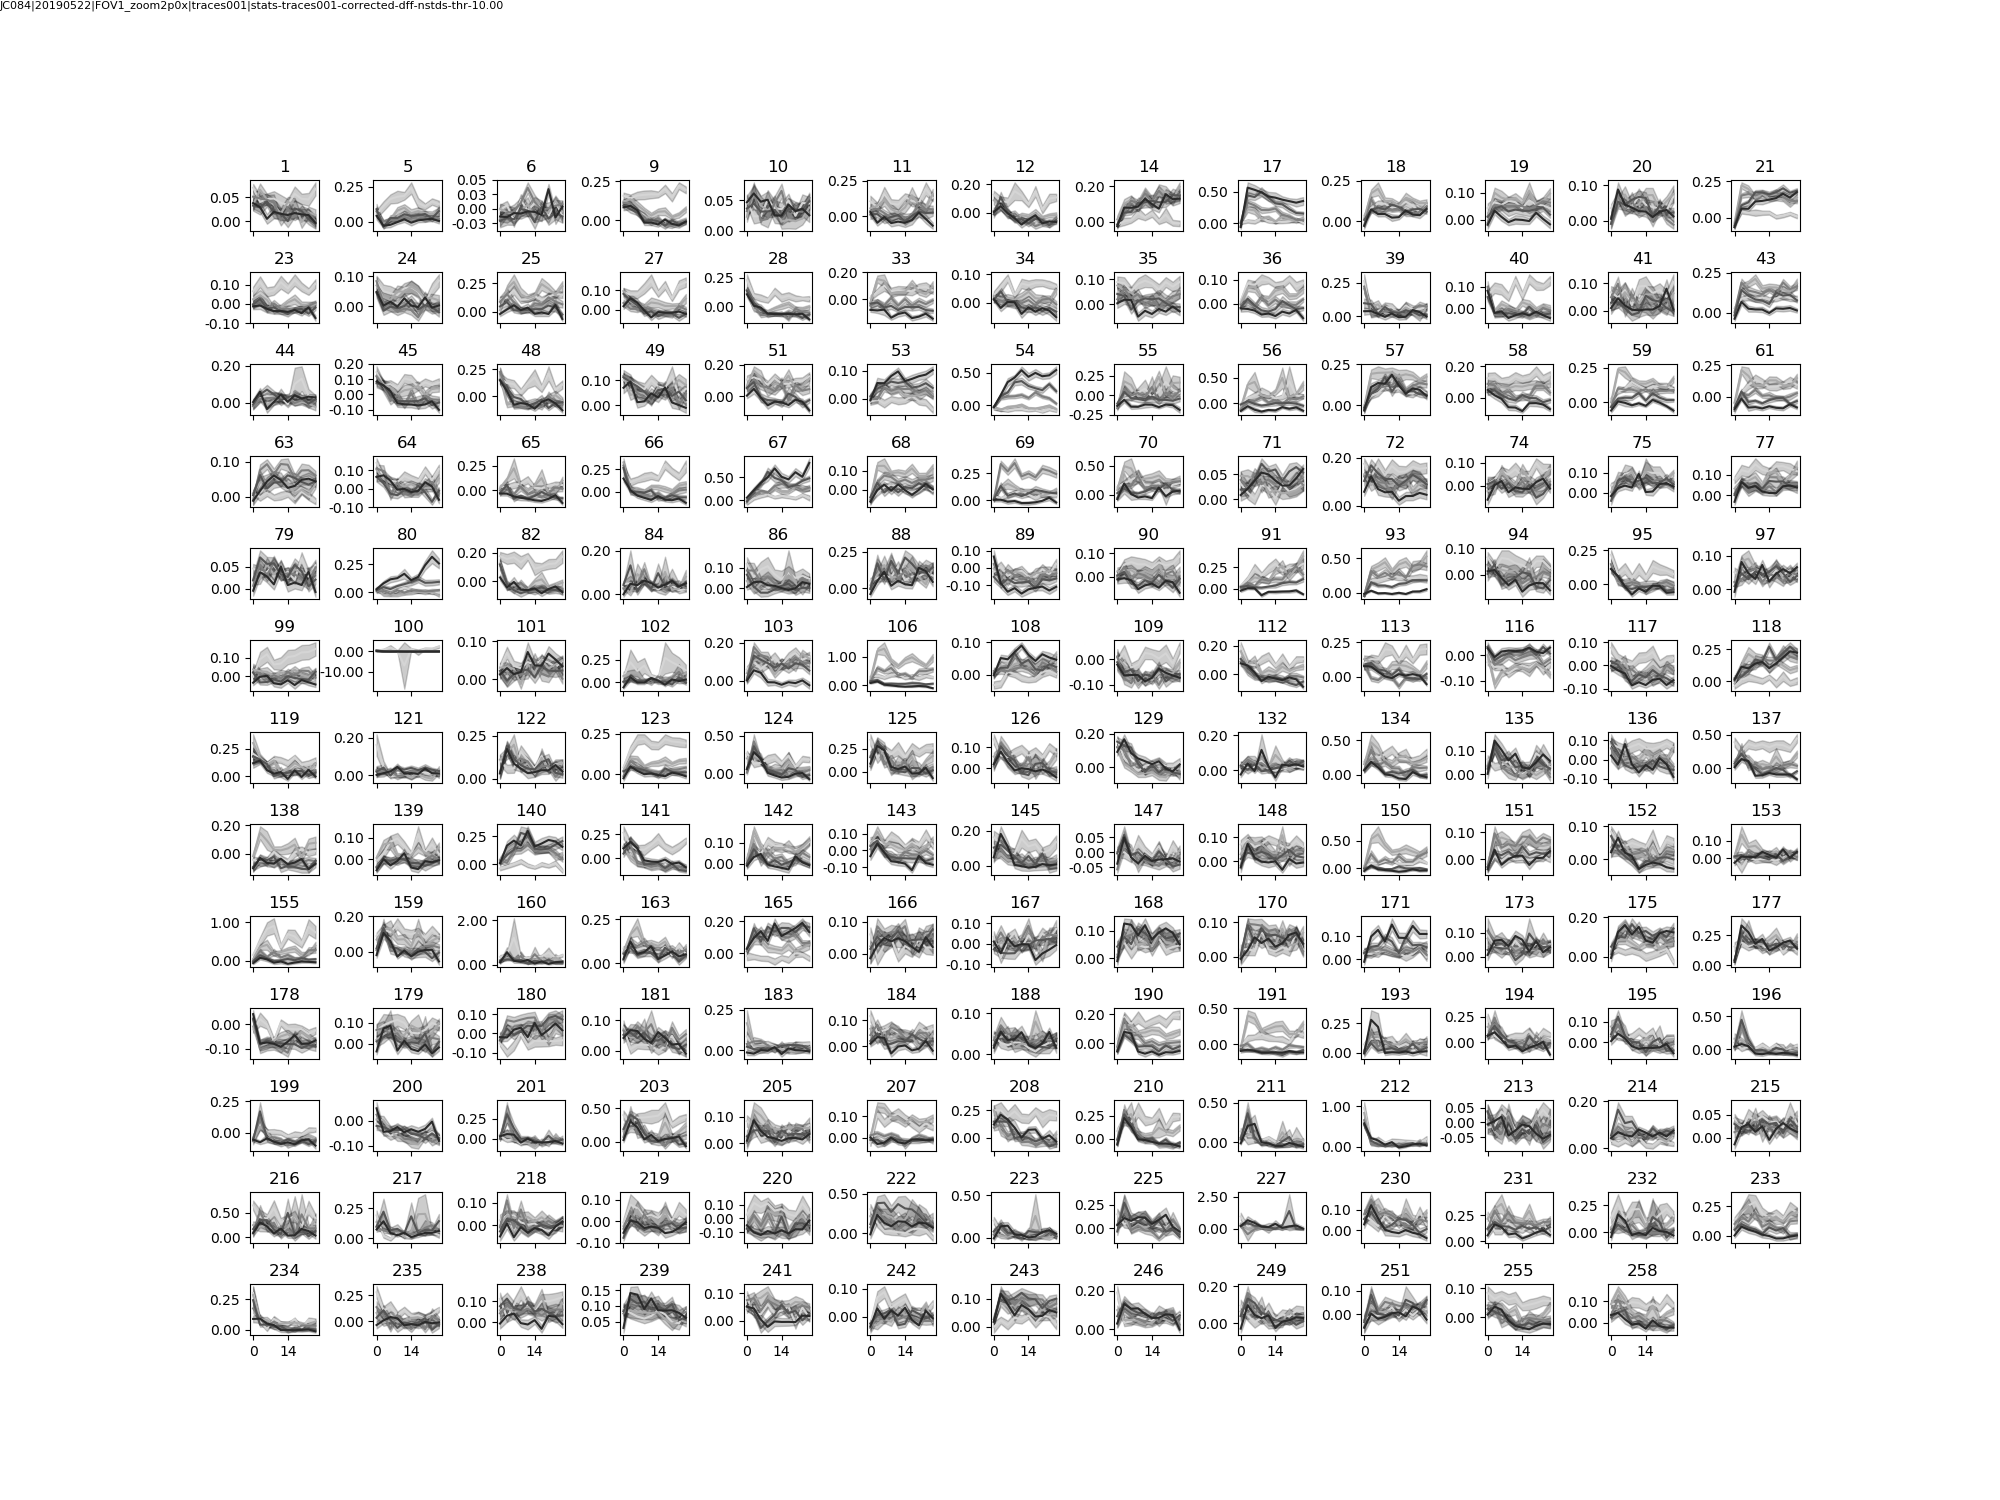

In [26]:

fig = plot_roi_tuning(df_mean, df_sem=df_sem, tune_values=tune_values, tune_name=tune_name,
                     hue_values=hue_values, hue_name=hue_name, hue_colors=hcolors)
# if threshold_dff:
#     figname = '%s-tuning_%s__%s_thr-dff-%.2f_%irois' % (tune_name, visual_area, data_id.replace('|', '_'), min_dff, len(rois_plot))
# else:
#     figname = '%s-tuning_%s__%s_all-resp_%irois' % (tune_name, visual_area, data_id.replace('|', '_'), len(rois_plot))


In [60]:
data_id

'JC076|20190422|FOV1_zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00'

In [61]:
len(glob.glob(os.path.join(outdir, 'sessions', 'morph-tuning_%s__%s*.png' % (visual_area, data_id.replace('|', '_')))))

1

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blo

<IPython.core.display.Javascript object>


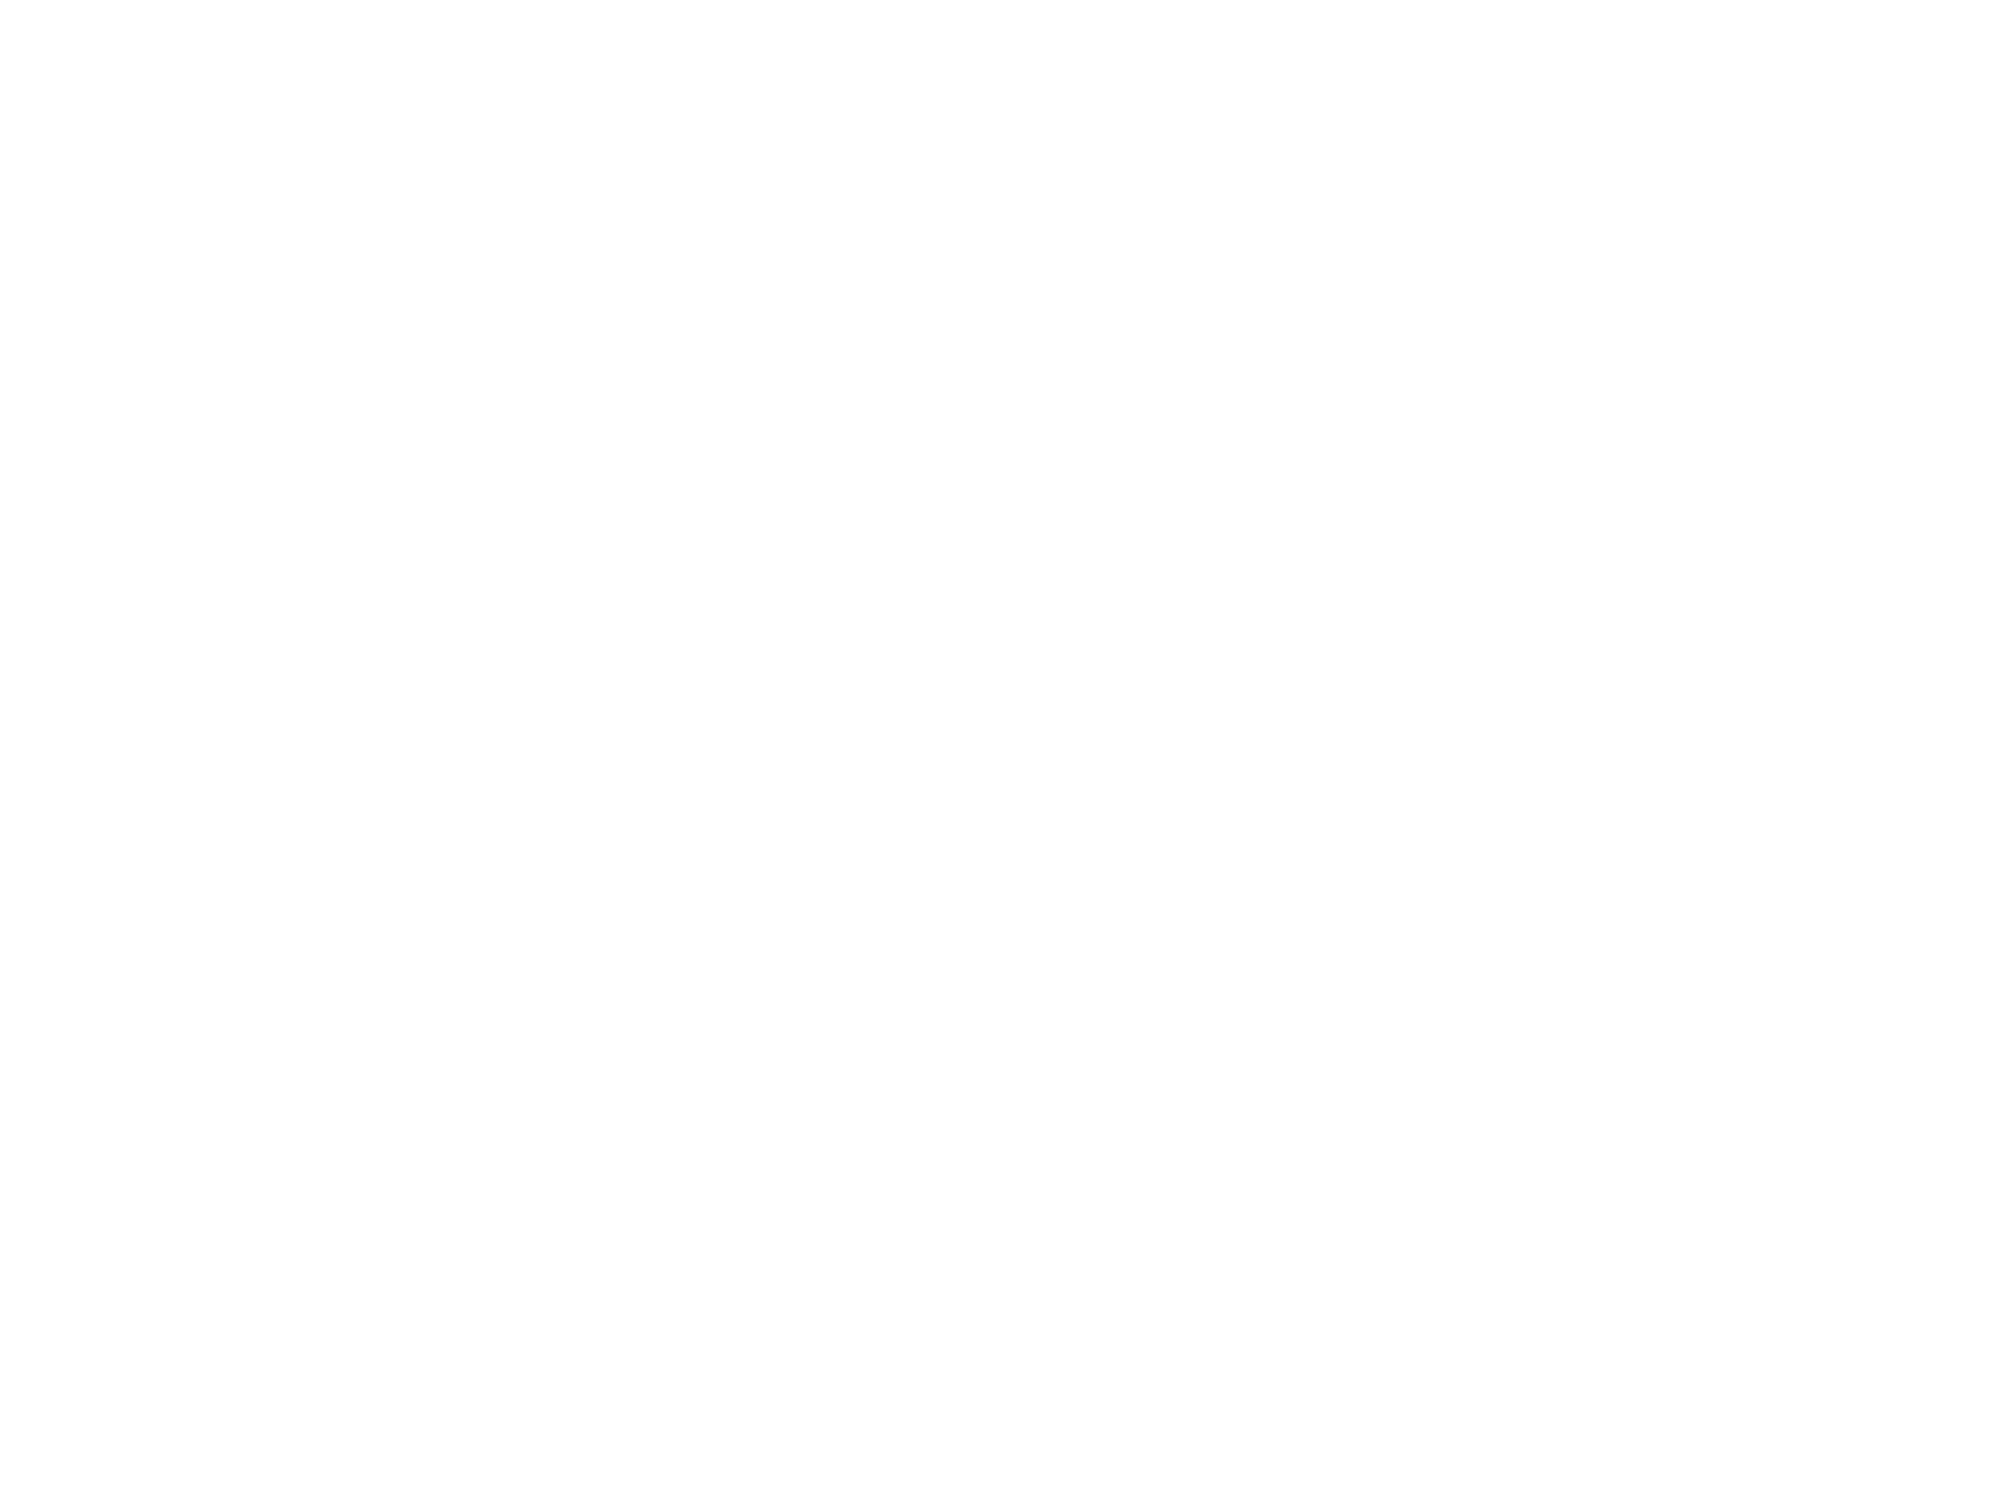

morph-tuning_Lm__JC078_20190430_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_152-of-185rois
... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 368.74
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 188 responsive cells.
N rois to plot: 155
(12, 13)


<IPython.core.display.Javascript object>


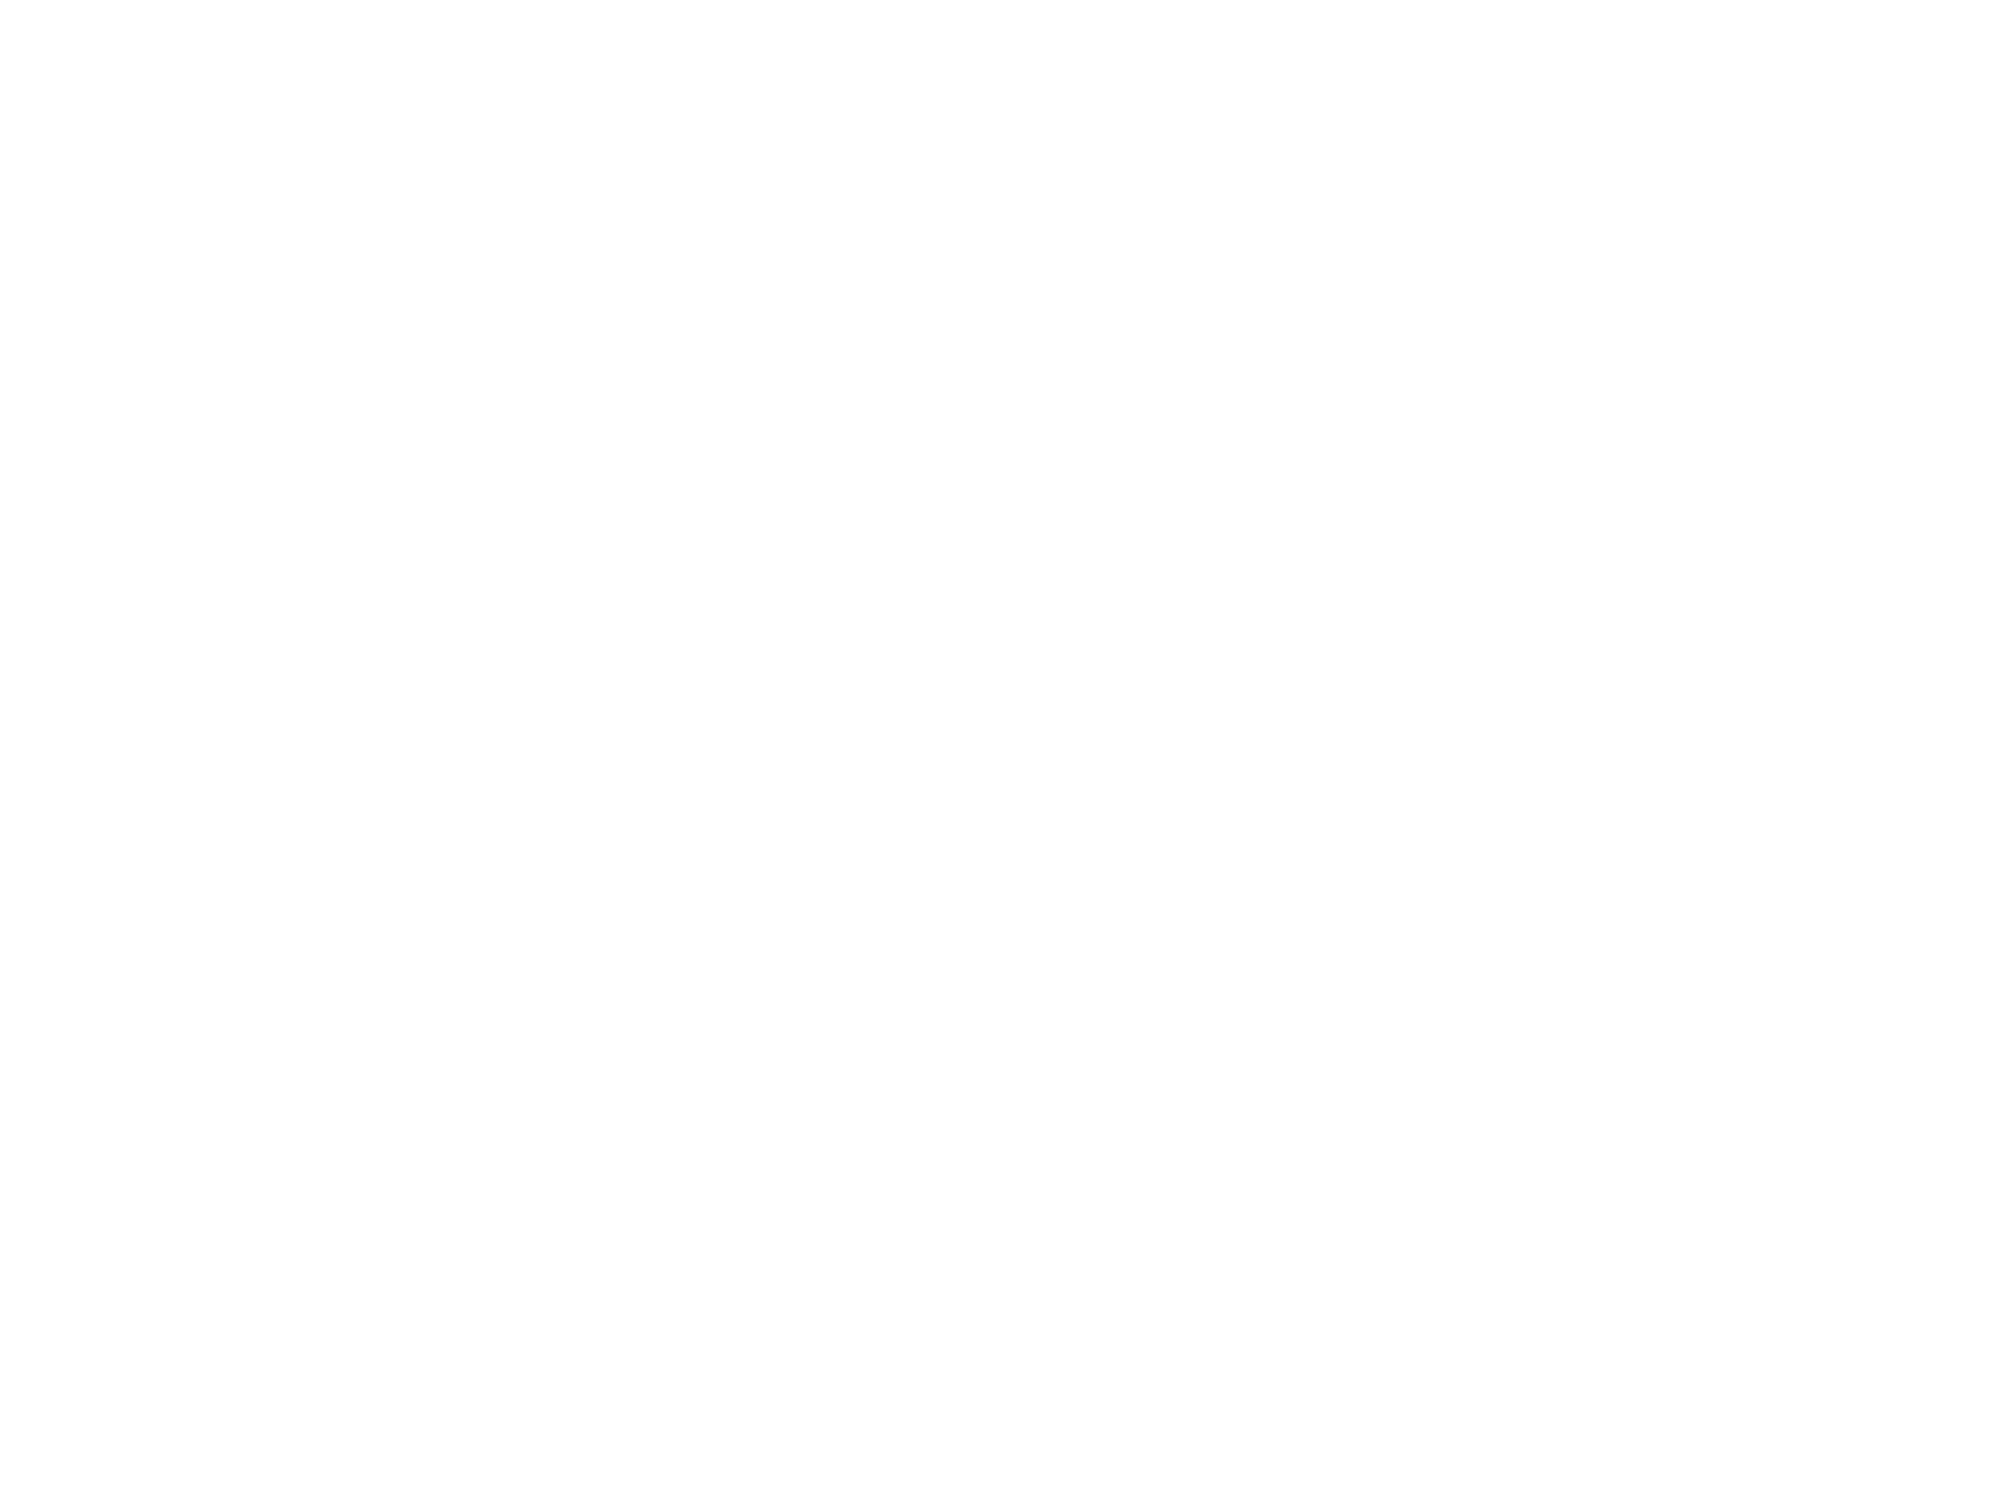

morph-tuning_Lm__JC078_20190504_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_155-of-188rois
... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 329.04
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 123 of 165 responsive cells.
N rois to plot: 123
(11, 12)


<IPython.core.display.Javascript object>


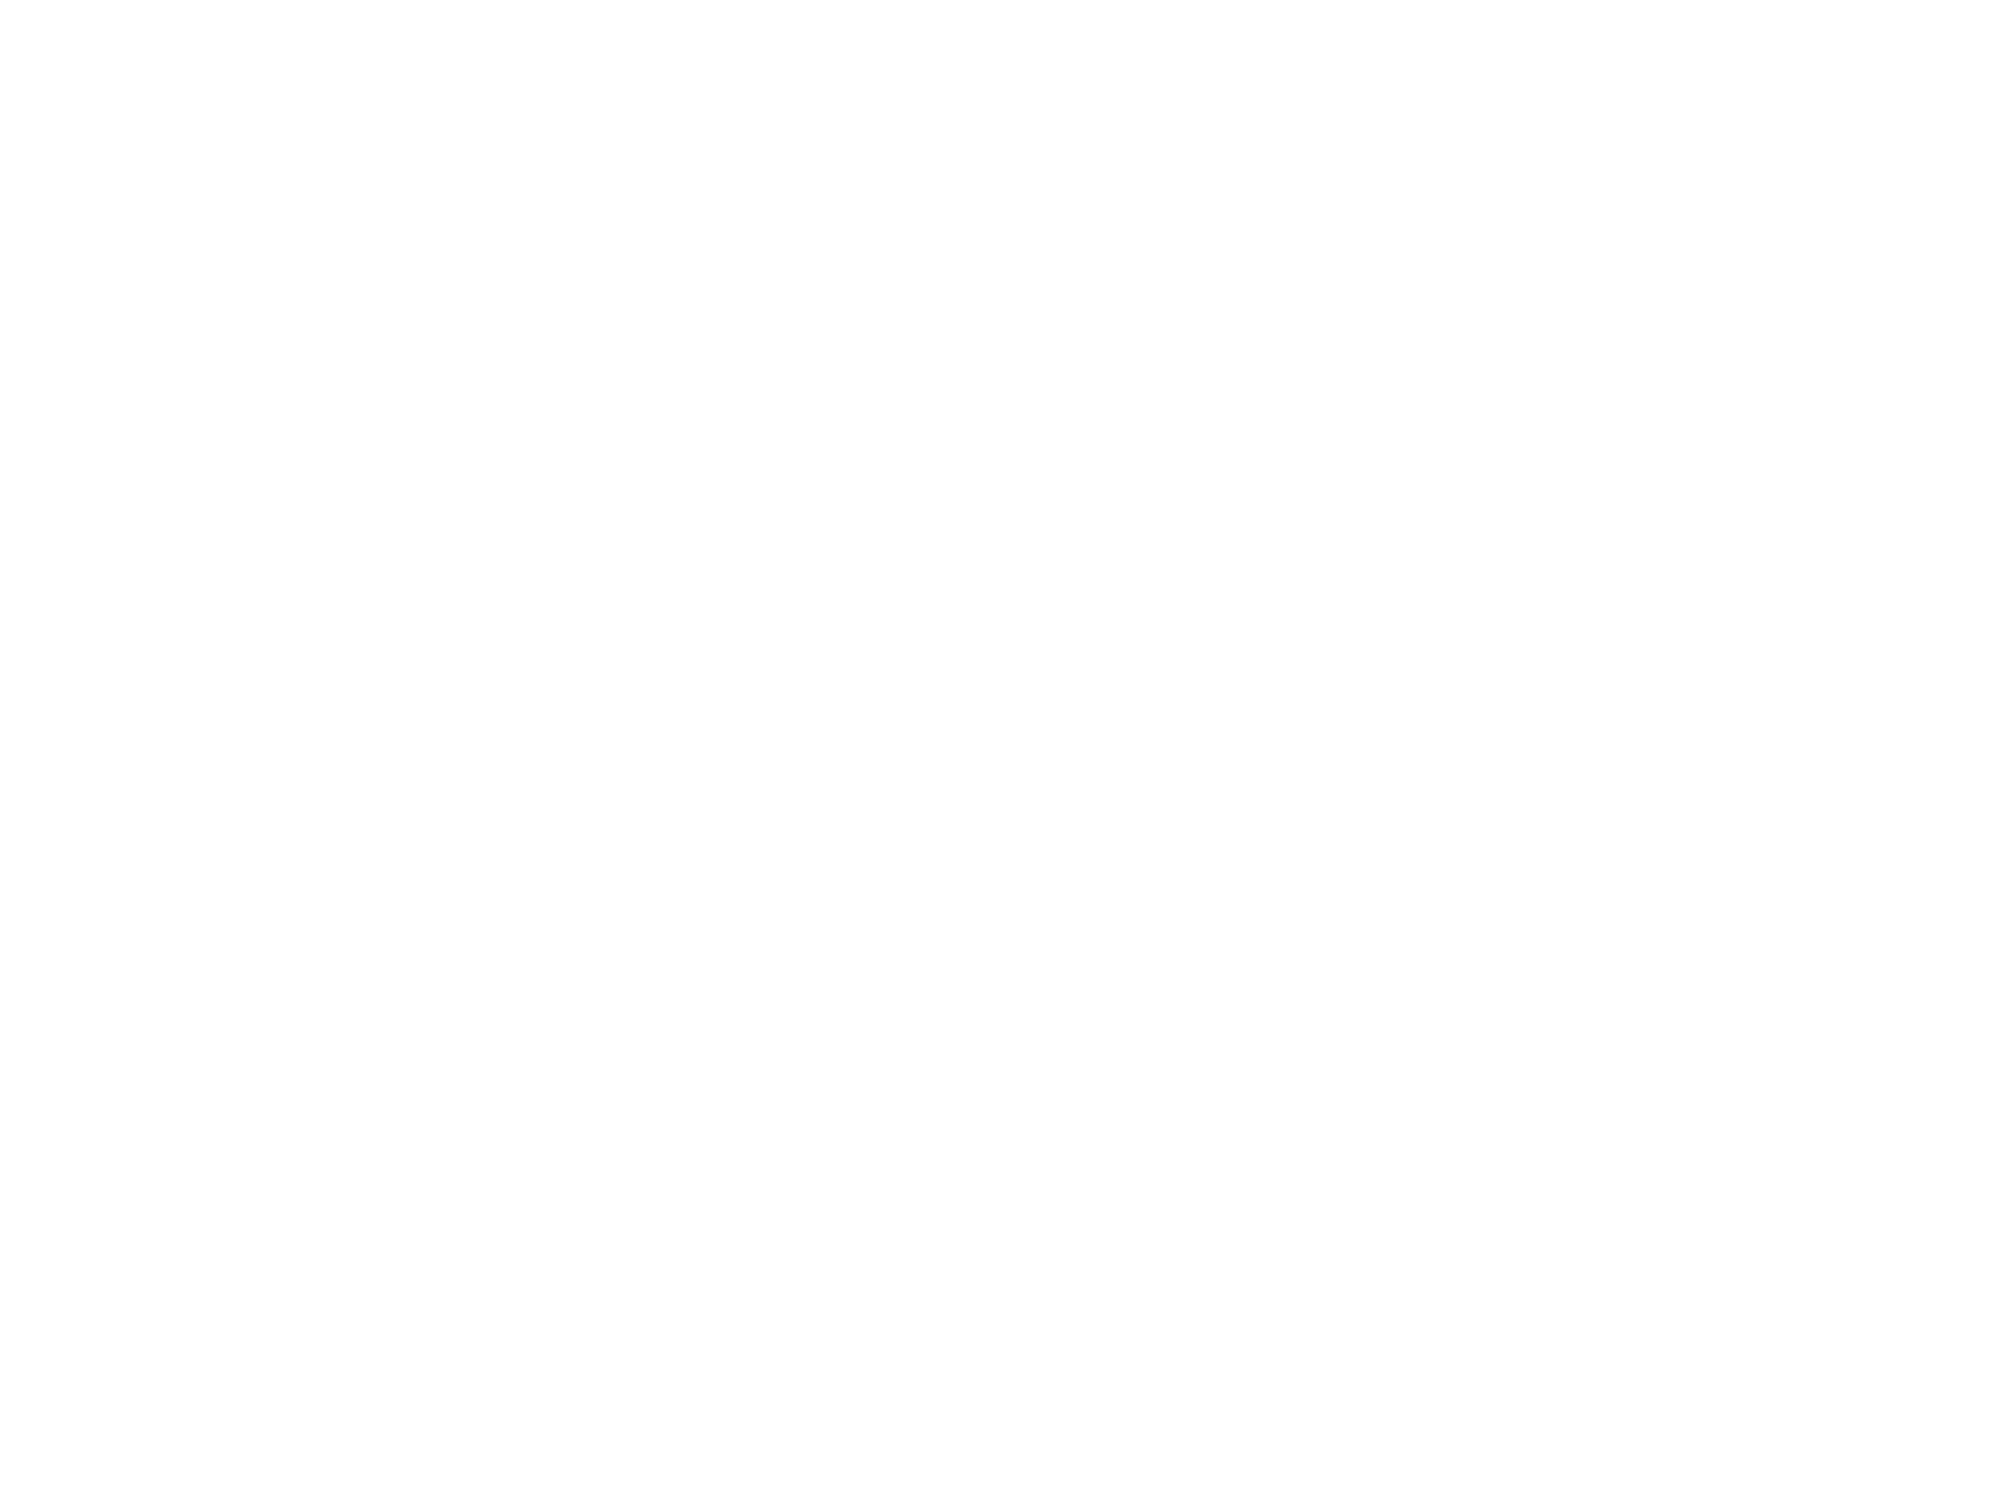

morph-tuning_Lm__JC078_20190509_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_123-of-165rois
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 422.91
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 177 responsive cells.
N rois to plot: 138
(12, 12)


<IPython.core.display.Javascript object>


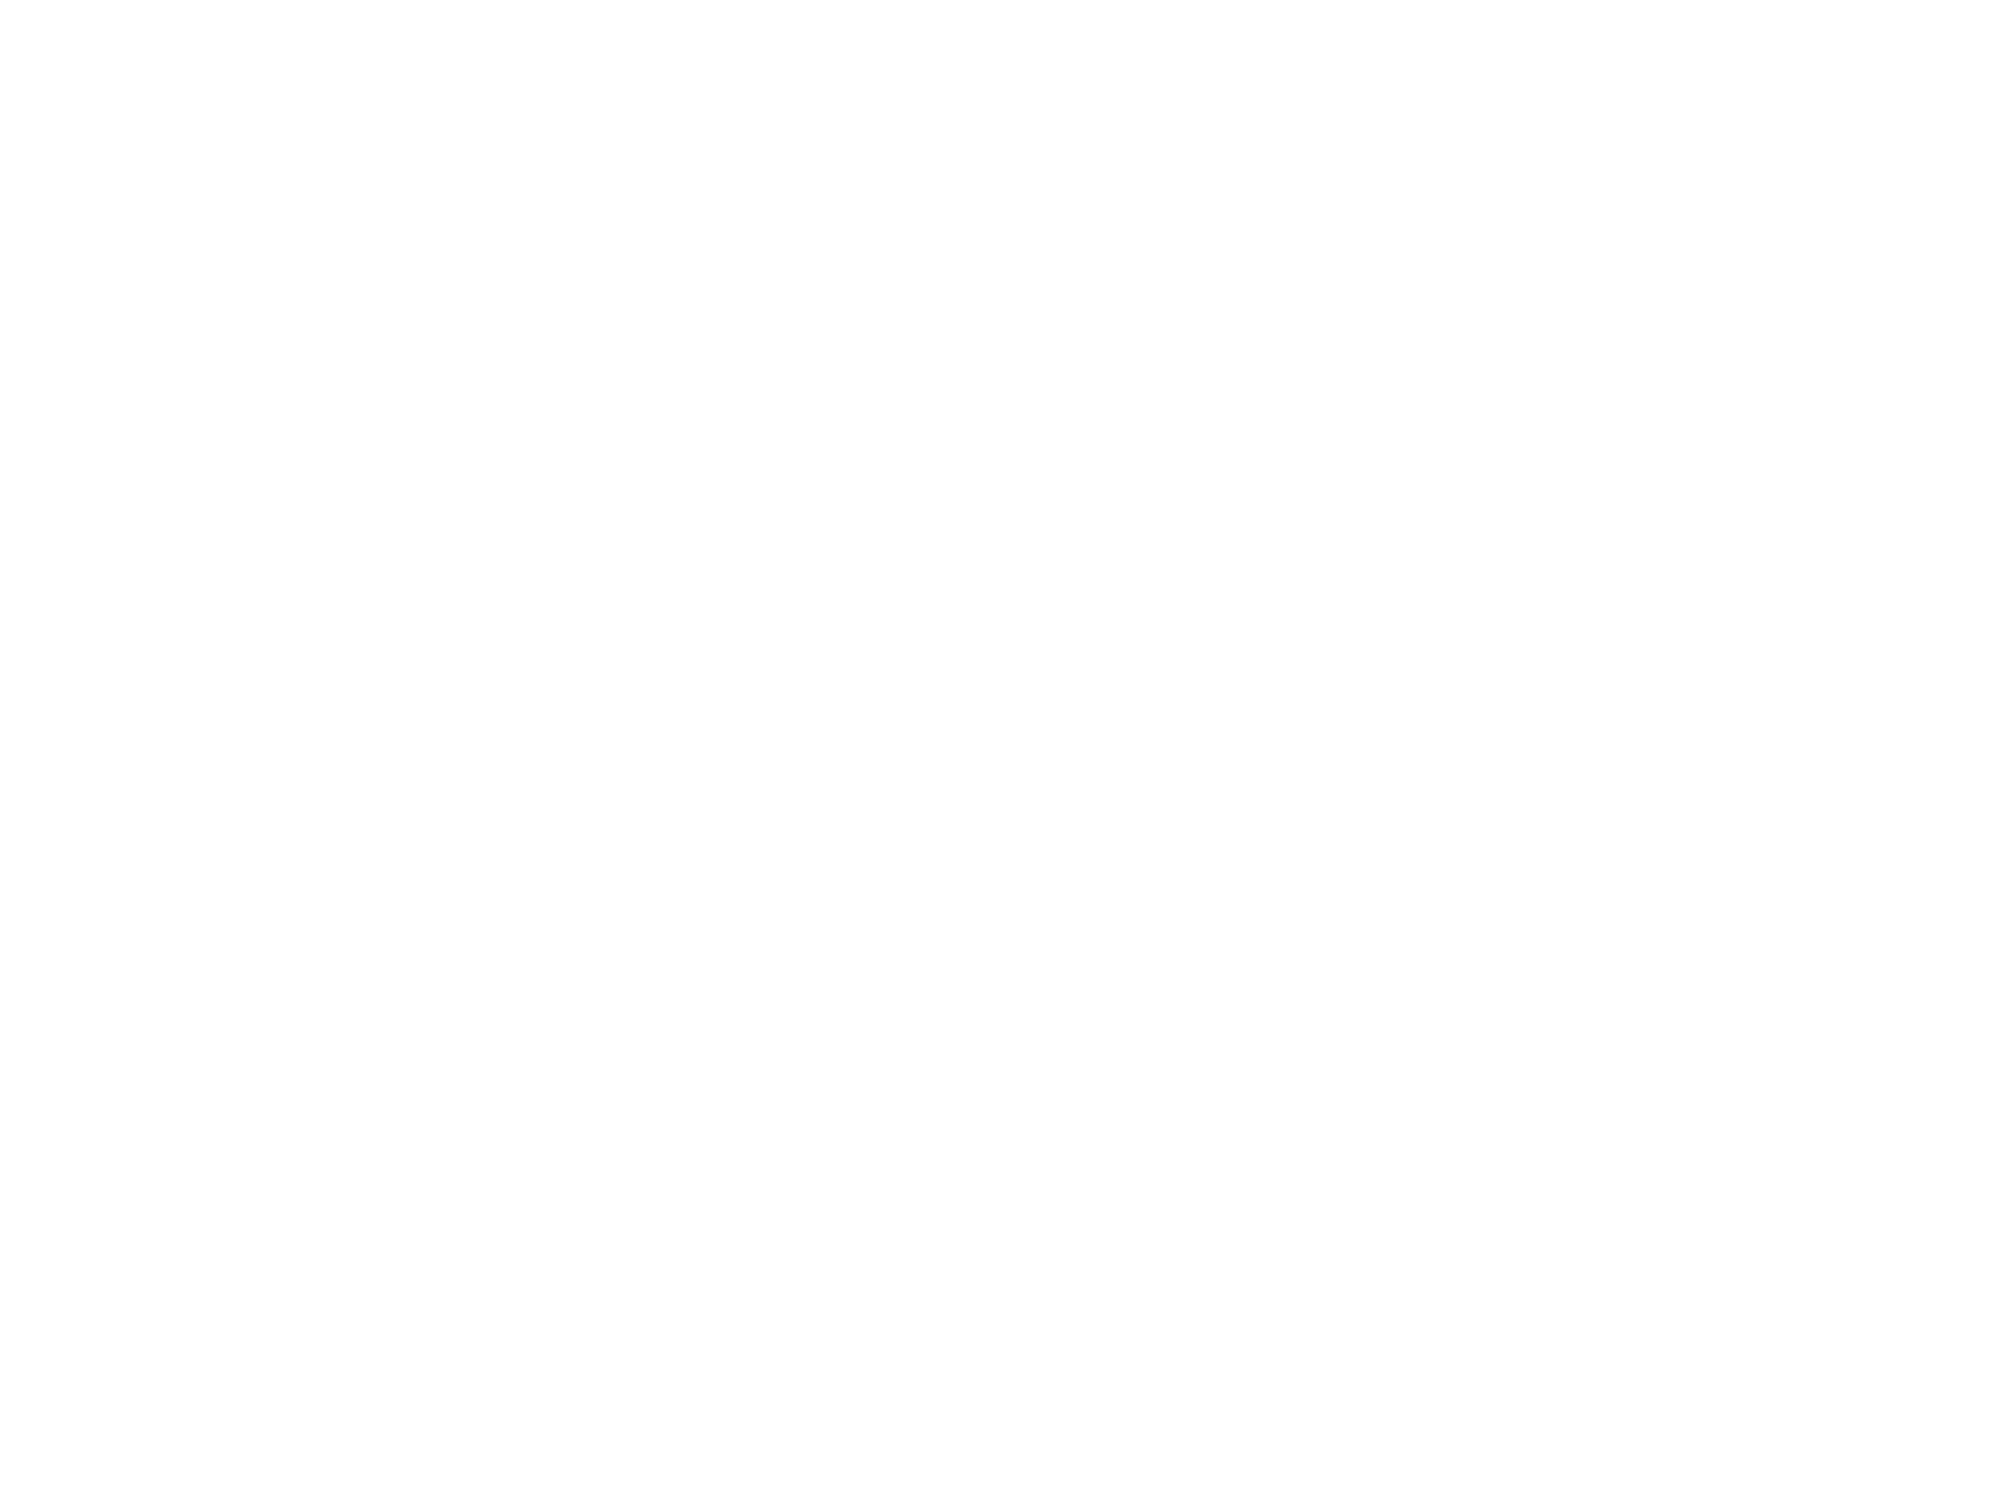

morph-tuning_Lm__JC078_20190513_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_138-of-177rois
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 423.89
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 196 of 225 responsive cells.
N rois to plot: 196
(14, 14)


<IPython.core.display.Javascript object>


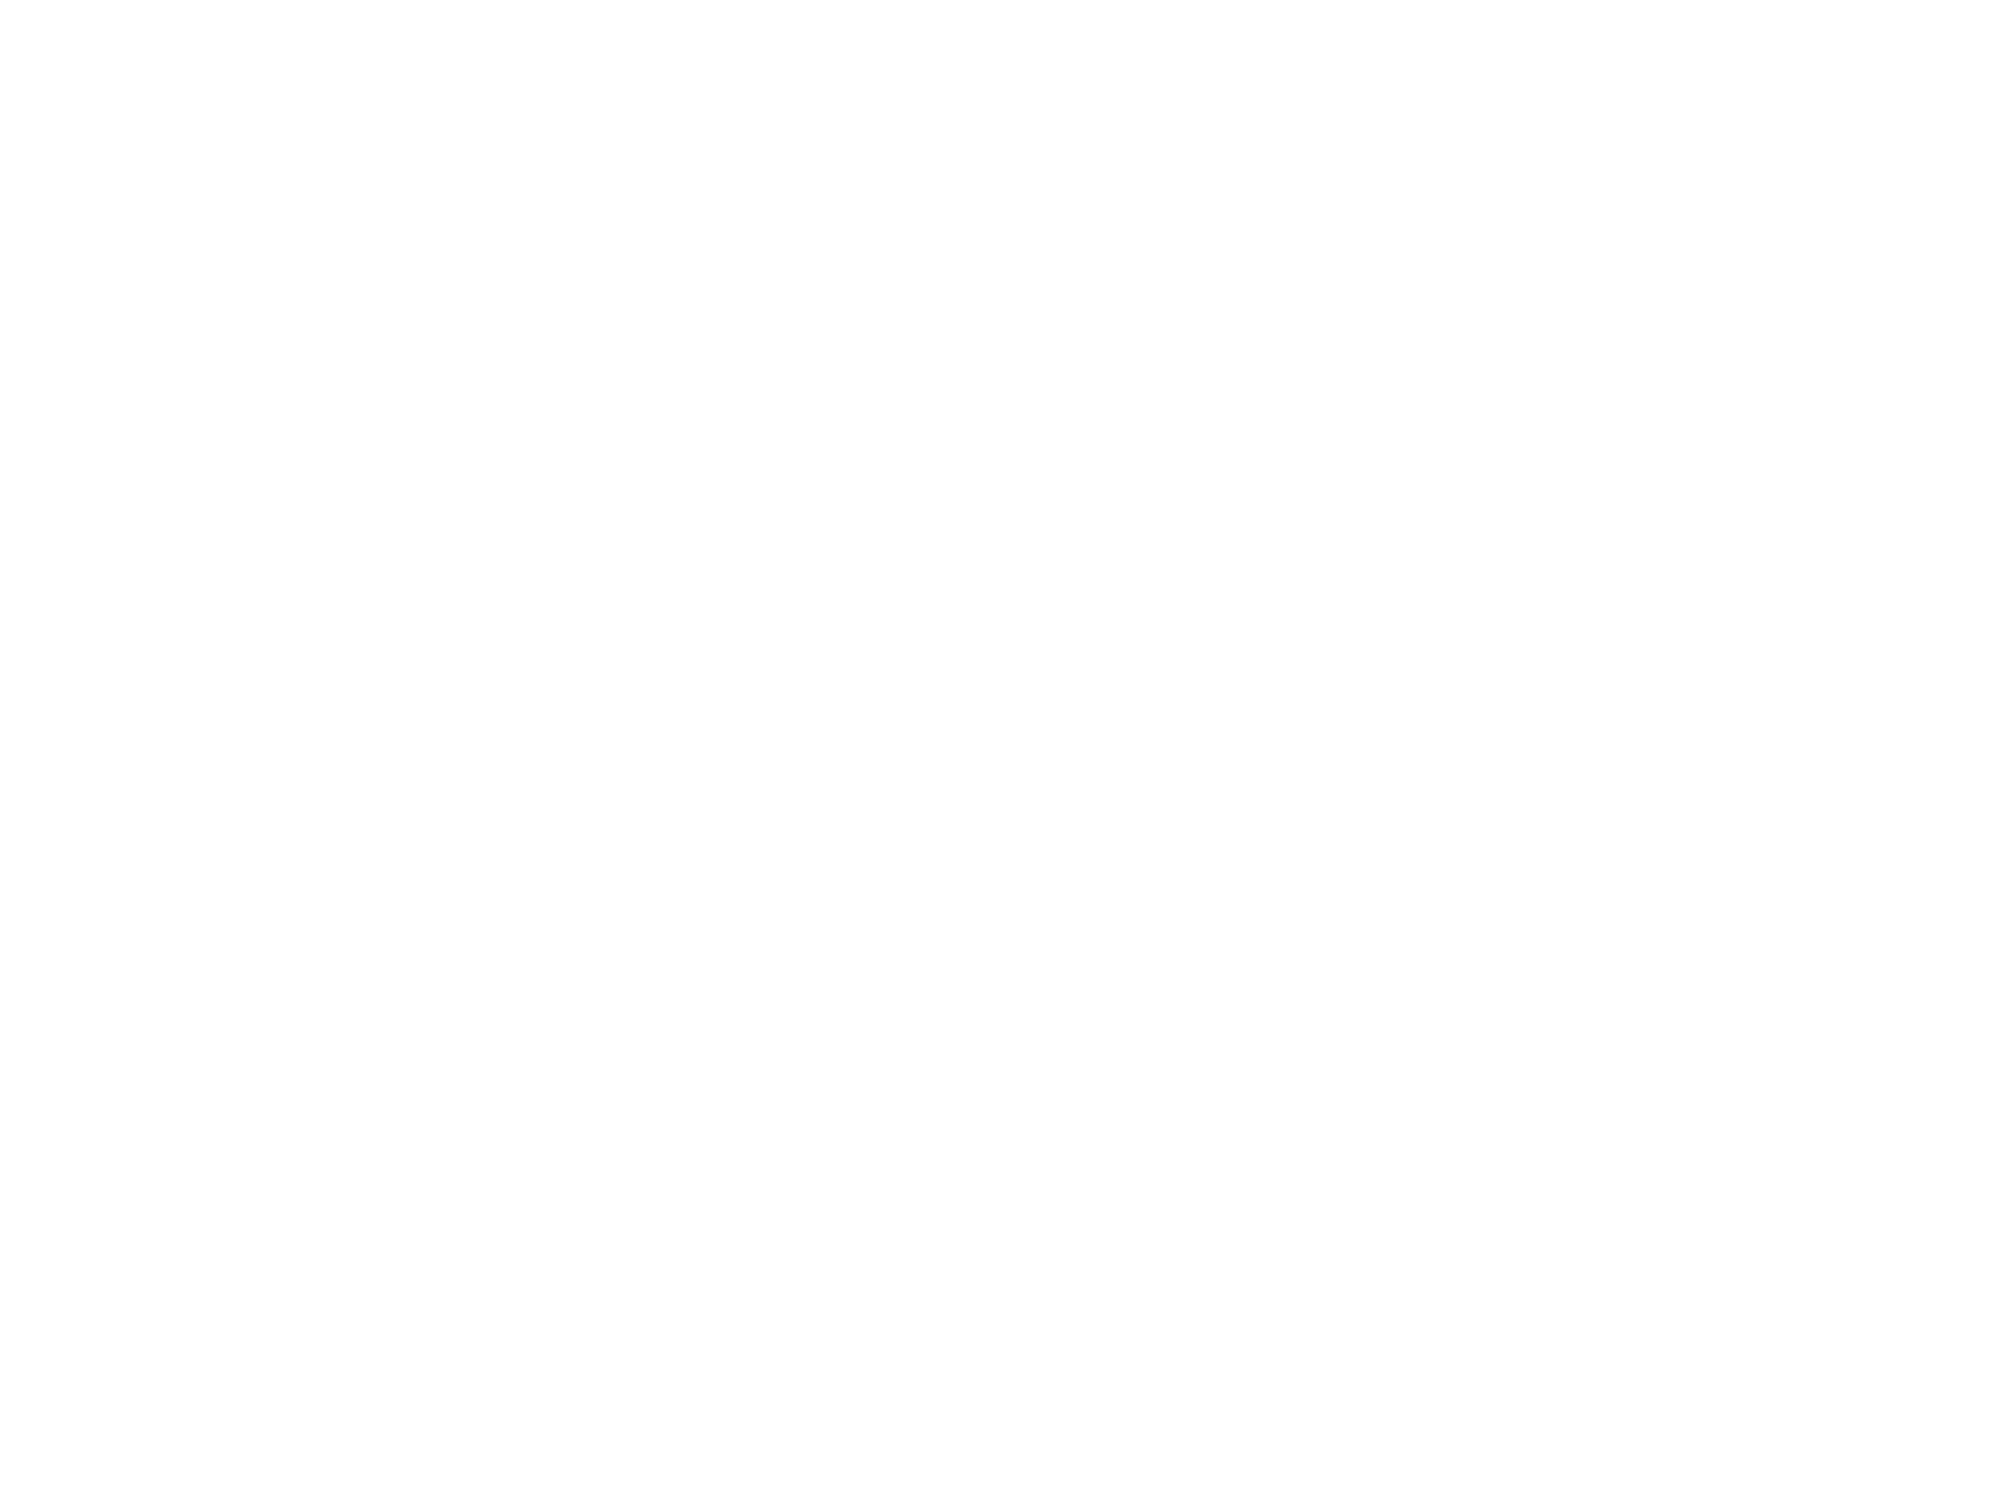

morph-tuning_Lm__JC080_20190506_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_196-of-225rois
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 573.12
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 167 of 226 responsive cells.
N rois to plot: 167
(13, 13)


<IPython.core.display.Javascript object>


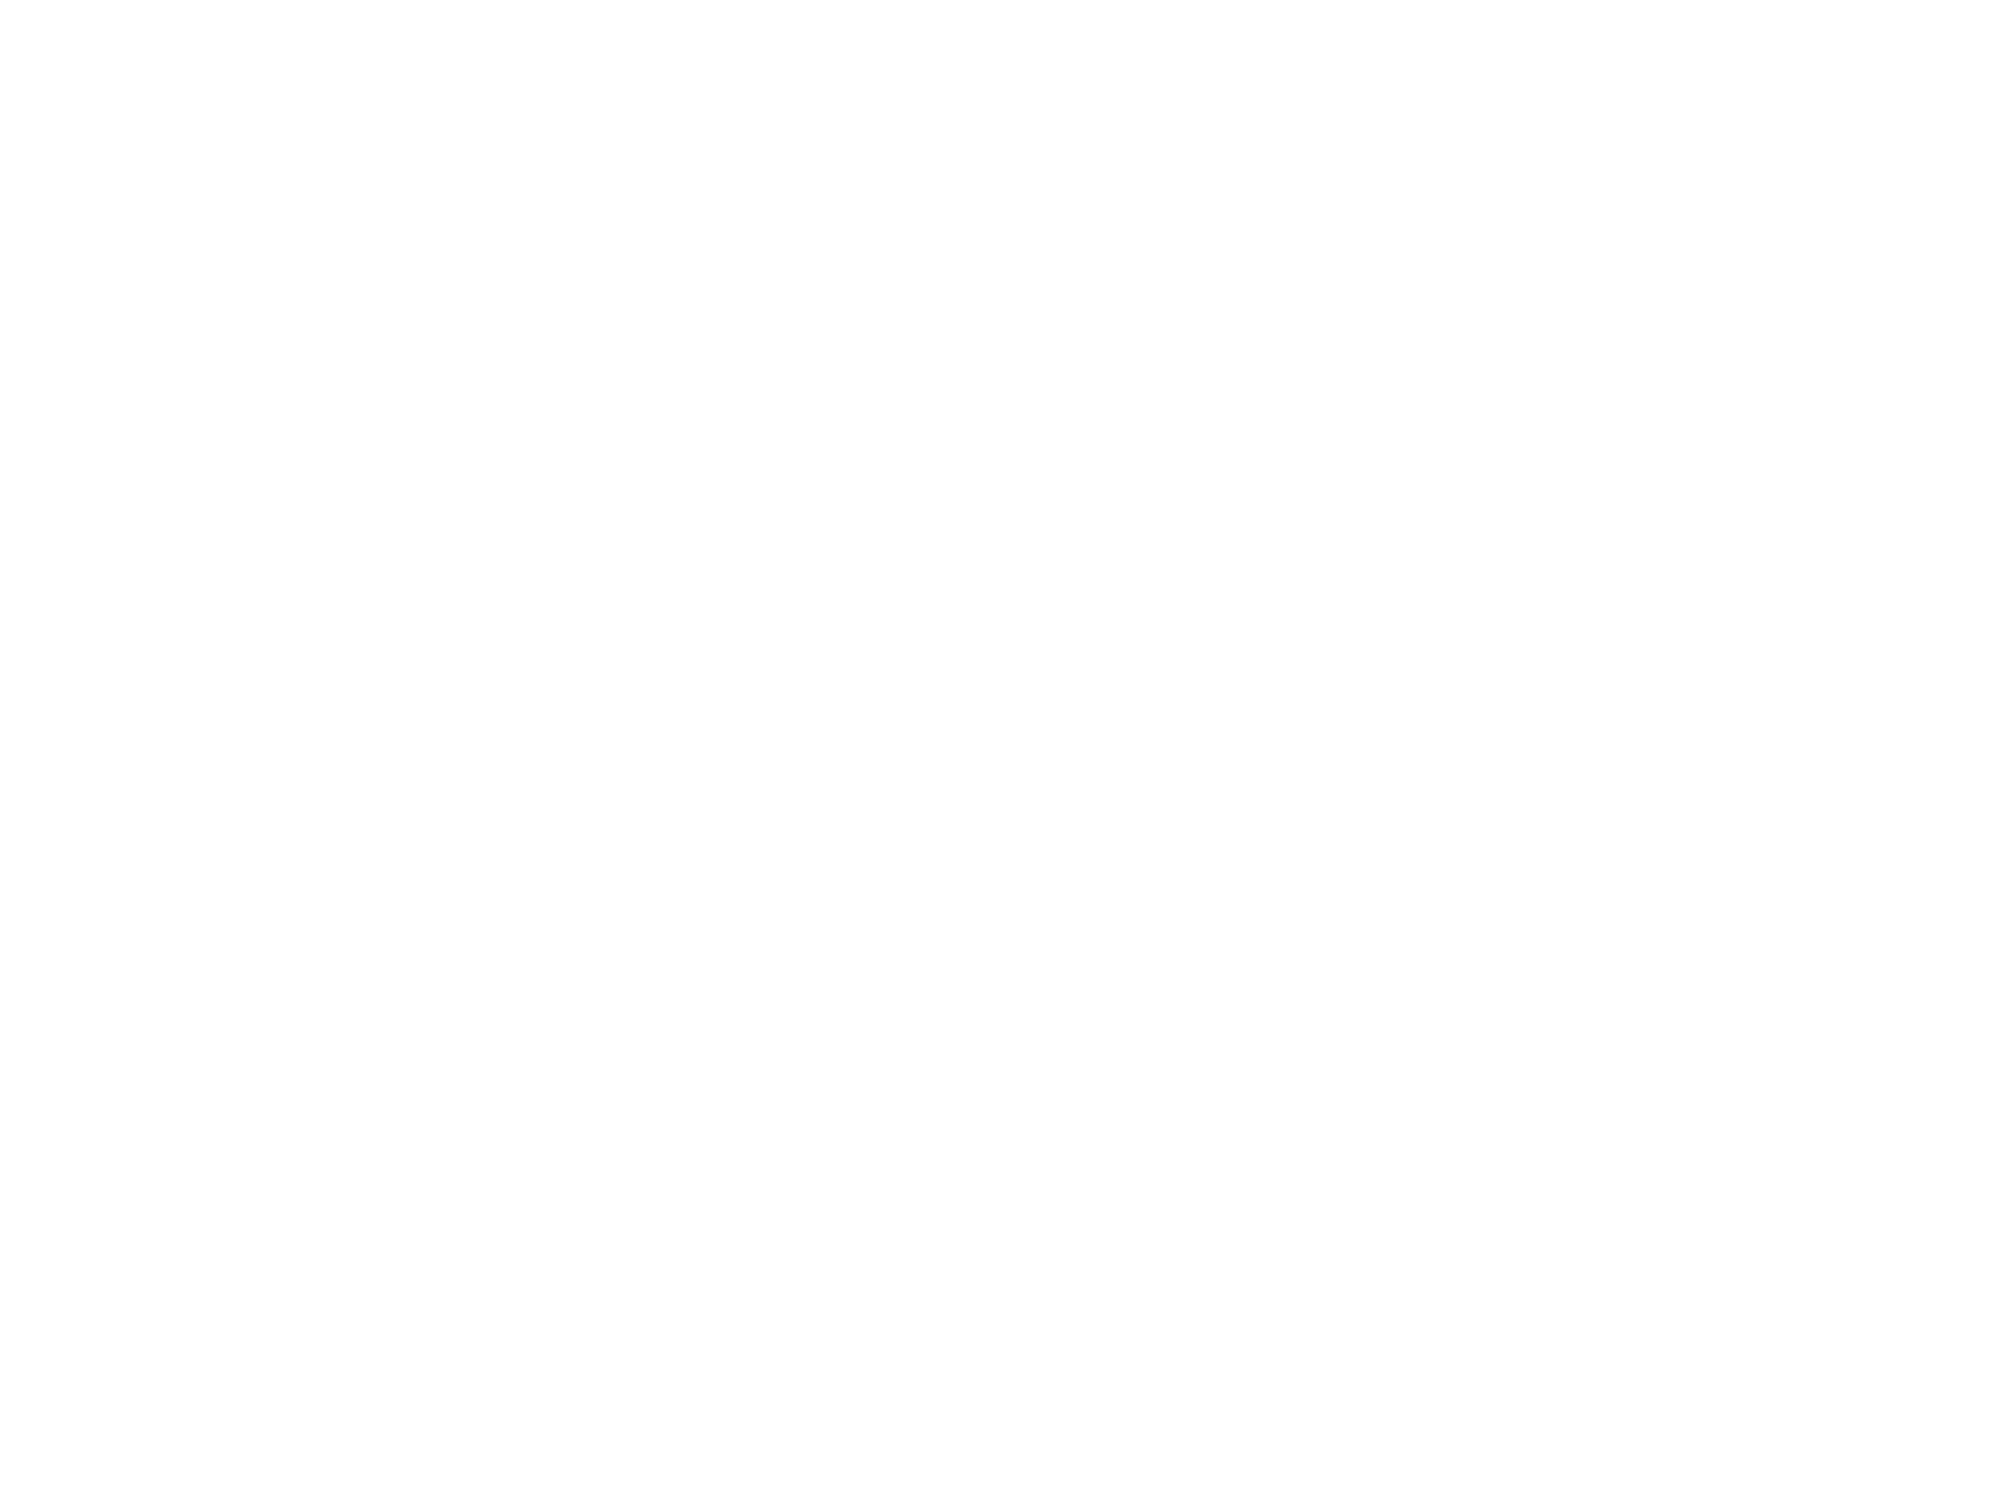

morph-tuning_Lm__JC080_20190603_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_167-of-226rois
... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 516.48
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 129 of 171 responsive cells.
N rois to plot: 129
(11, 12)


<IPython.core.display.Javascript object>


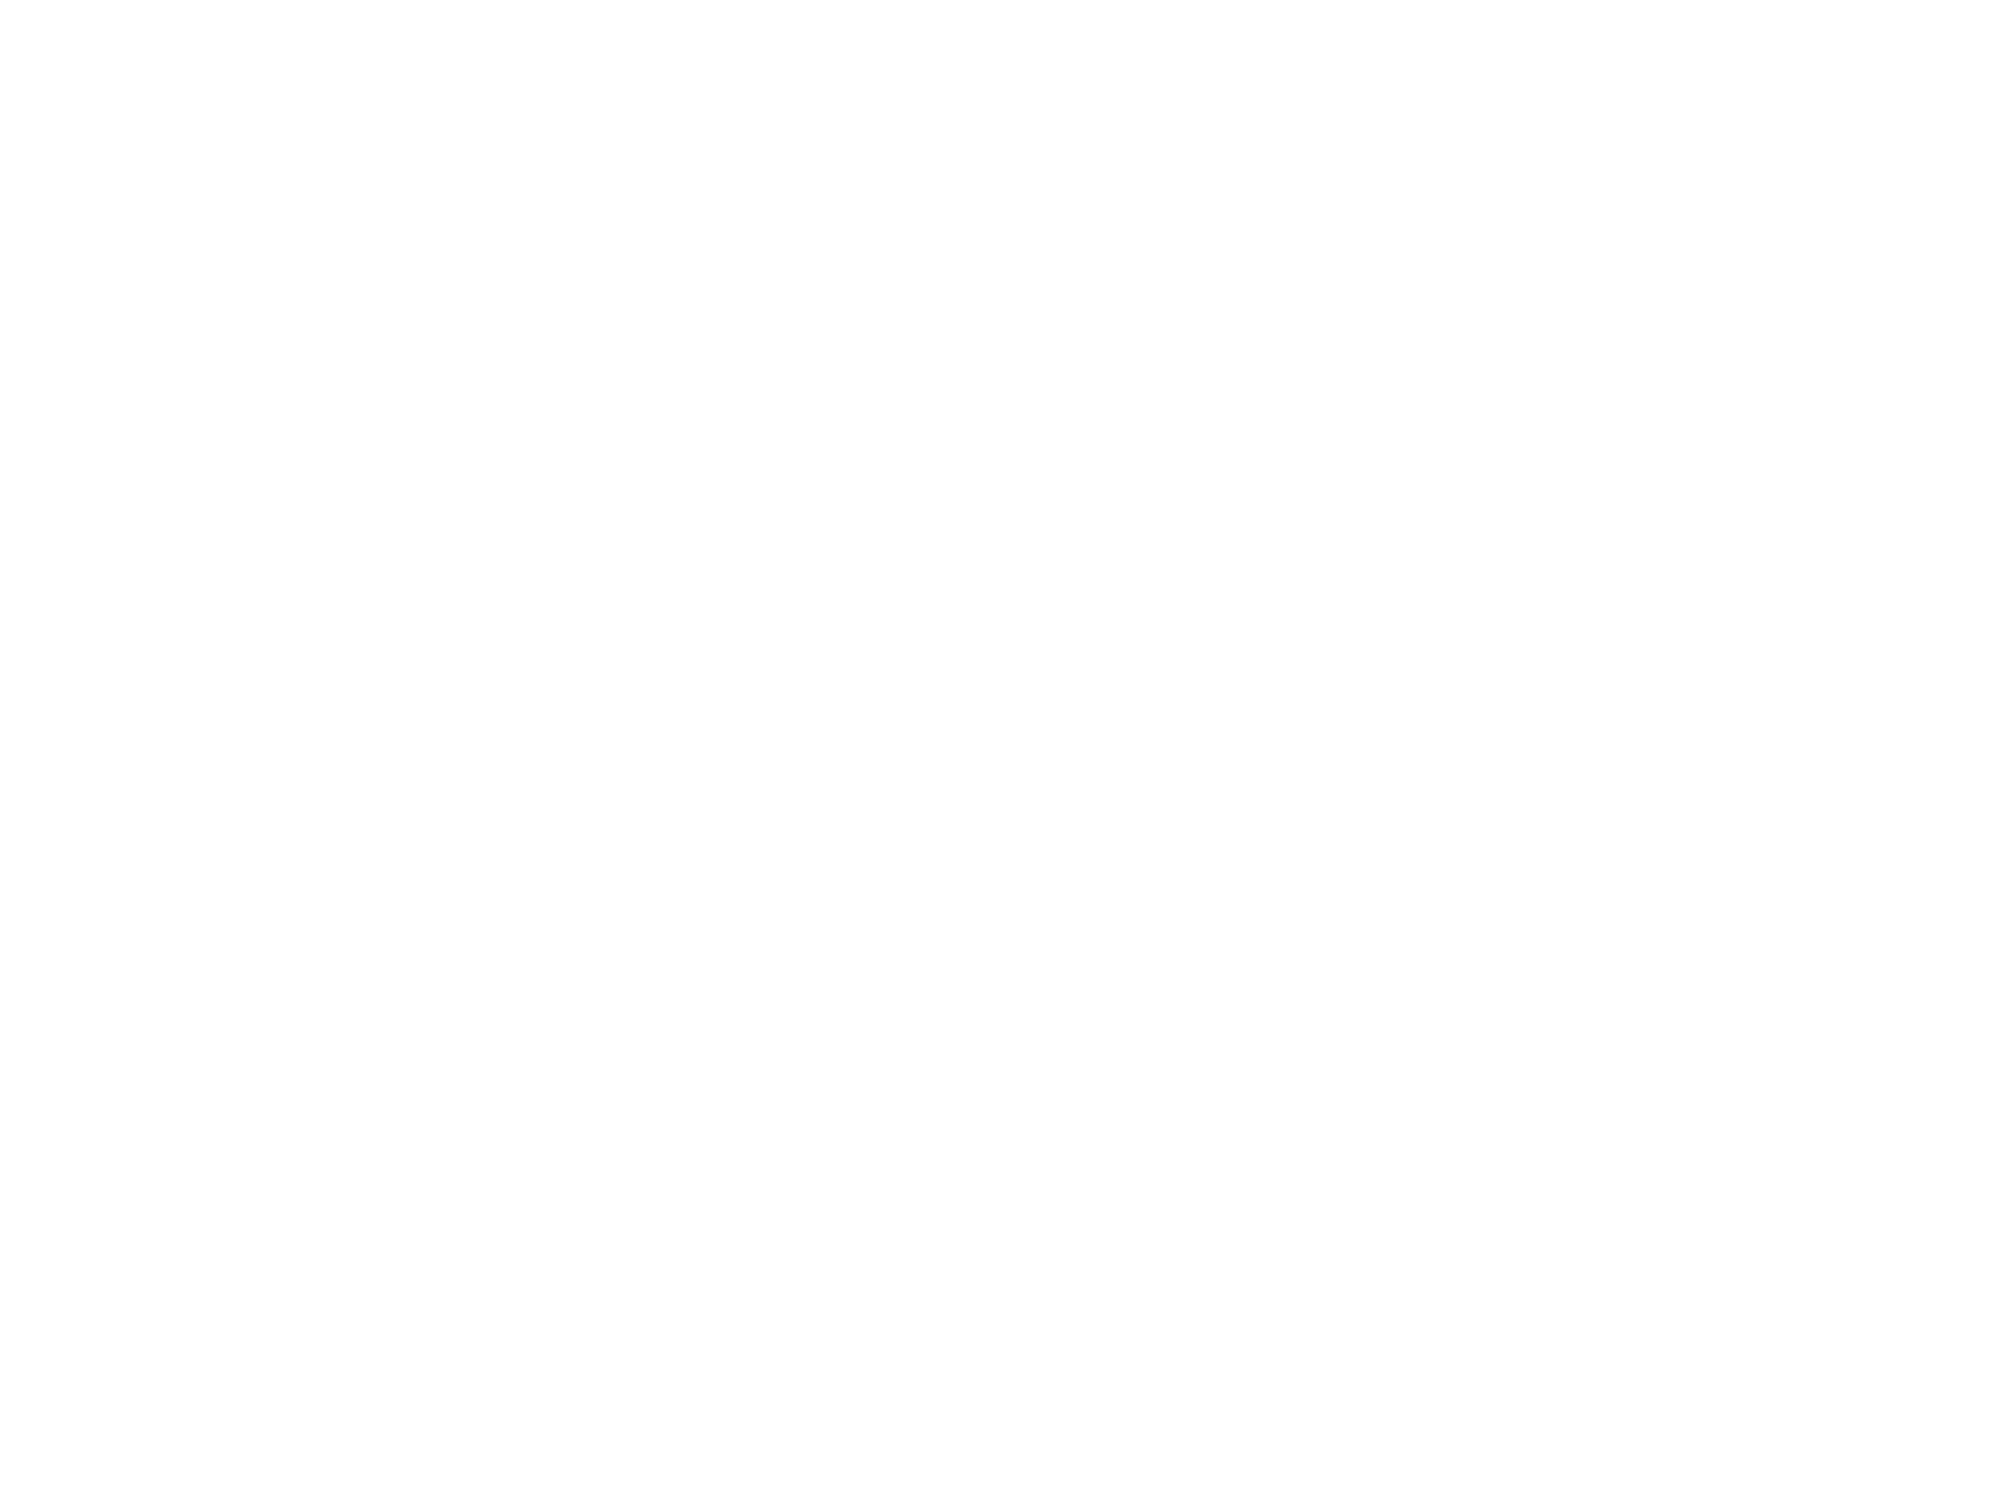

morph-tuning_Lm__JC083_20190508_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_129-of-171rois
... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 582.17
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 142 of 266 responsive cells.
N rois to plot: 142
(12, 12)


<IPython.core.display.Javascript object>


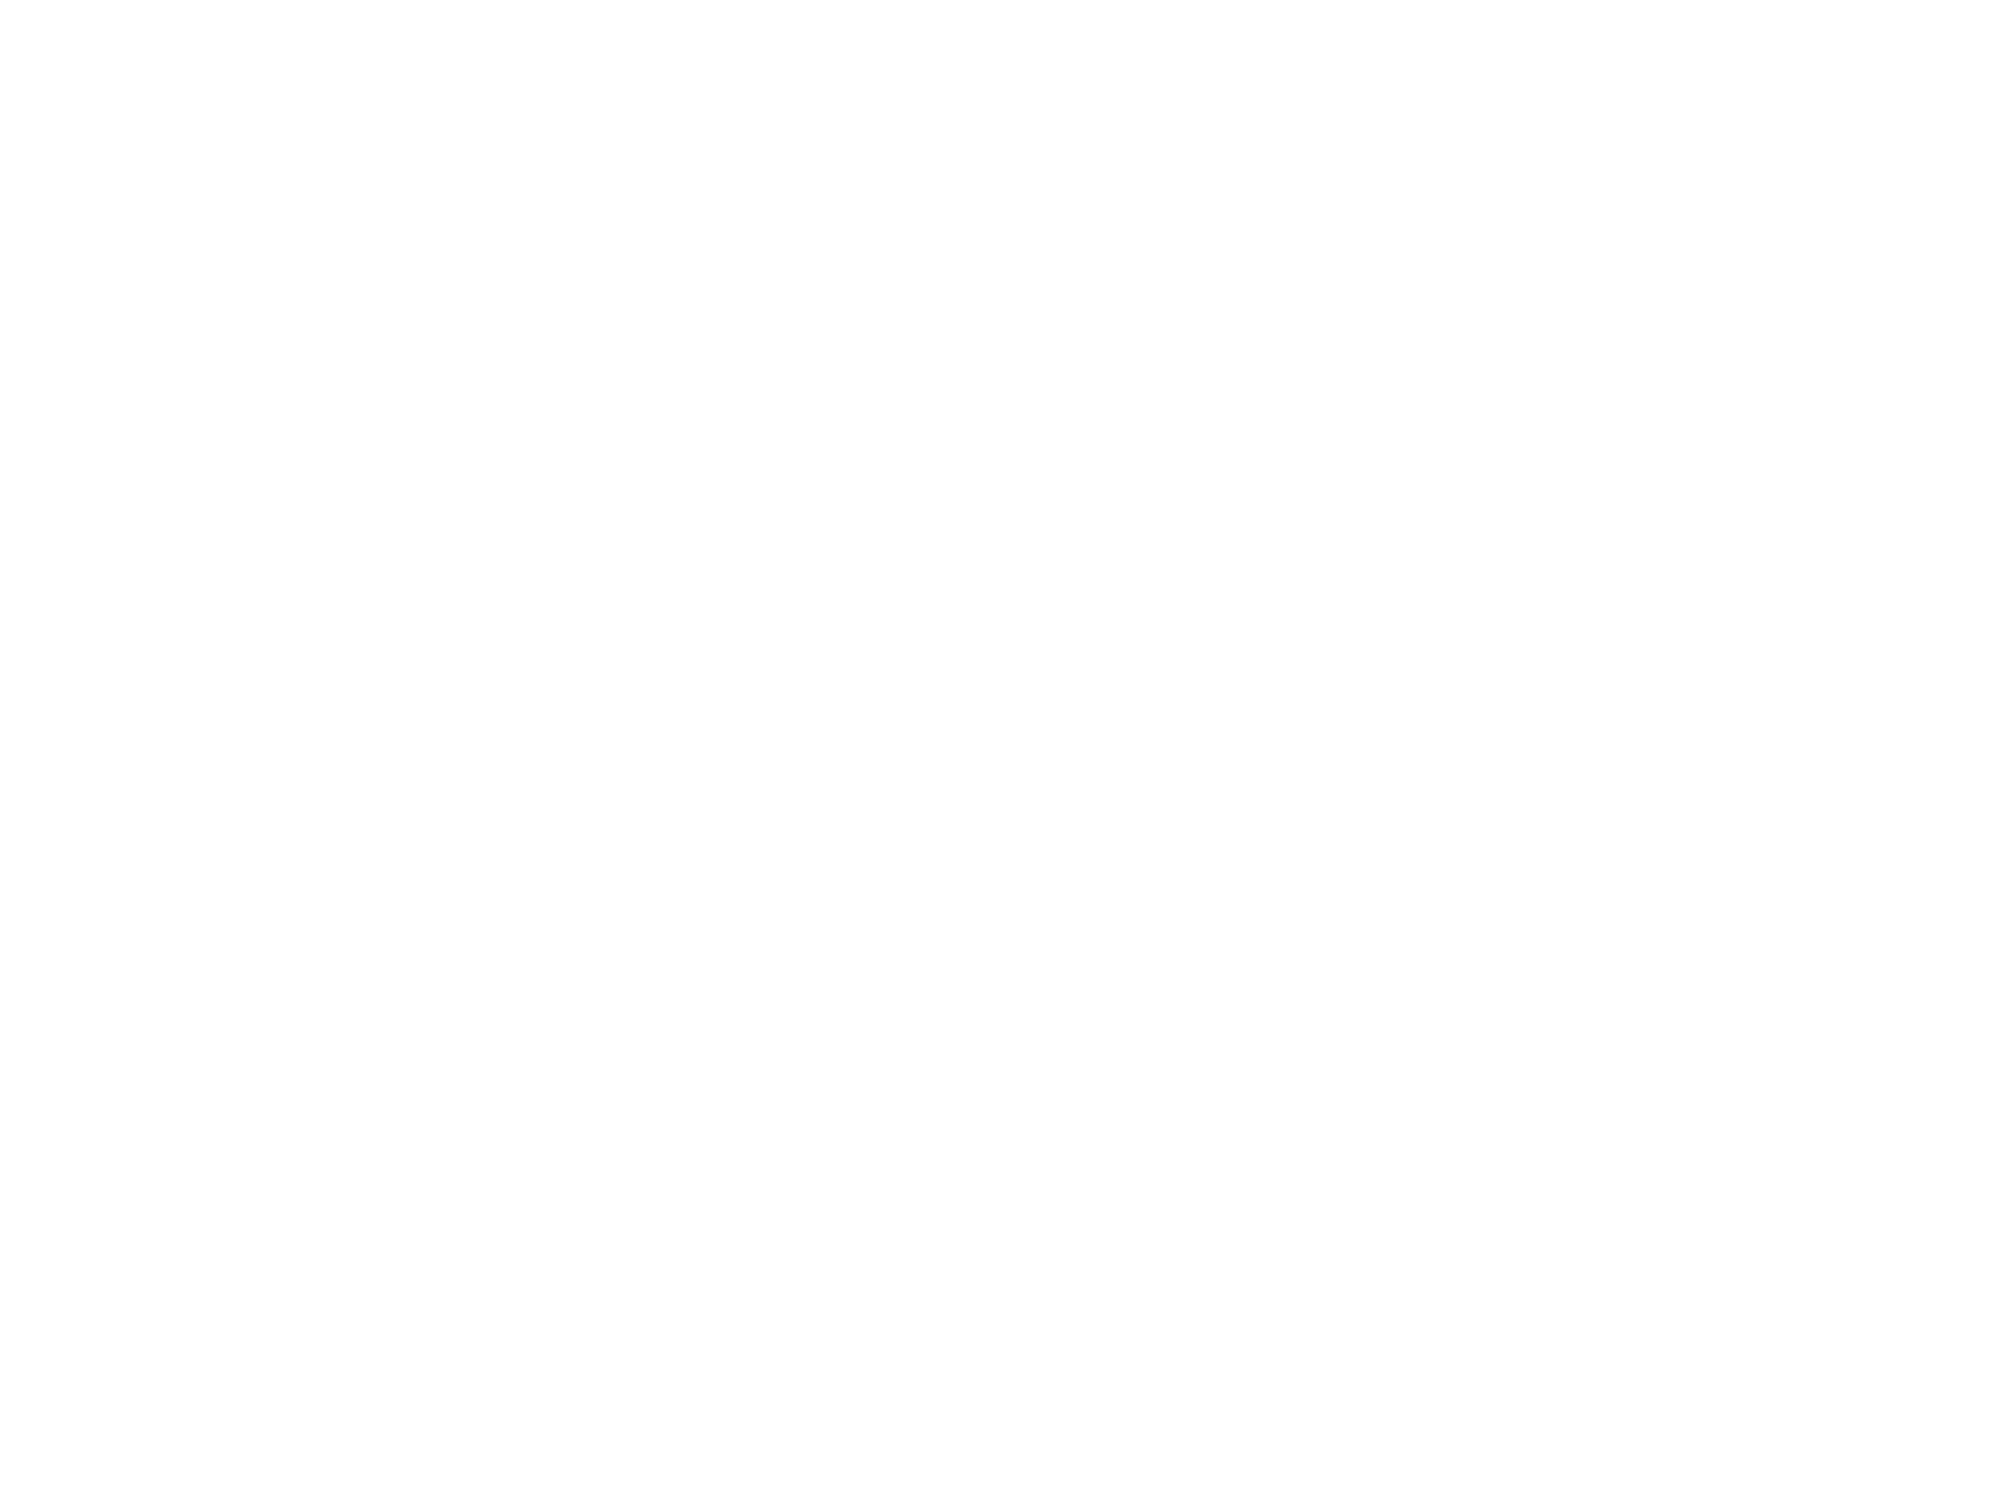

morph-tuning_Lm__JC083_20190512_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_142-of-266rois
... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 501.39
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 111 of 133 responsive cells.
N rois to plot: 111
(11, 11)


<IPython.core.display.Javascript object>


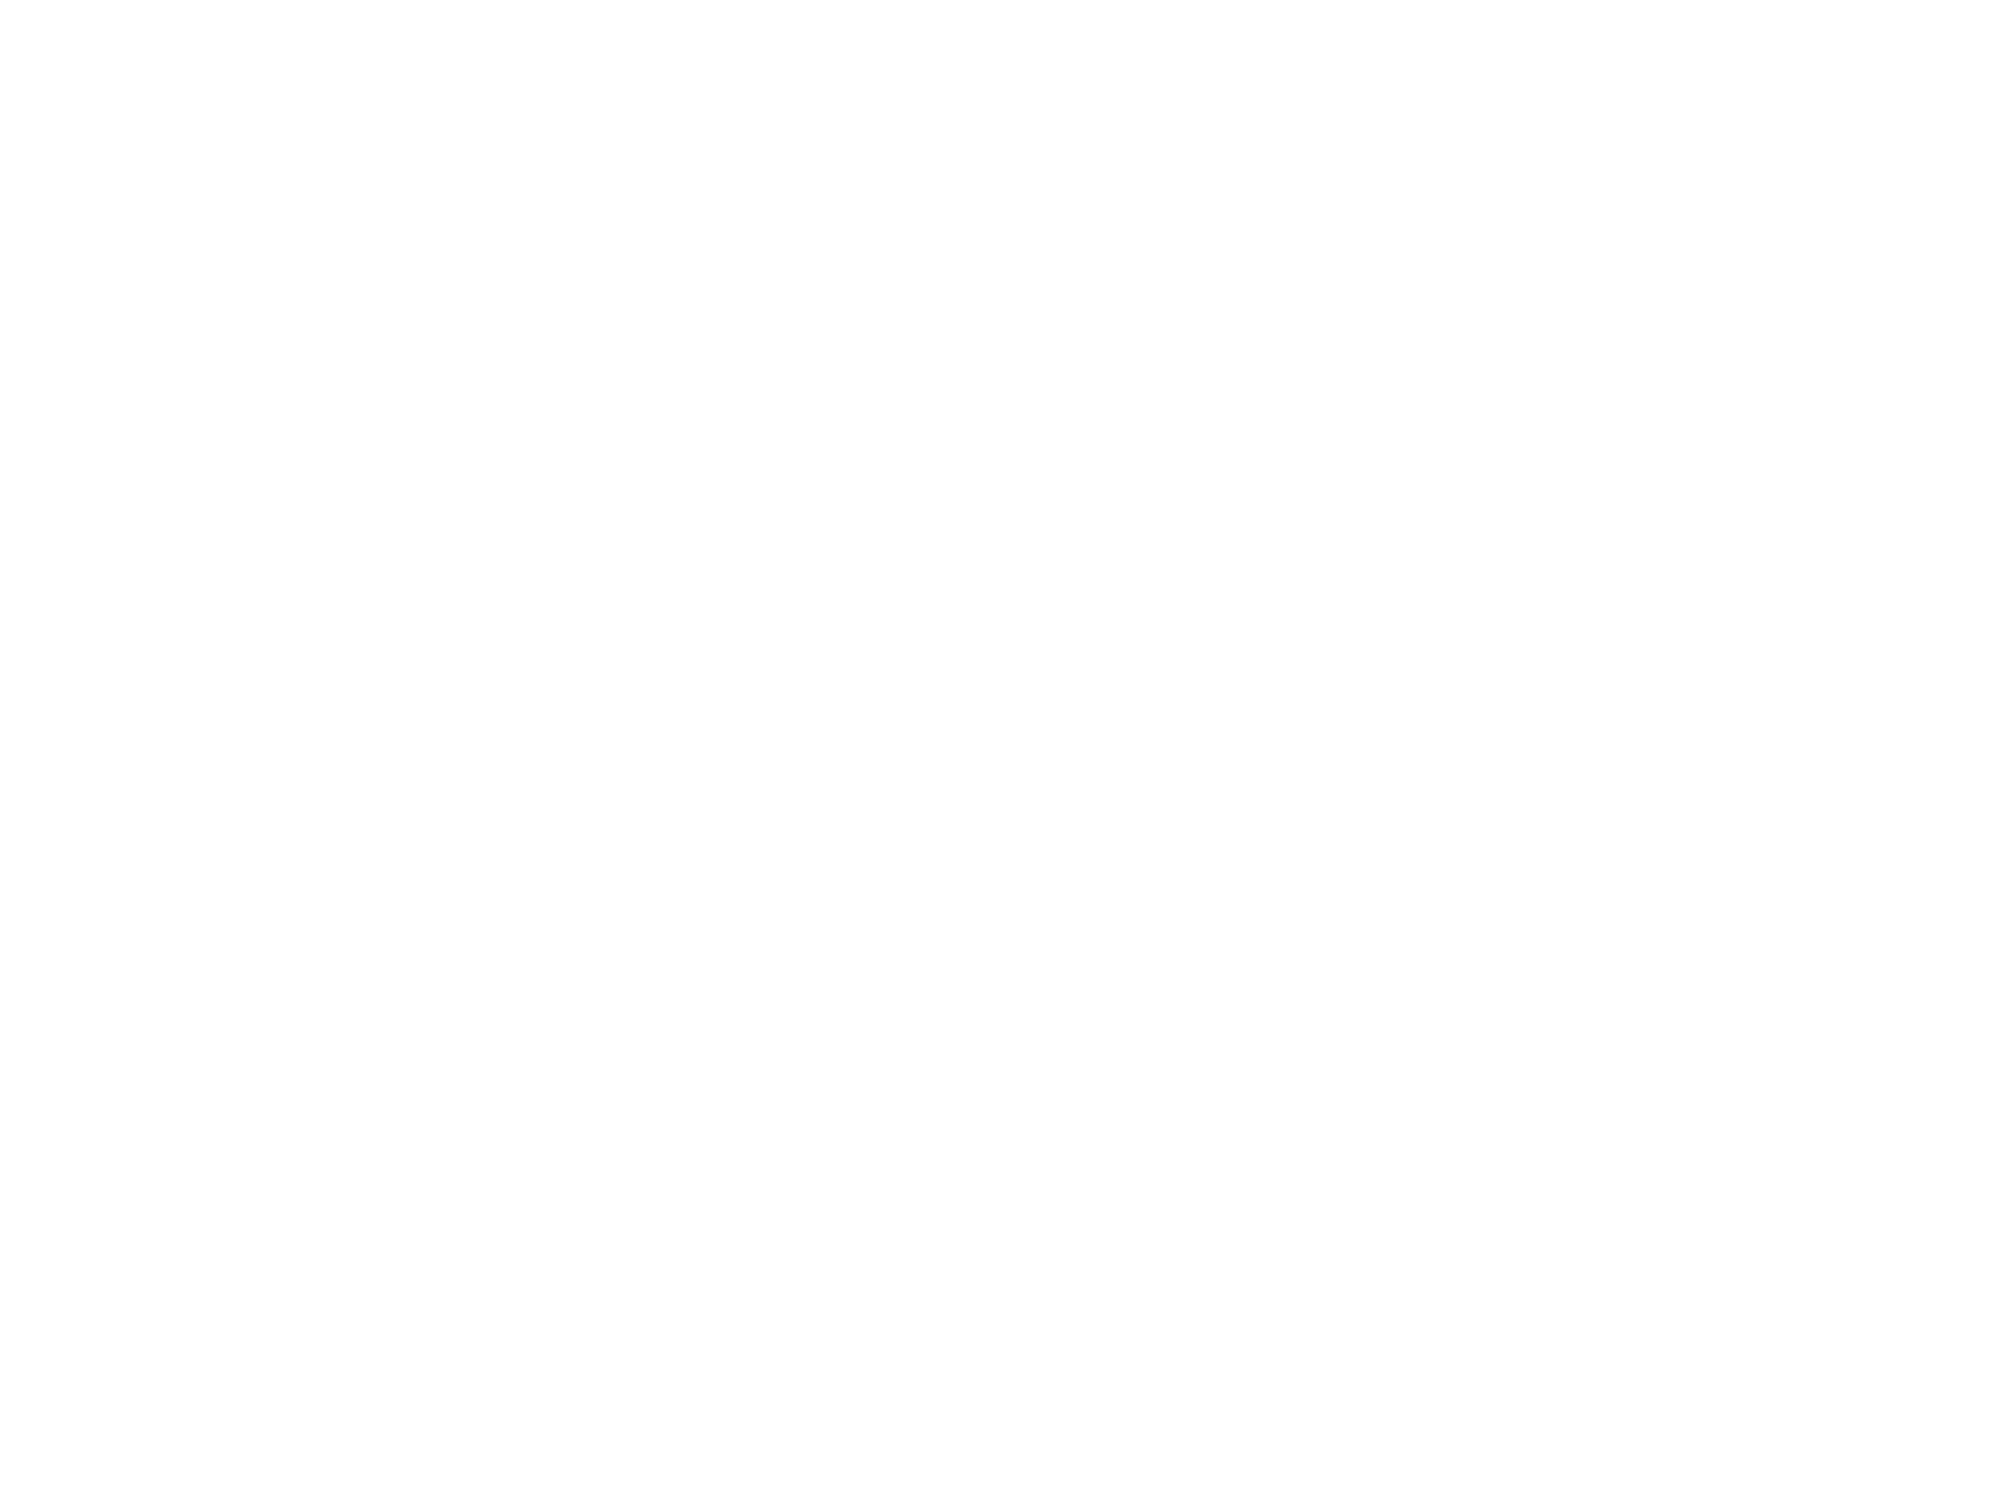

morph-tuning_Lm__JC083_20190517_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_111-of-133rois
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 289.08
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 143 of 160 responsive cells.
N rois to plot: 143
(12, 12)


<IPython.core.display.Javascript object>


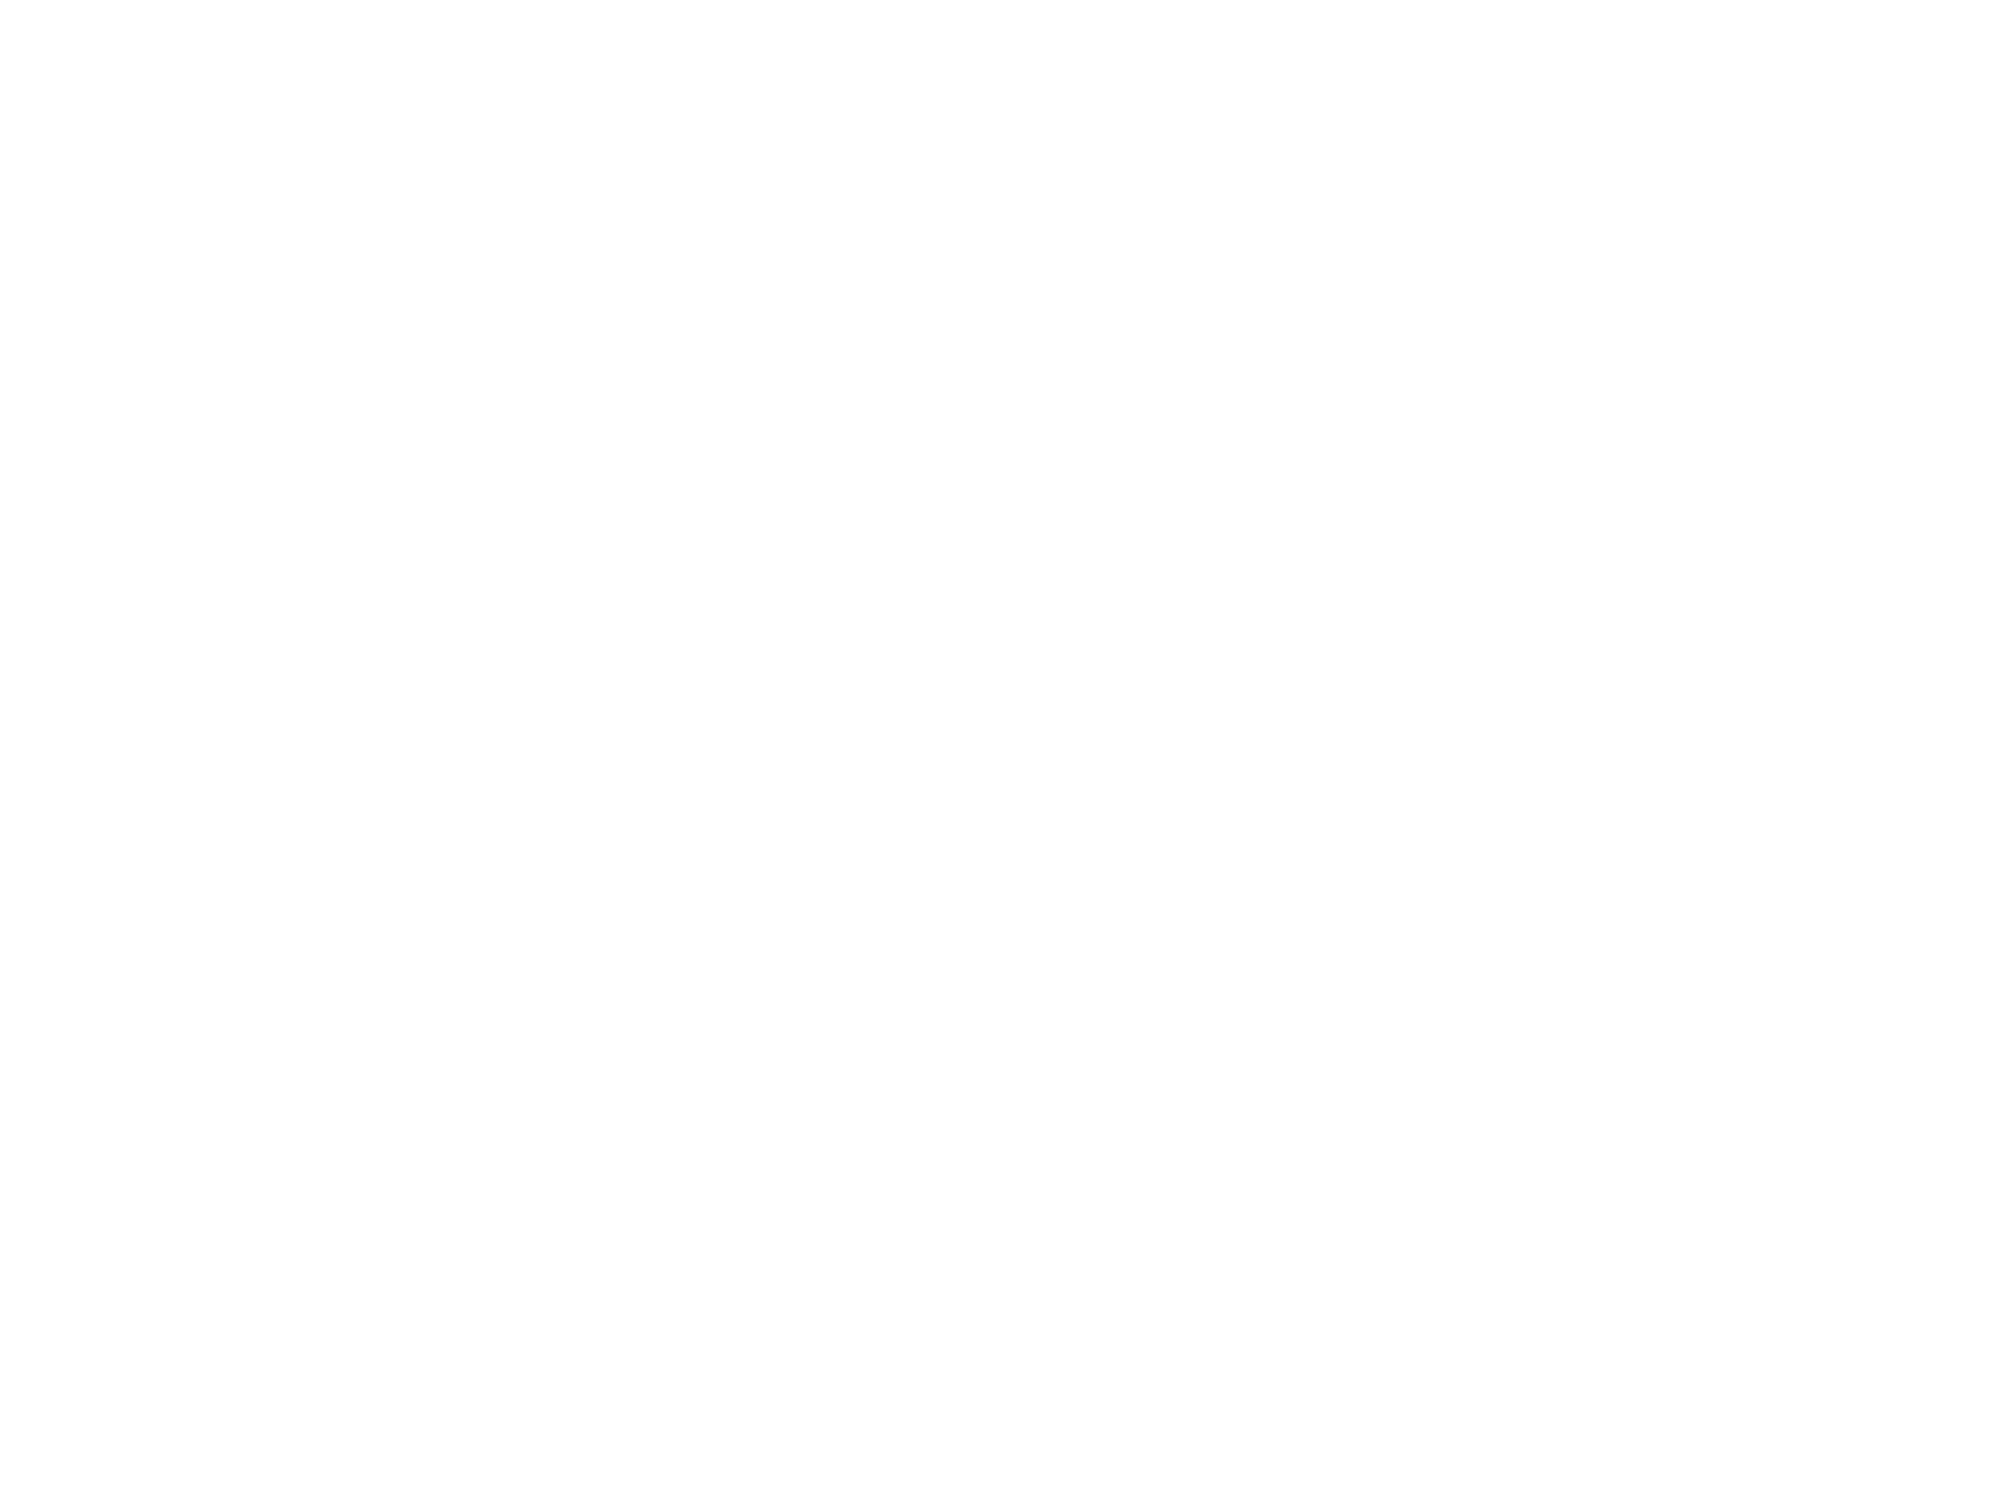

morph-tuning_Lm__JC084_20190525_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_143-of-160rois
... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 363.42
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 170 responsive cells.
N rois to plot: 155
(12, 13)


<IPython.core.display.Javascript object>


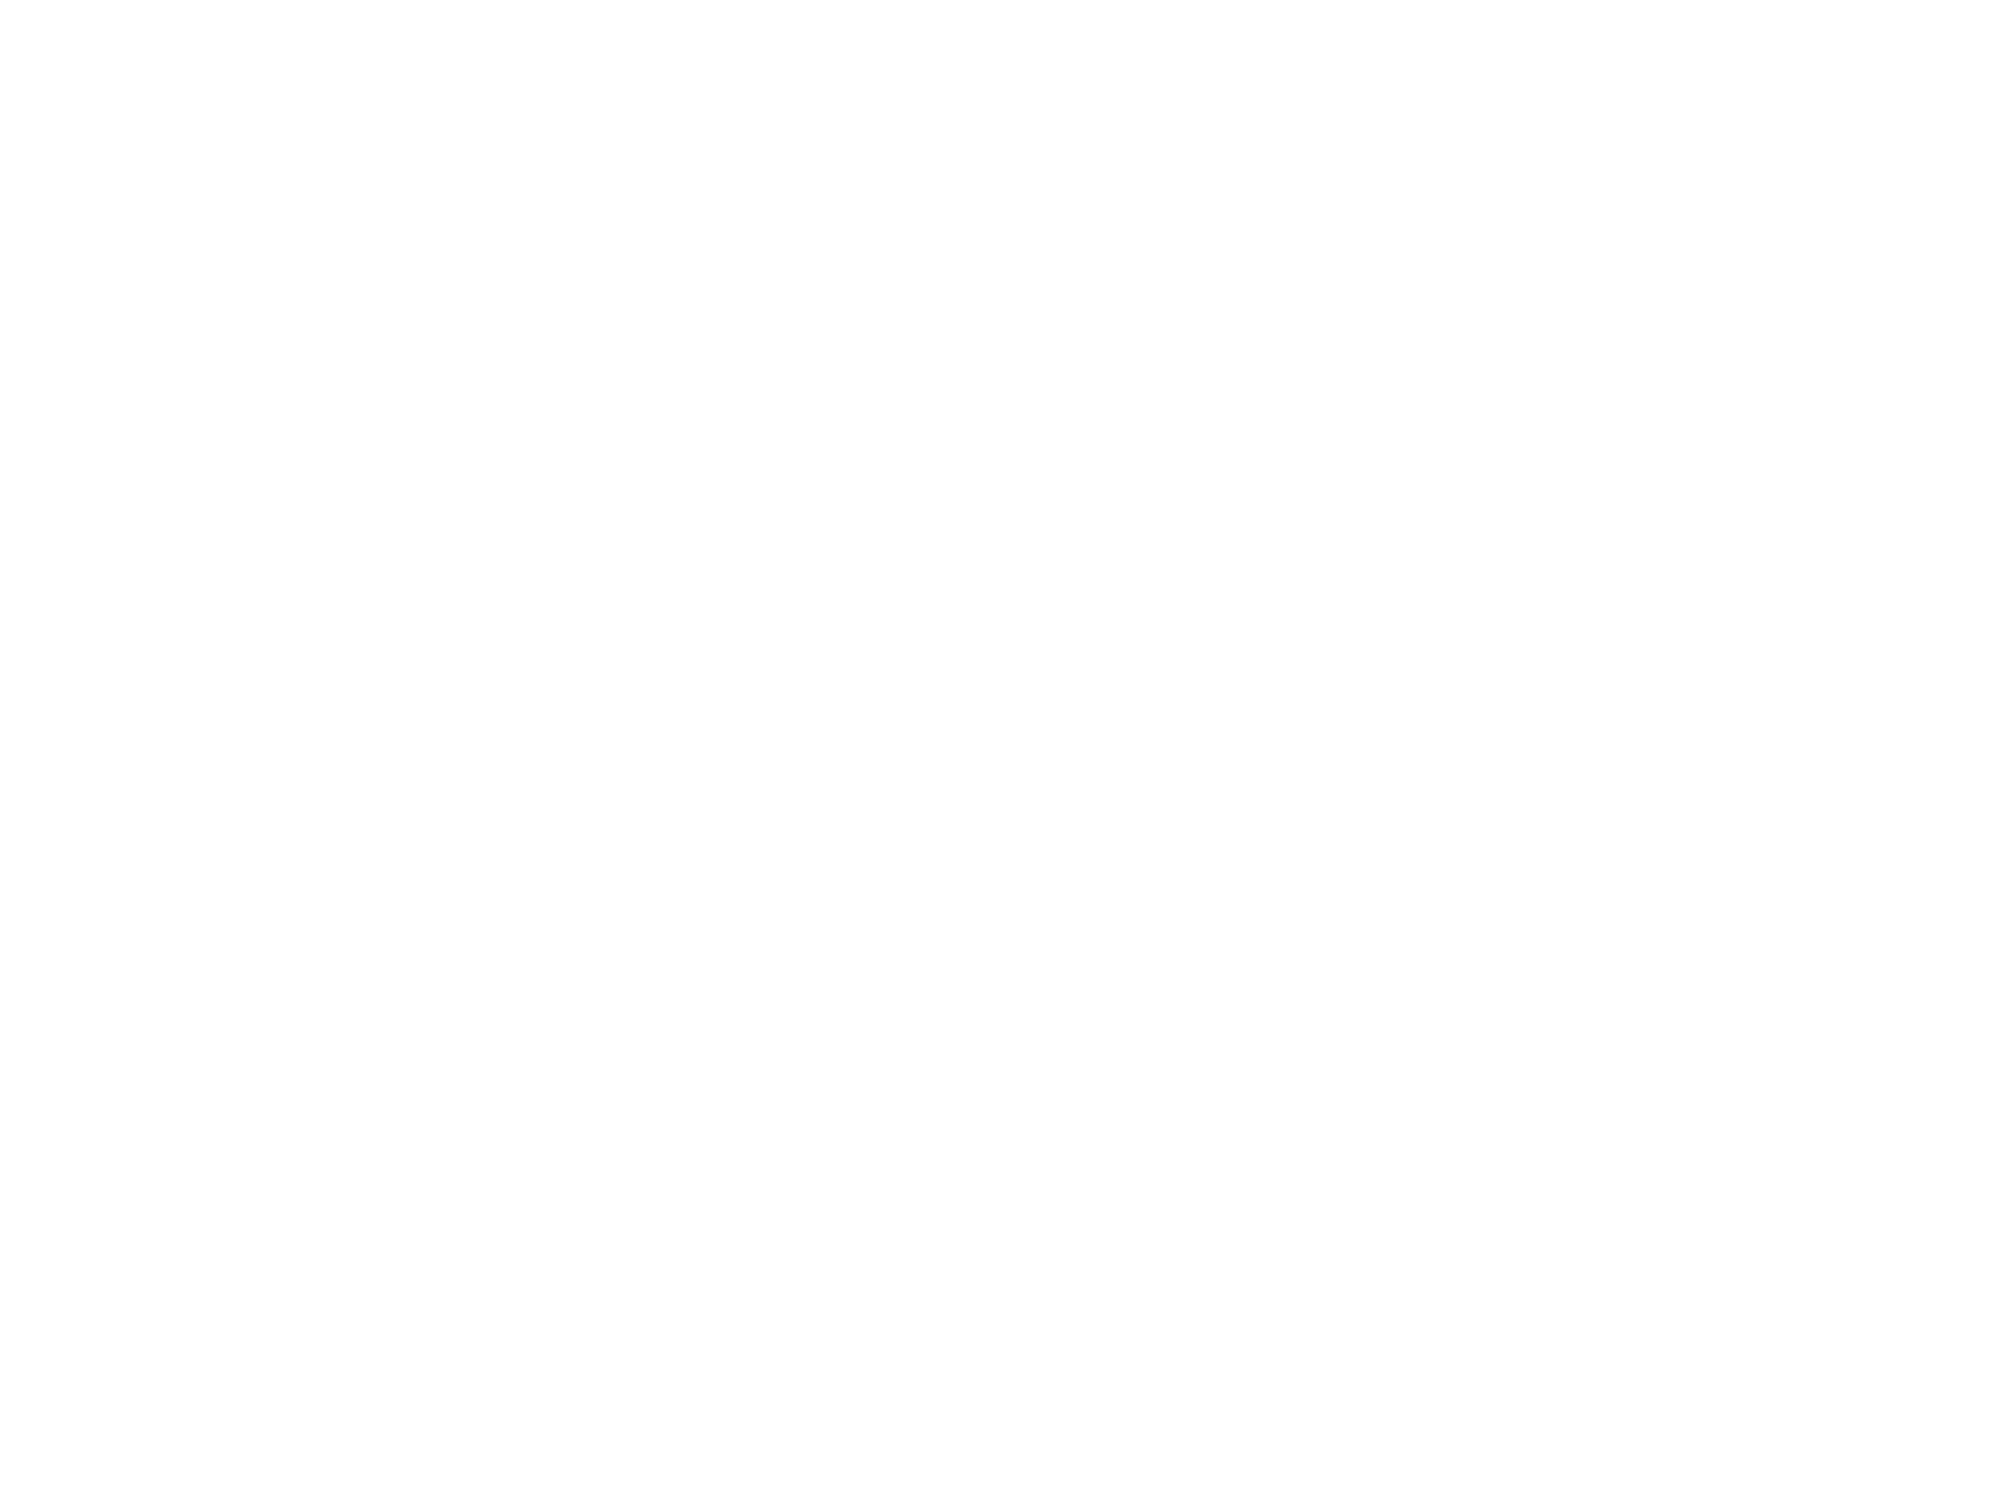

morph-tuning_Lm__JC091_20190627_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_155-of-170rois
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 253.29
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 175 responsive cells.
N rois to plot: 138
(12, 12)


<IPython.core.display.Javascript object>


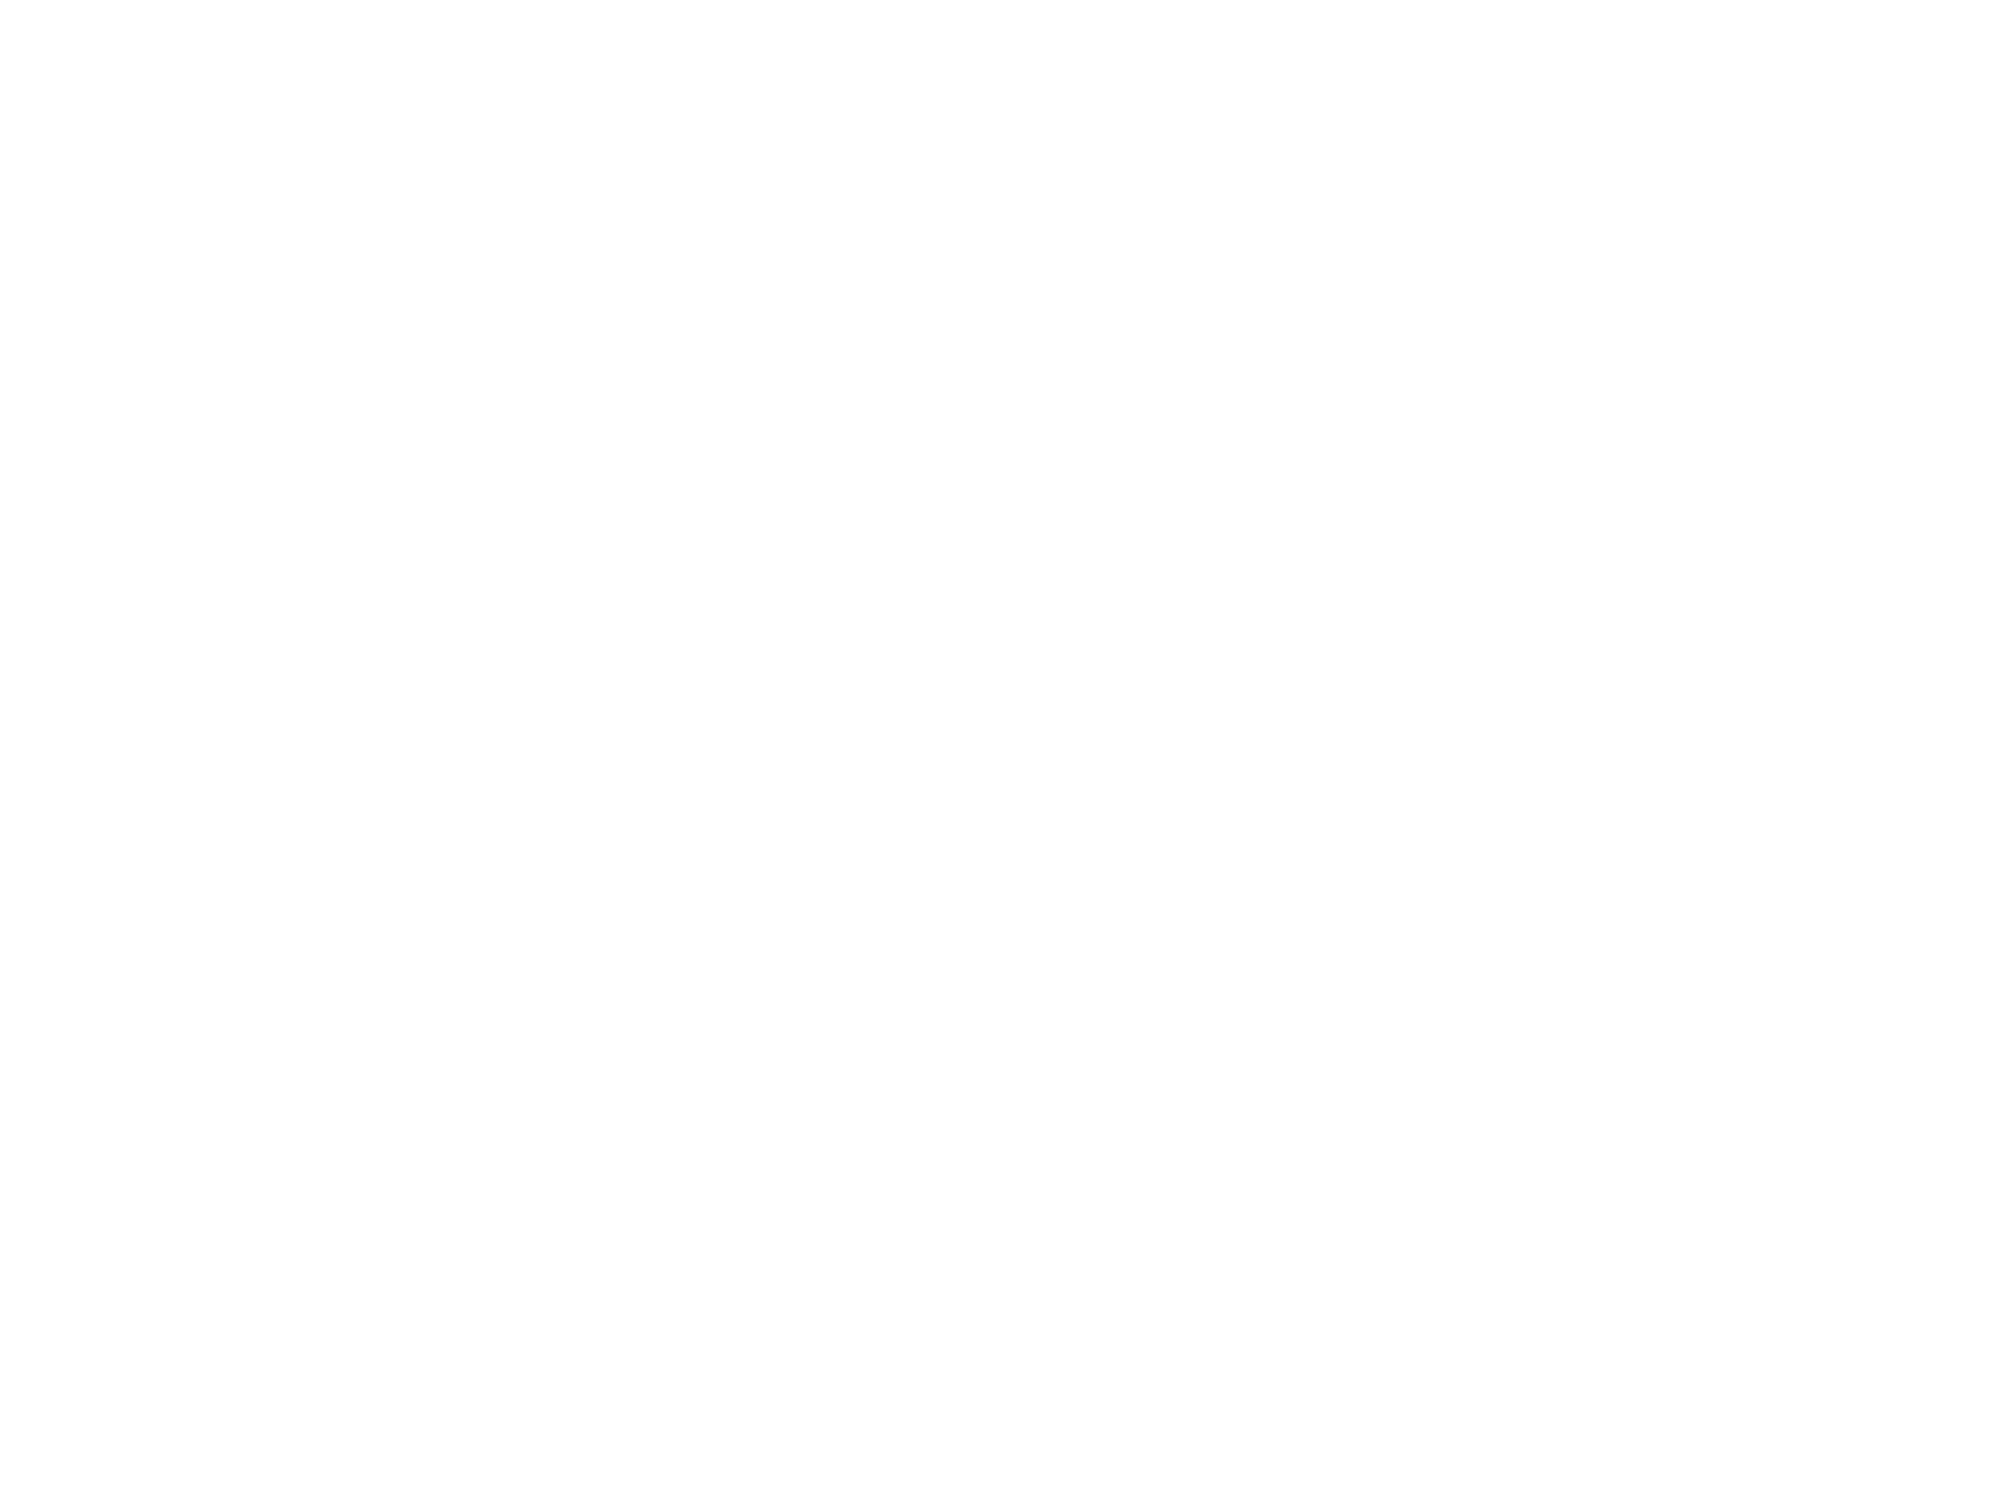

morph-tuning_V1__JC076_20190420_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_138-of-175rois
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 285.69
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 156 of 189 responsive cells.
N rois to plot: 156
(12, 13)


<IPython.core.display.Javascript object>


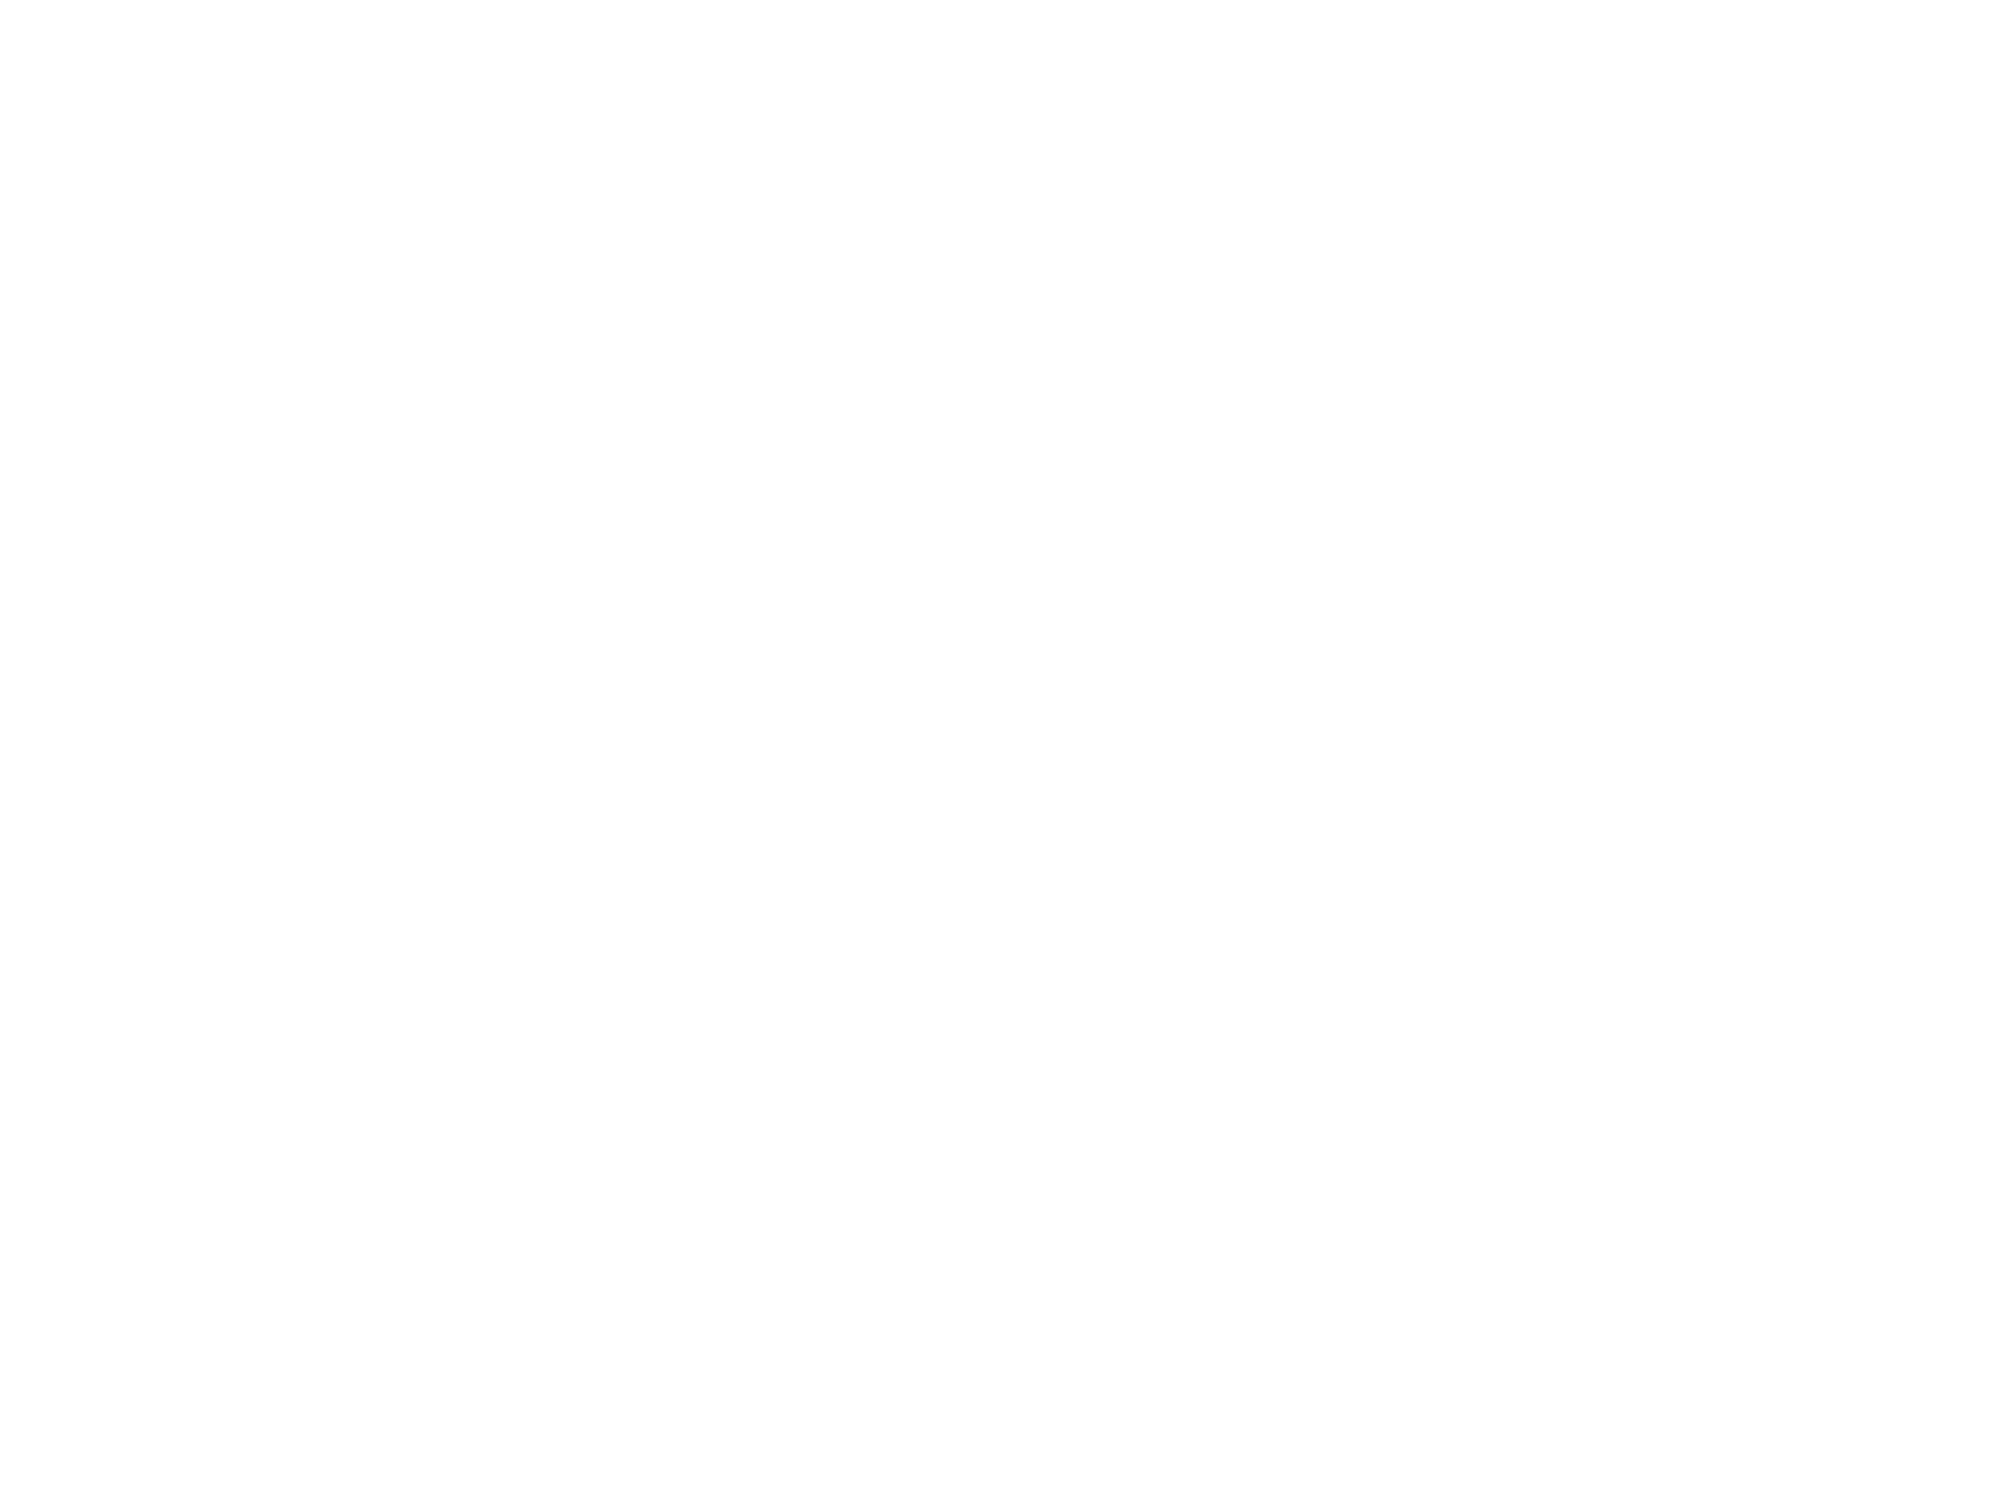

morph-tuning_V1__JC076_20190501_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_156-of-189rois
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 297.28
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 119 of 132 responsive cells.
N rois to plot: 119
(11, 11)


<IPython.core.display.Javascript object>


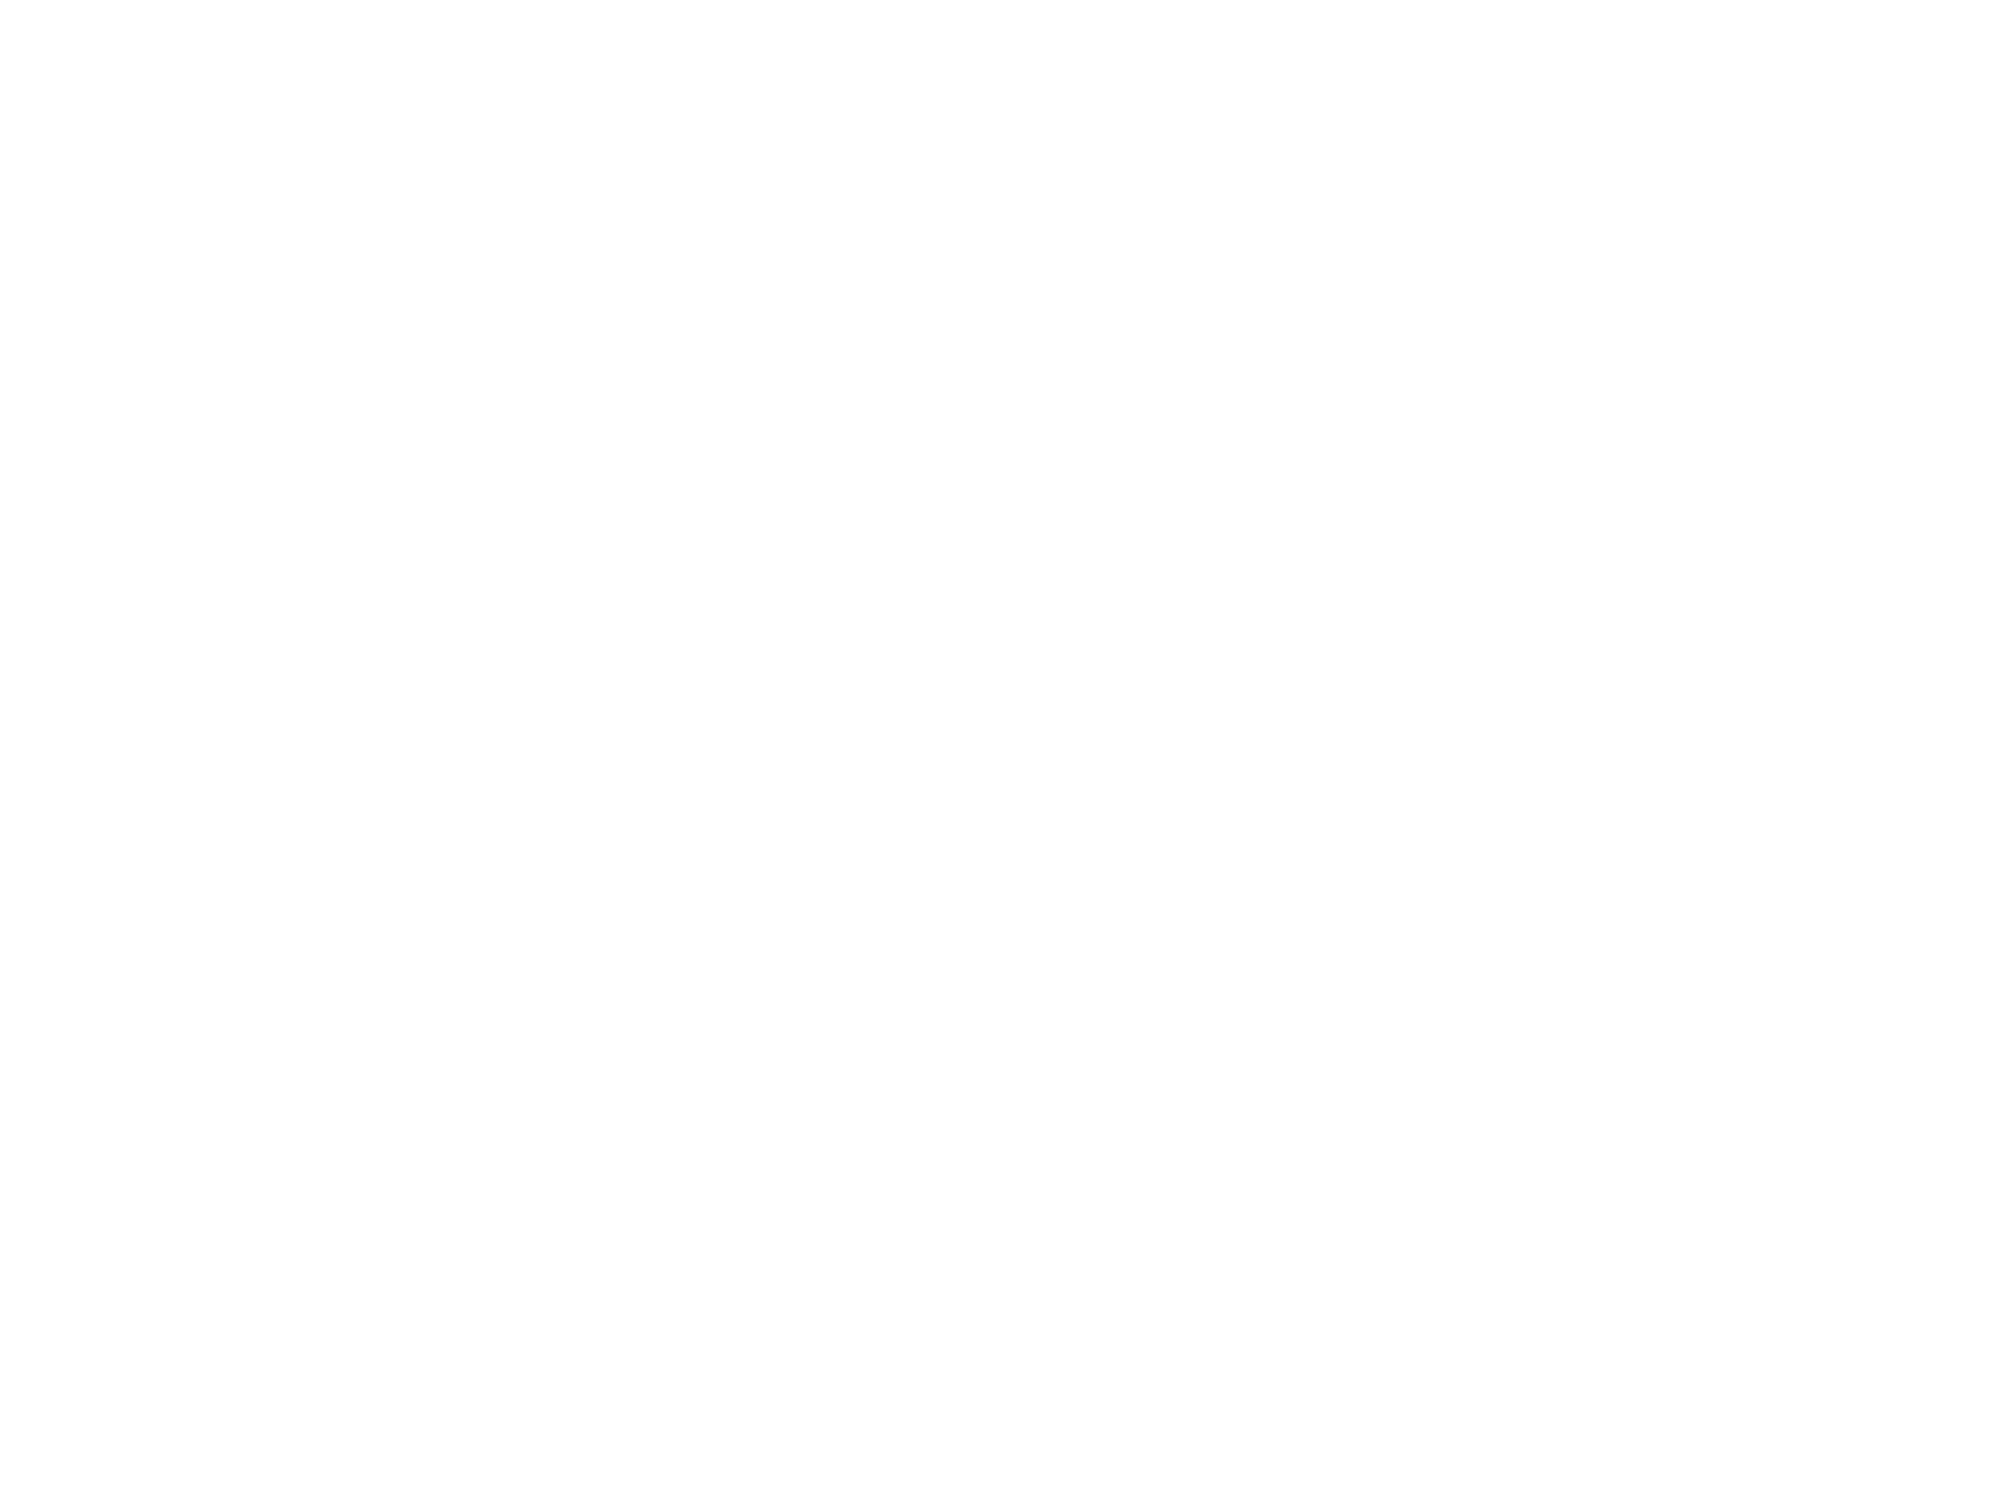

morph-tuning_V1__JC083_20190507_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_119-of-132rois
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 310.52
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 100 of 121 responsive cells.
N rois to plot: 100
(10, 10)


<IPython.core.display.Javascript object>


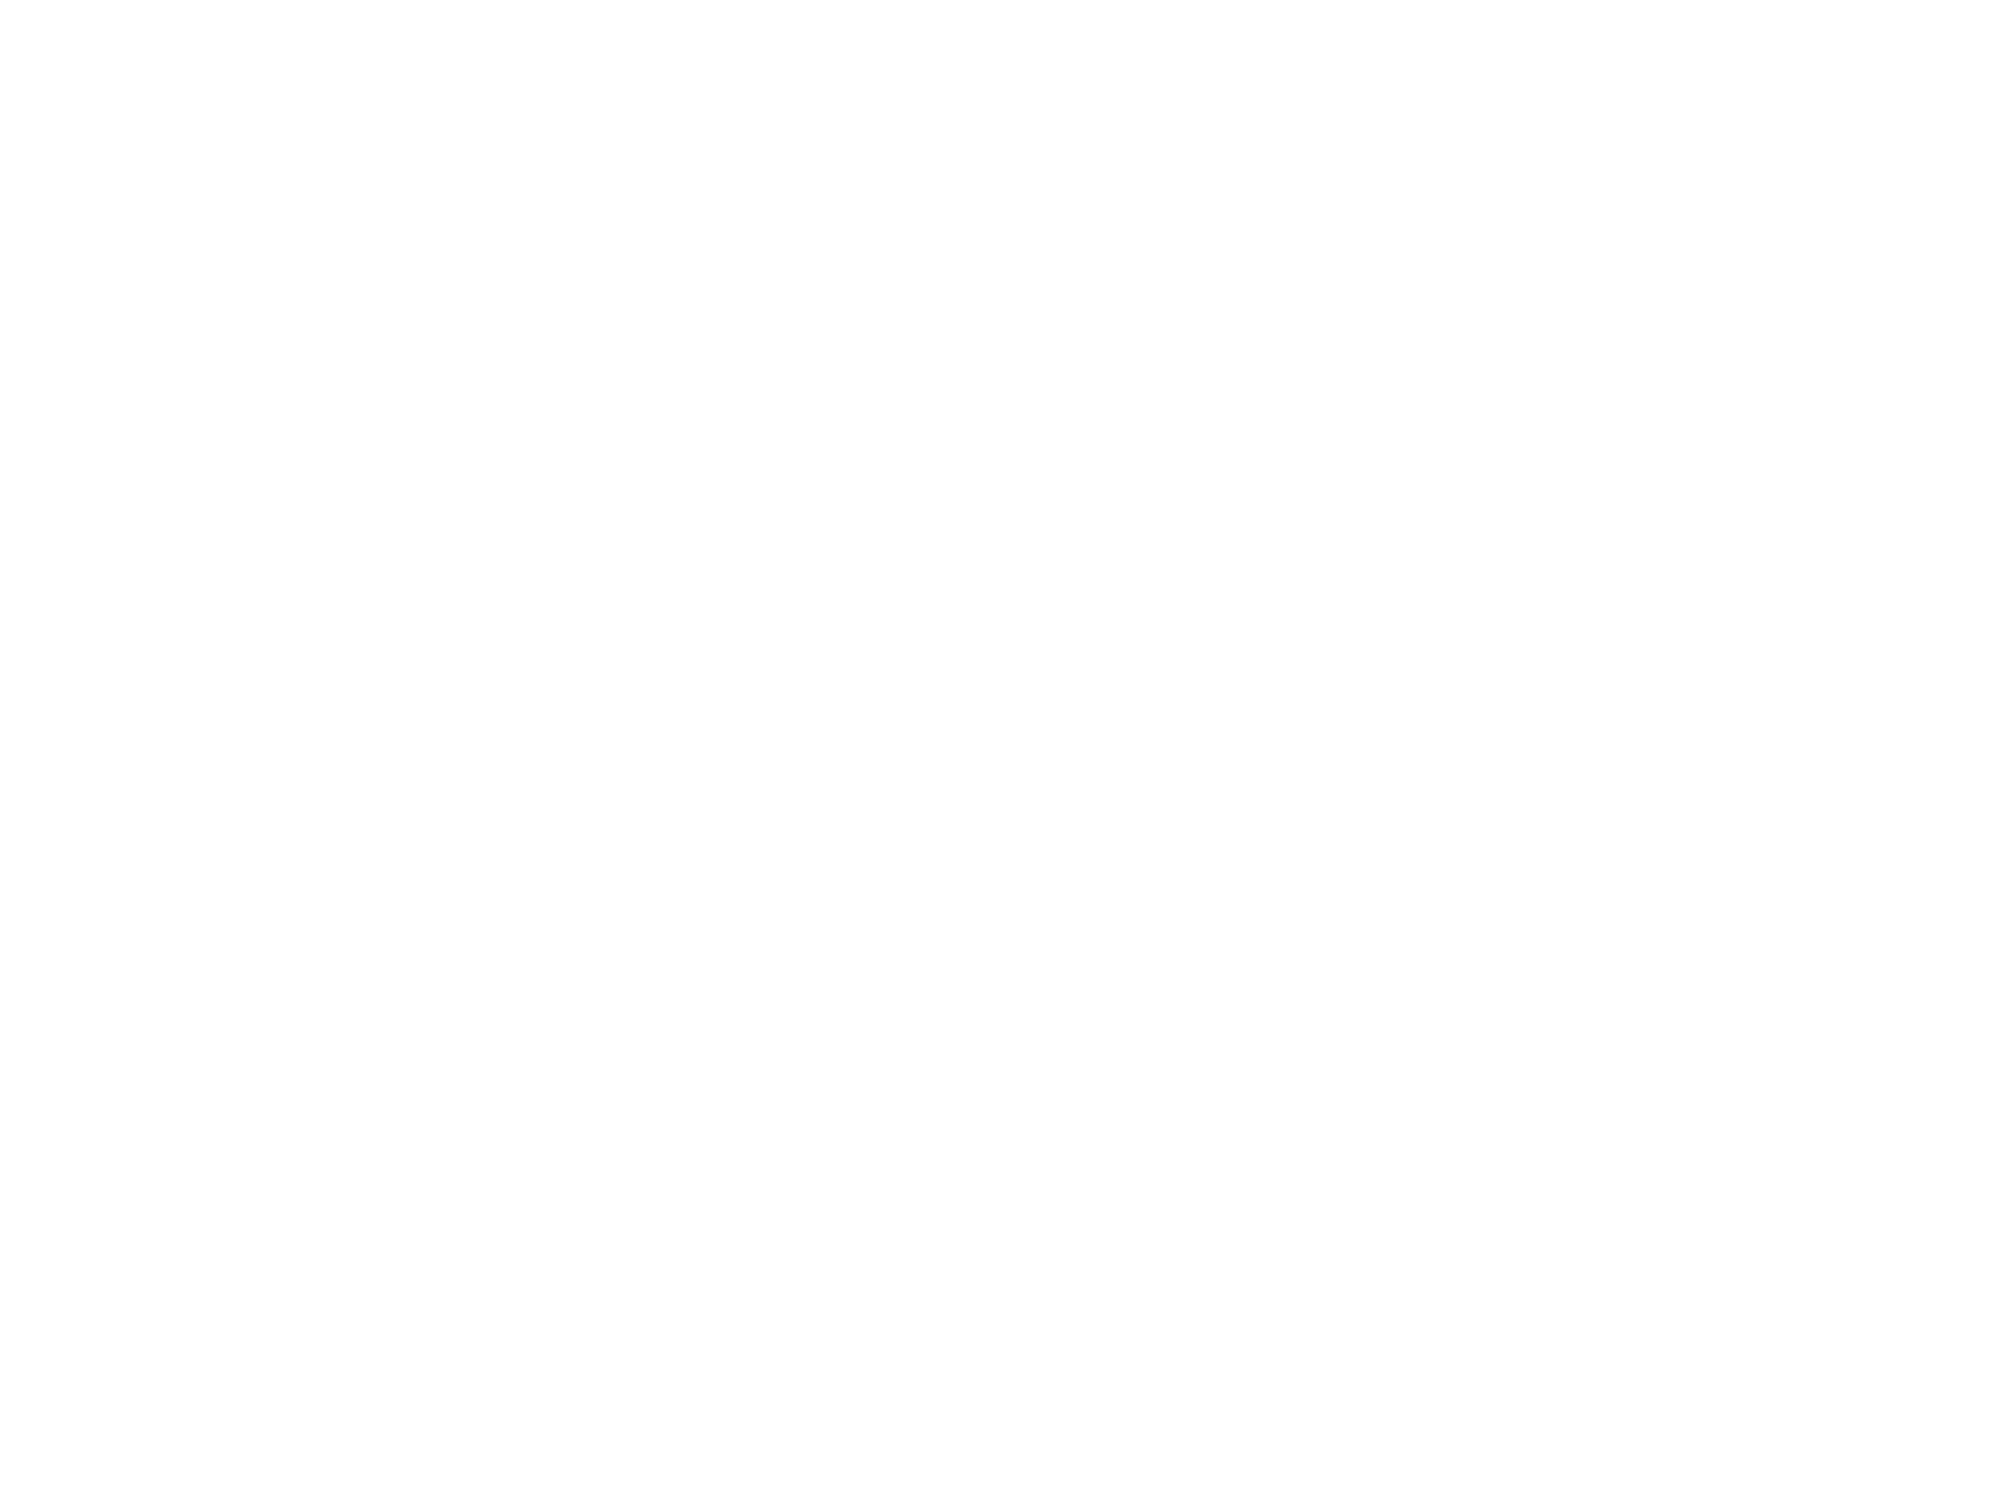

morph-tuning_V1__JC083_20190510_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_100-of-121rois
... [JC083|20190511|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 327.49
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 120 of 126 responsive cells.
N rois to plot: 120
(11, 11)


<IPython.core.display.Javascript object>


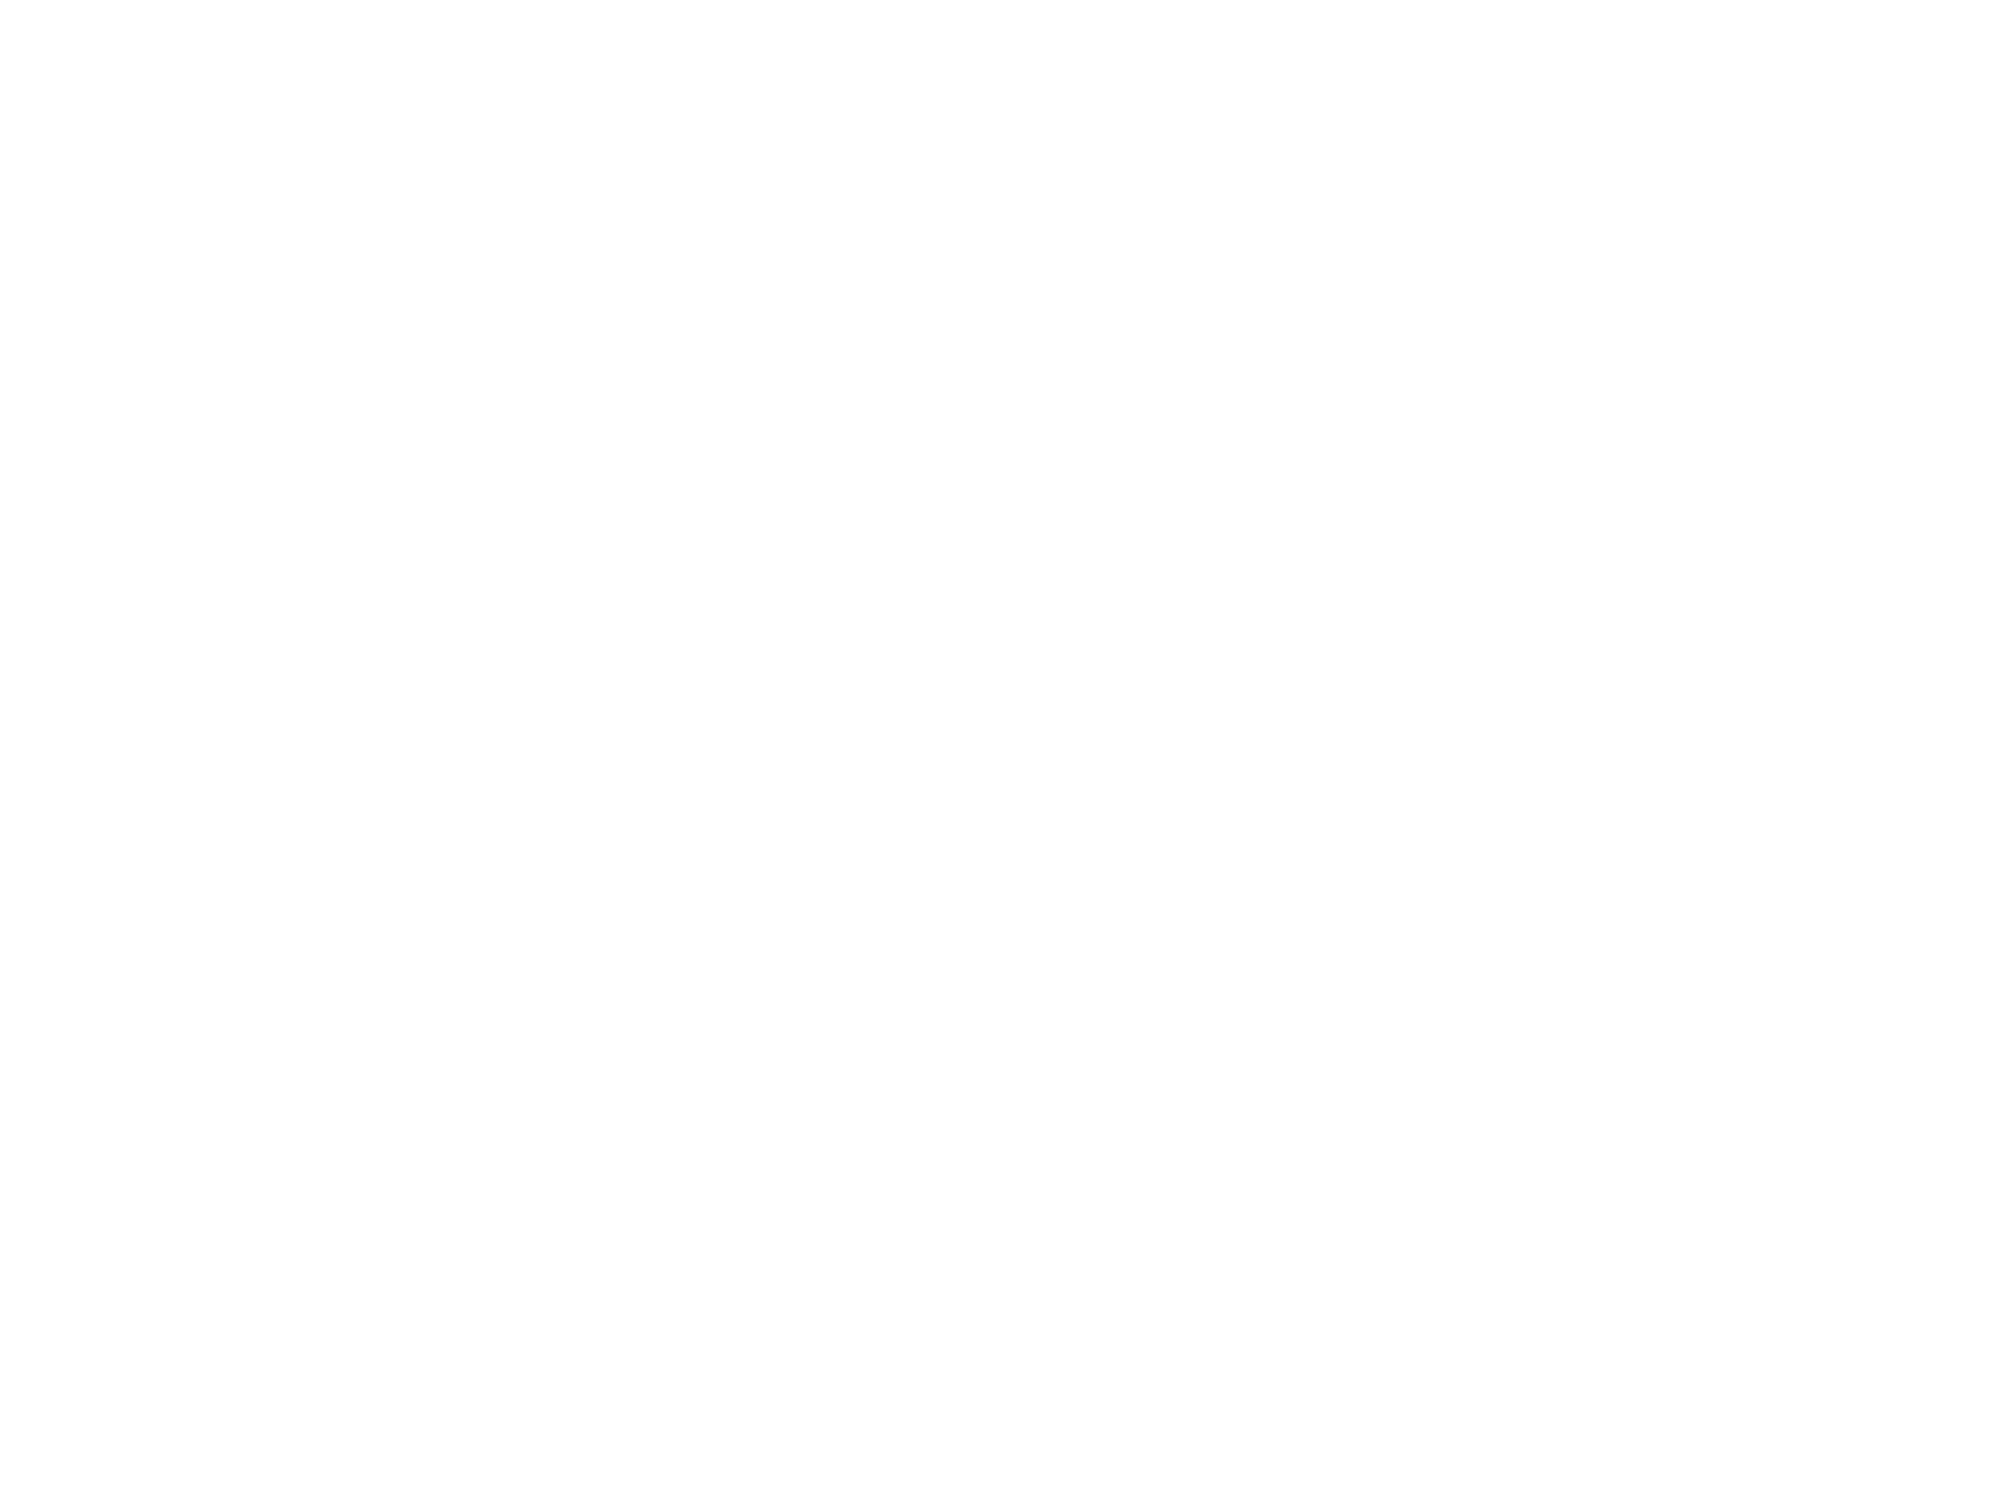

morph-tuning_V1__JC083_20190511_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_120-of-126rois
... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 608.72
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 128 of 180 responsive cells.
N rois to plot: 128
(11, 12)


<IPython.core.display.Javascript object>


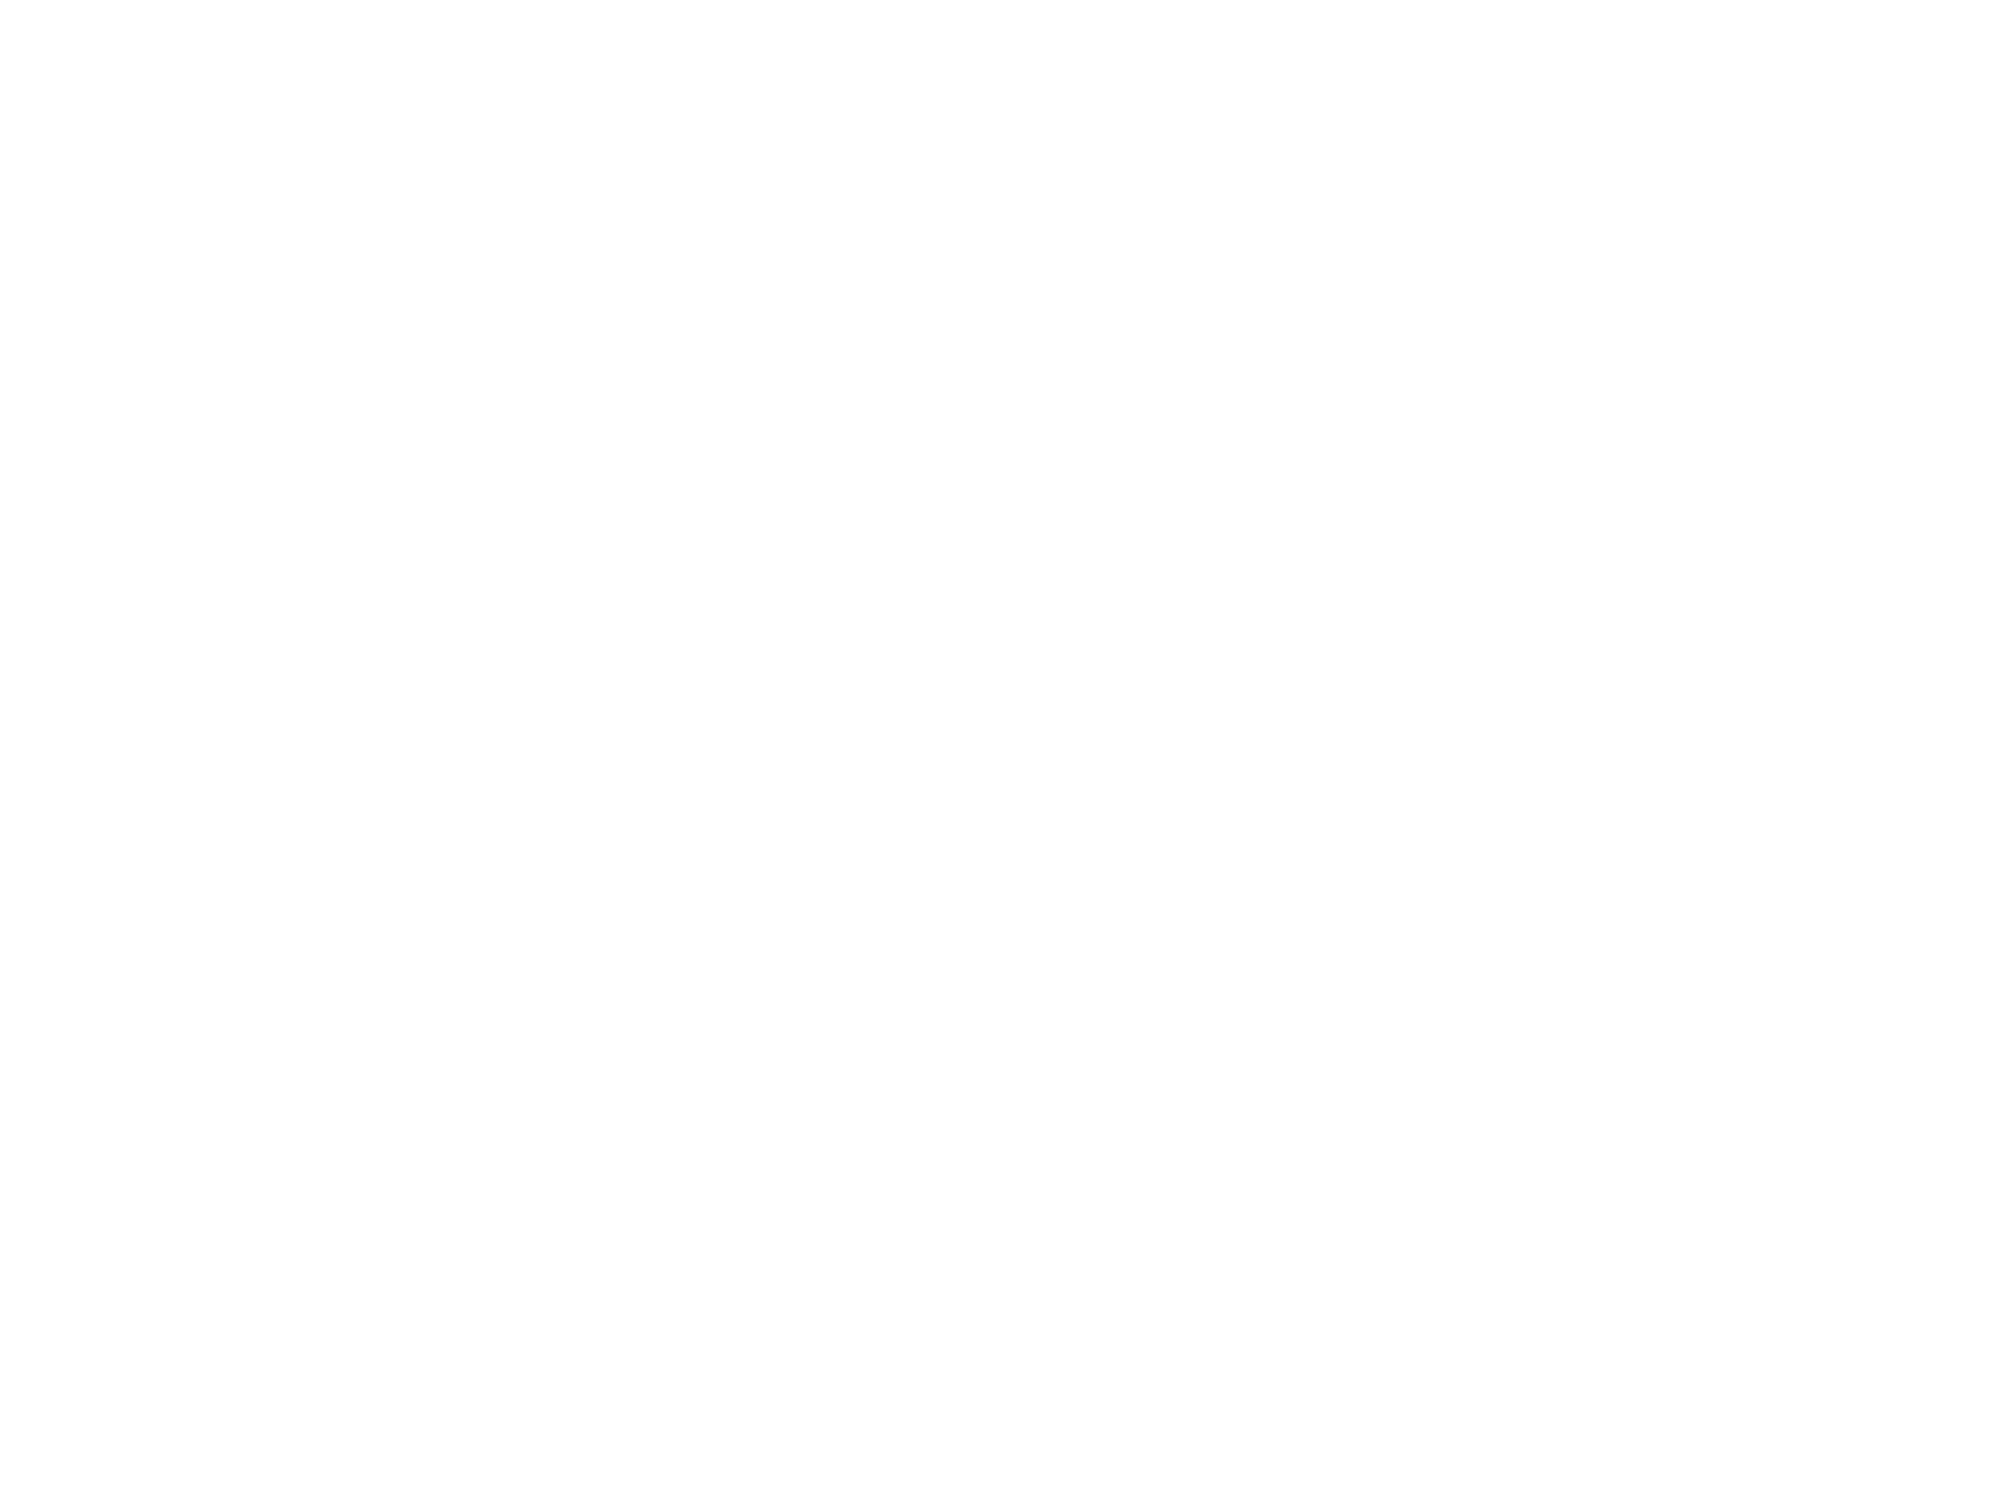

morph-tuning_V1__JC084_20190522_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_128-of-180rois
... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 370.88
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 185 of 202 responsive cells.
N rois to plot: 185
(14, 14)


<IPython.core.display.Javascript object>


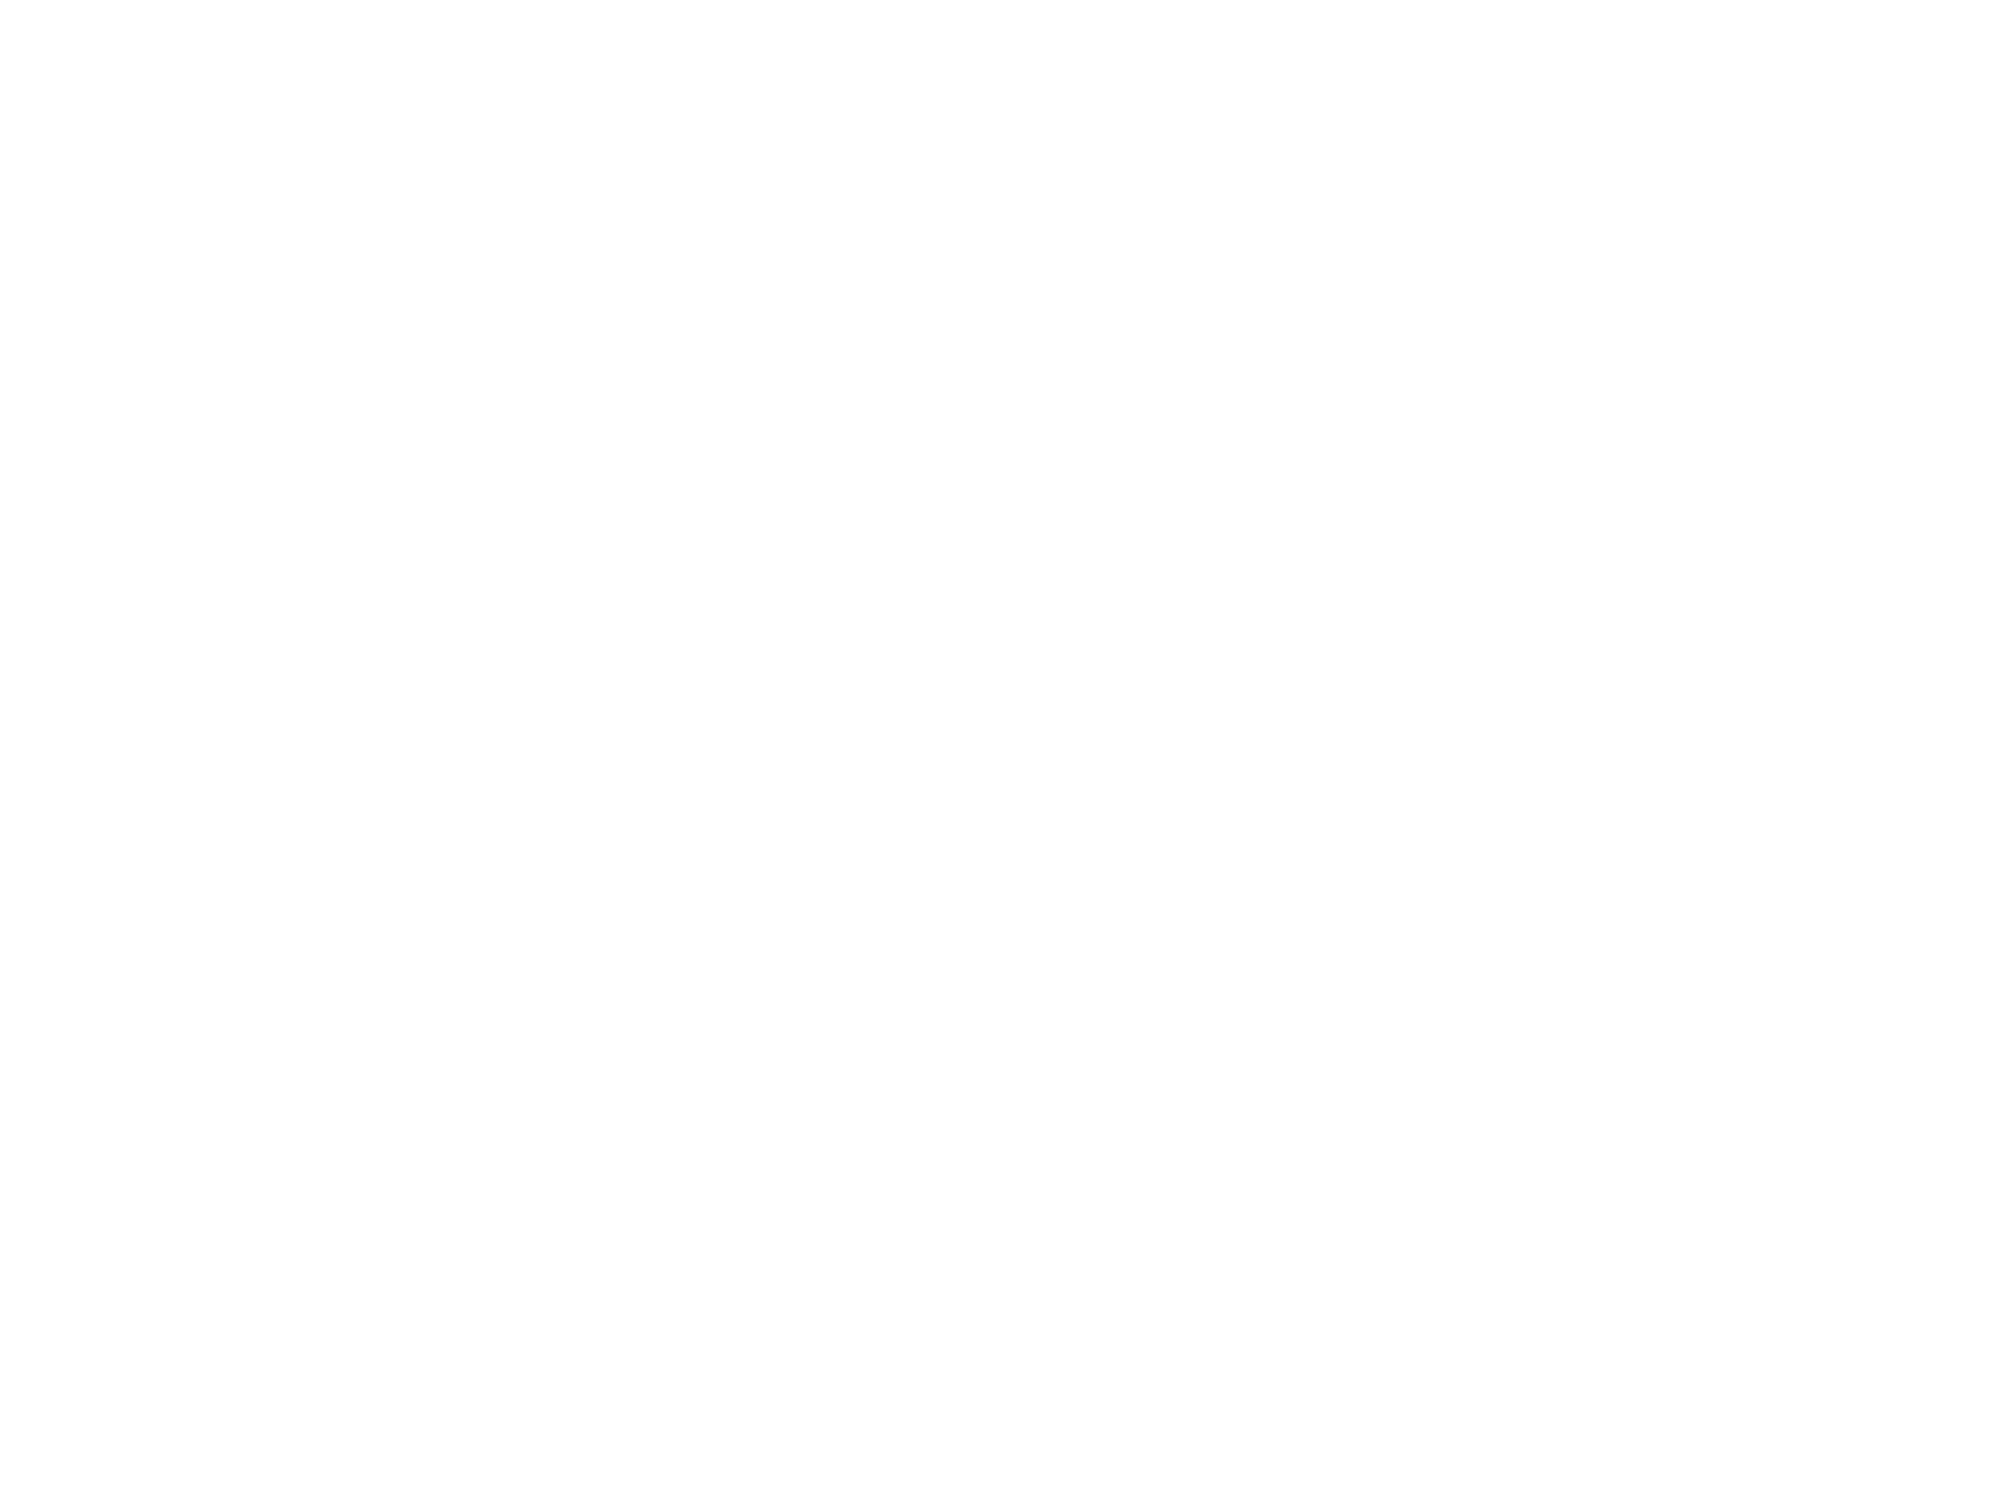

morph-tuning_V1__JC085_20190622_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_185-of-202rois
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 634.92
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 125 of 166 responsive cells.
N rois to plot: 125
(11, 12)


<IPython.core.display.Javascript object>


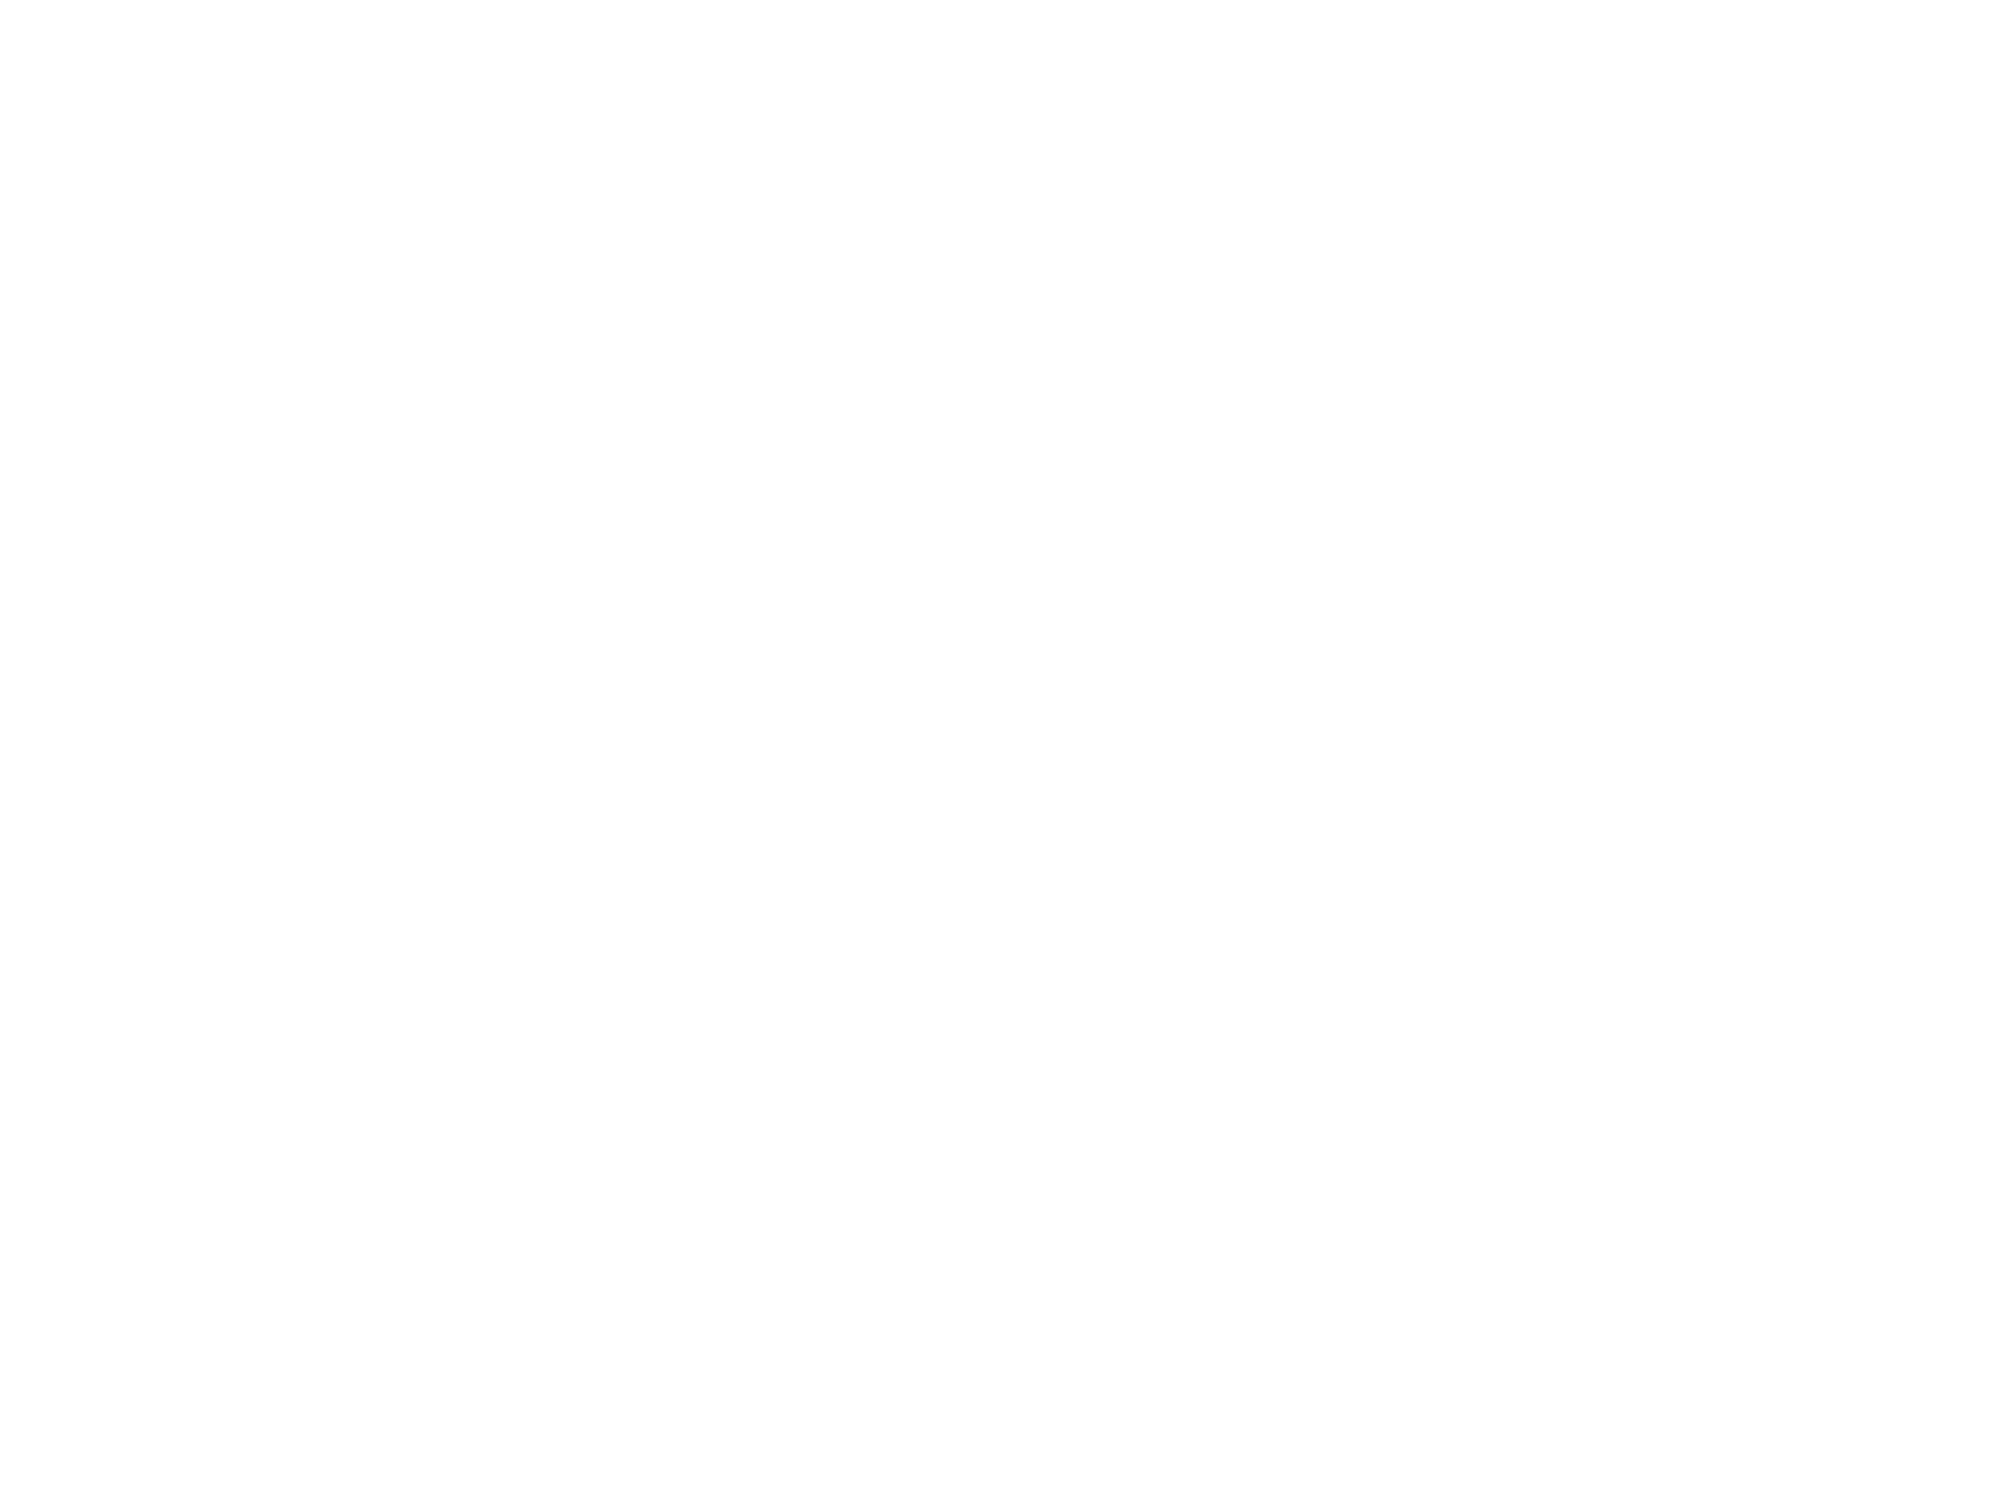

morph-tuning_V1__JC097_20190613_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_125-of-166rois
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 692.01
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 237 of 298 responsive cells.
N rois to plot: 237
(15, 16)


<IPython.core.display.Javascript object>


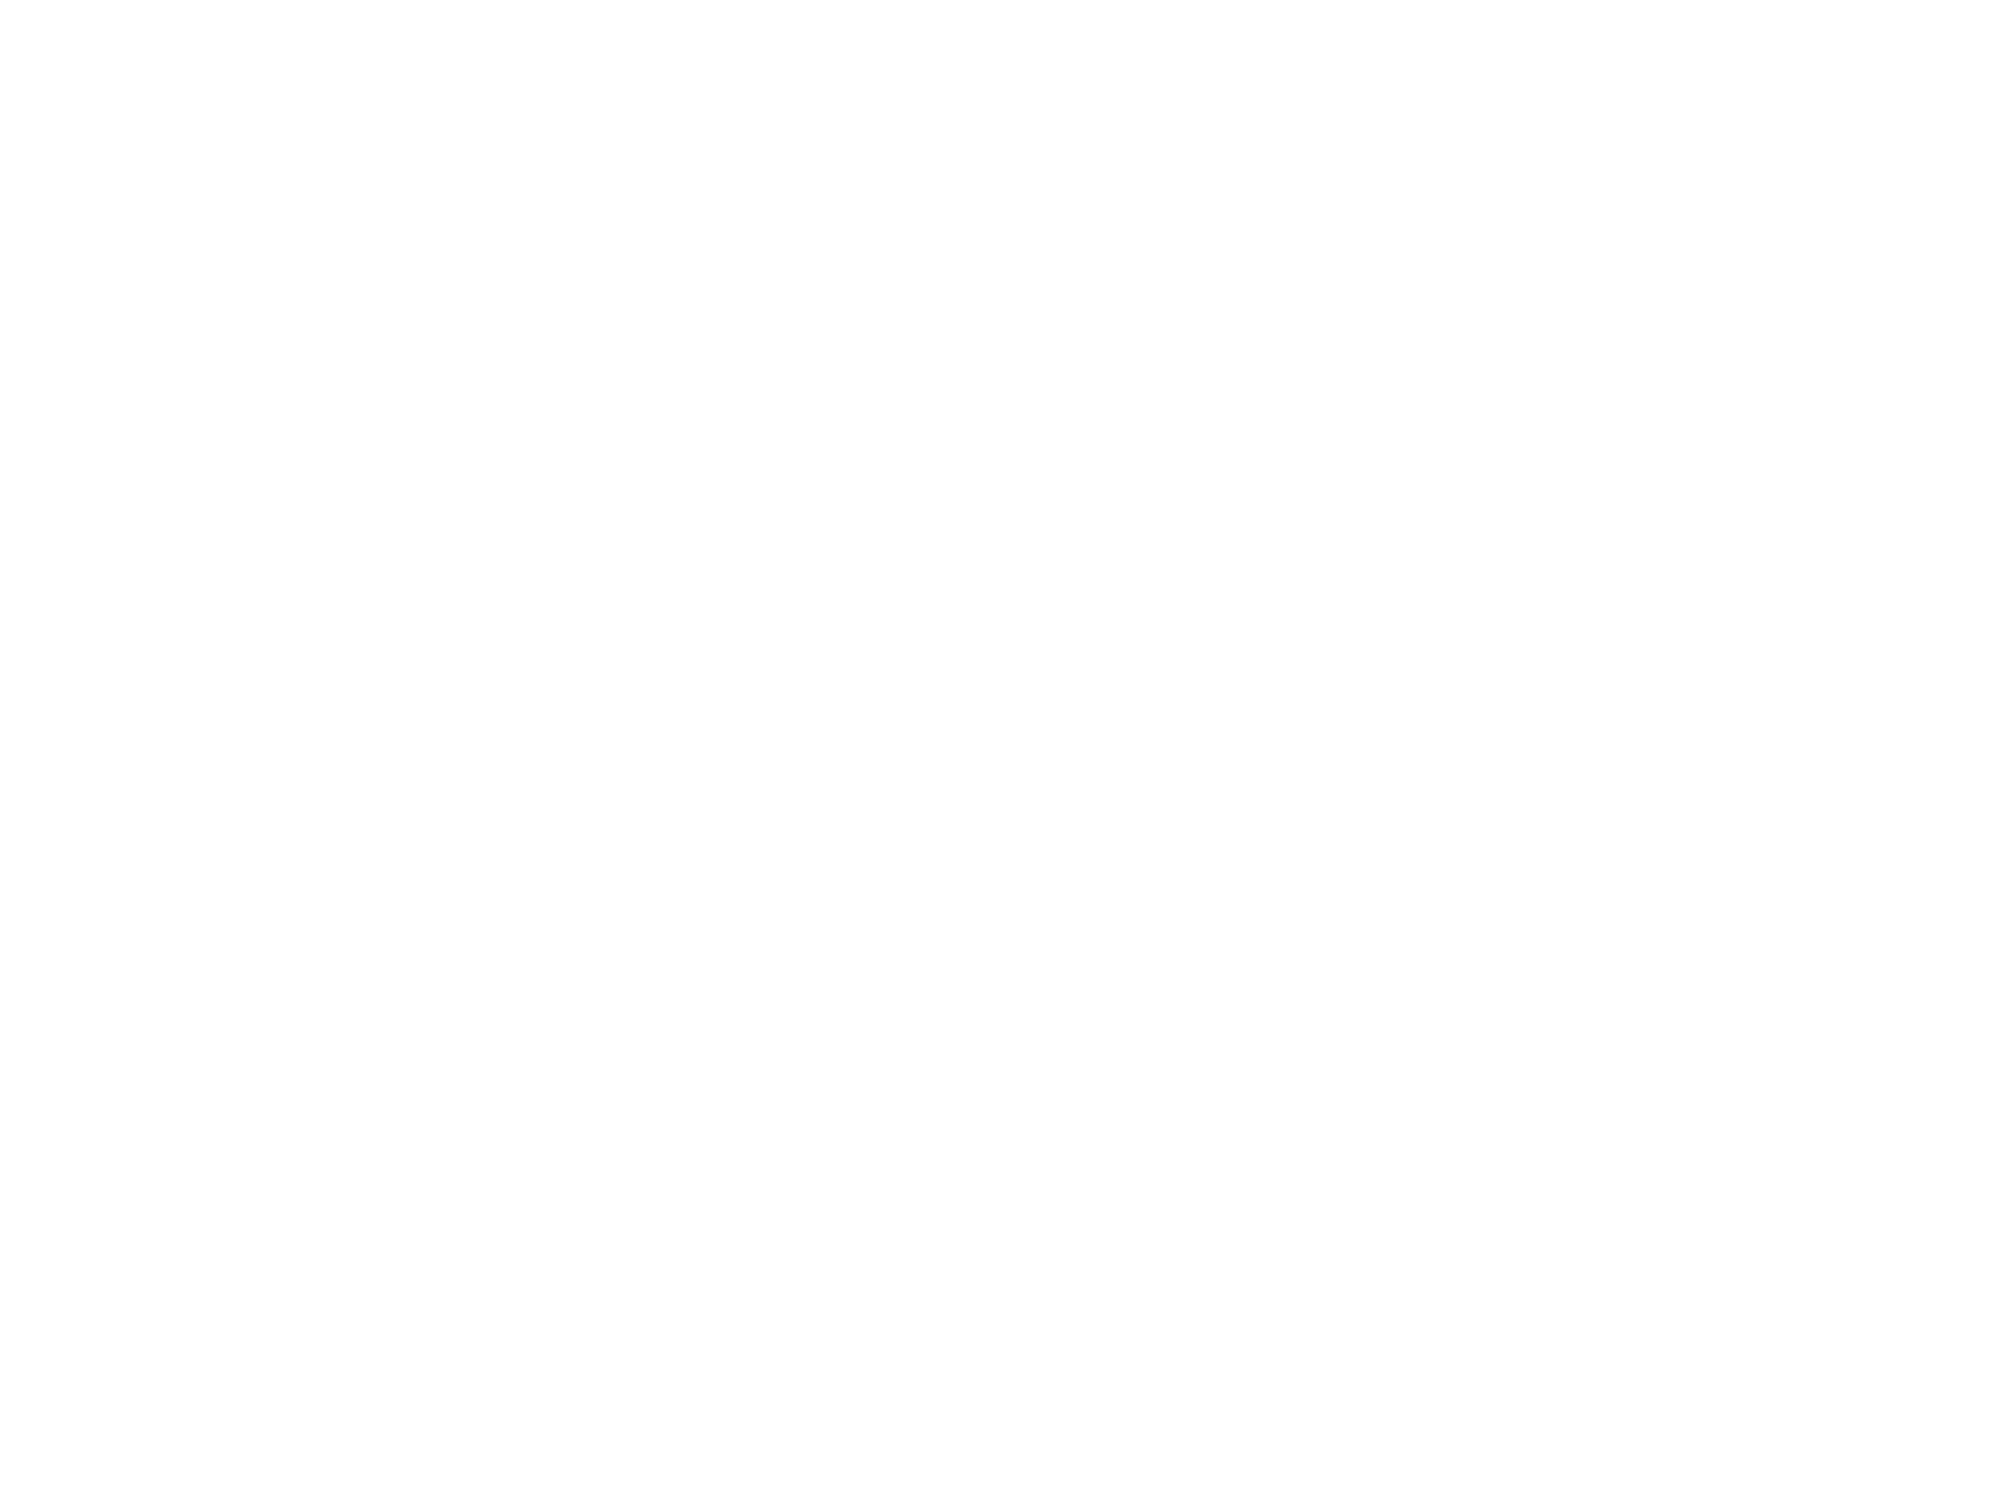

morph-tuning_V1__JC097_20190616_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_237-of-298rois
... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 617.18
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 231 of 276 responsive cells.
N rois to plot: 231
(15, 16)


<IPython.core.display.Javascript object>


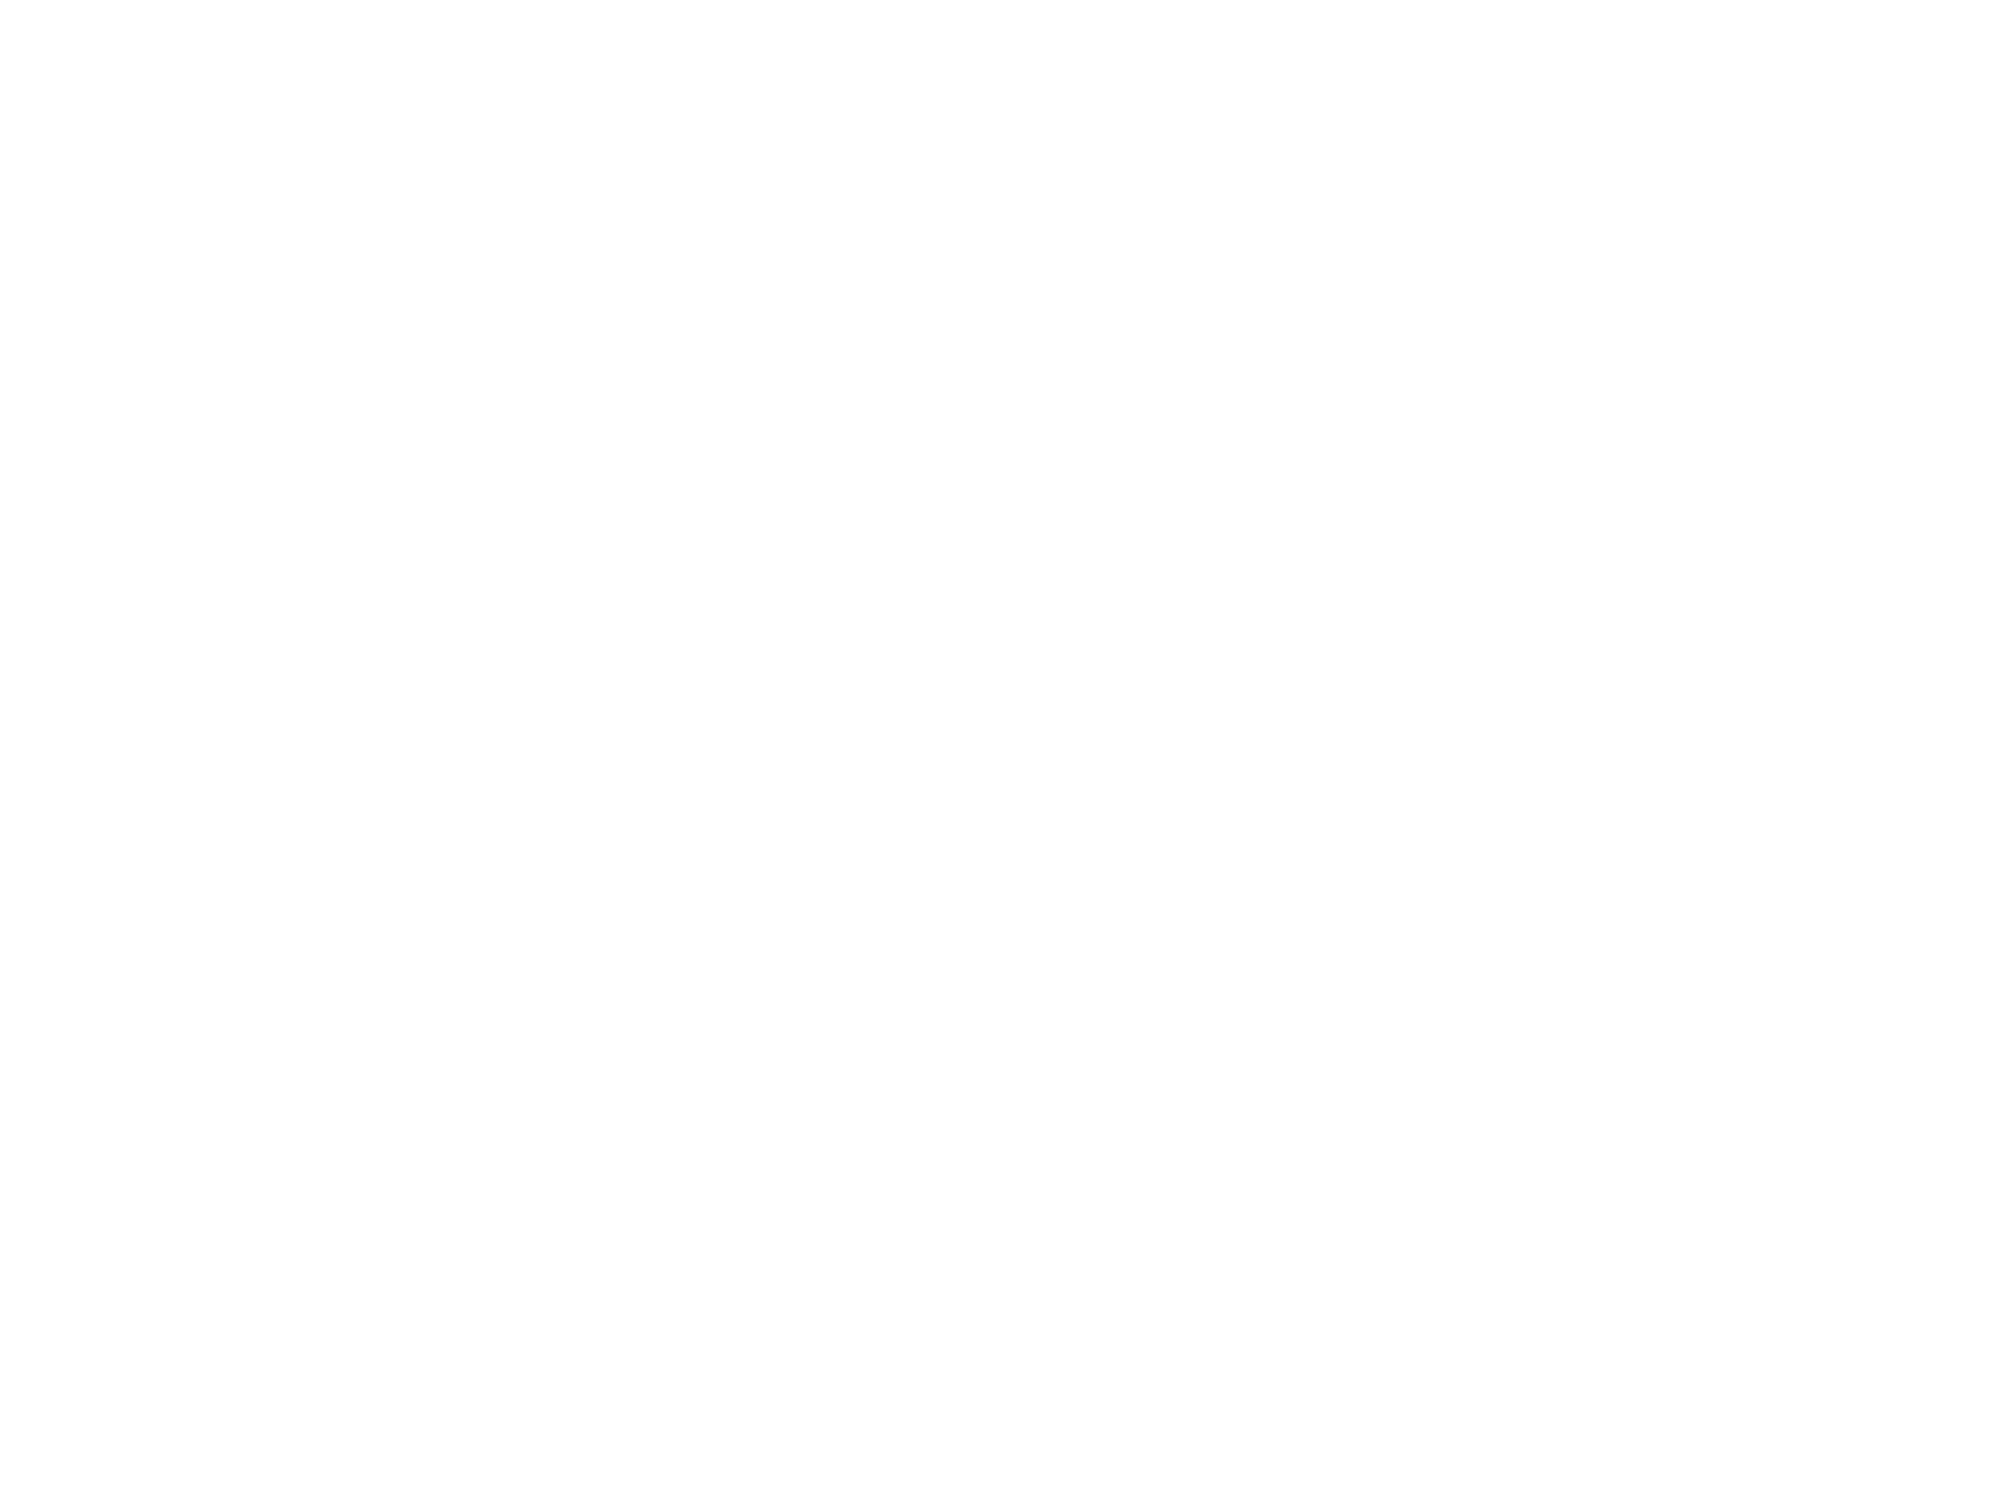

morph-tuning_V1__JC097_20190617_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_231-of-276rois


In [62]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

    skey = '-'.join([visual_area, animalid, session, fov])
    
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    sizes = np.array(sorted(sdf['size'].unique()))
    morphs = np.array(sorted(sdf['morphlevel'].unique()))

    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        continue
        
    figexists = len(glob.glob(os.path.join(outdir, 'sessions', 'morph-tuning_%s__%s*.png' % (visual_area, data_id.replace('|', '_')))))
    
    if figexists:
        continue
    

    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']
    

    # Get metrics for each condition
    estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
    meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T
    assert len(np.where(np.isnan(meanr))[0])==0
    semr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).sem()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T
    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
    print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

    df_mean = meanr.loc[rois_plot]
    df_sem = semr.loc[rois_plot]

    hue_name = 'size' if tune_name=='morph' else 'morph'
    tune_values = morphs.copy() if tune_name=='morph' else sizes.copy()
    hue_values = sizes.copy() if tune_name=='morph' else morphs.copy()
    hcolors = sns.color_palette('gray_r', n_colors=n_sz) if tune_name=='morph' else sns.color_palette('gray_r', n_colors=n_mp) 


    fig = plot_roi_tuning(df_mean, df_sem=df_sem, tune_values=tune_values, tune_name=tune_name,
                         hue_values=hue_values, hue_name=hue_name, hue_colors=hcolors)
    if threshold_dff:
        figname = '%s-tuning_%s__%s_thr-dff-%.2f_%i-of-%irois' % (tune_name, visual_area, data_id.replace('|', '_'), min_dff, len(rois_plot), len(estats.rois))
    else:
        figname = '%s-tuning_%s__%s_all-resp_%i-of-%irois' % (tune_namevisual_area, data_id.replace('|', '_'), len(rois_plot), len(estats.rois))

    pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
    print figname
    pl.close()
    
    del exp


# Look at counts across visual areas

In [154]:
incorrect_nconfigs = []
incorrect_nvalues = []
nresponsive = {}
ntotal = {}

In [155]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    skey = '%s-%s-%s' % (animalid, session, fov)

    sdf = exp.get_stimuli()
    if len(sdf.index.tolist()) != 50:
        incorrect_nconfigs.append(skey)
        continue

    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]
    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != nr or n_morphs != nc:
        incorrect_nvalues.append(skey)
        continue

    if visual_area not in nresponsive.keys():
        nresponsive[visual_area] = {}
        ntotal[visual_area] = {}
    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']


    ncells_arr = np.empty((nr, nc), dtype=int)
    for ri, sz in enumerate(sizes):
        for mi, mp in enumerate(morphs):
            assert sz in sdf['size'].unique(), "wrong size: %i" % sz
            assert mp in sdf['morphlevel'].unique(), "wrong morph: %i" % mp
            ax = axes[ri, mi]
            cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
            ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
            ncells_arr[ri, mi] = ncells_resp

    nresponsive[visual_area].update({skey: ncells_arr})
    ntotal[visual_area].update({skey: len(rlist)})
    
    
        

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data pa

In [157]:
print incorrect_nvalues
print incorrect_nconfigs

[]
['JC078-20190426-FOV1_zoom2p0x']


In [192]:
data_identifier = '|'.join(['blobs', fov_type, traceid, stats_desc])
print(data_identifier)

blobs|zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00


<IPython.core.display.Javascript object>


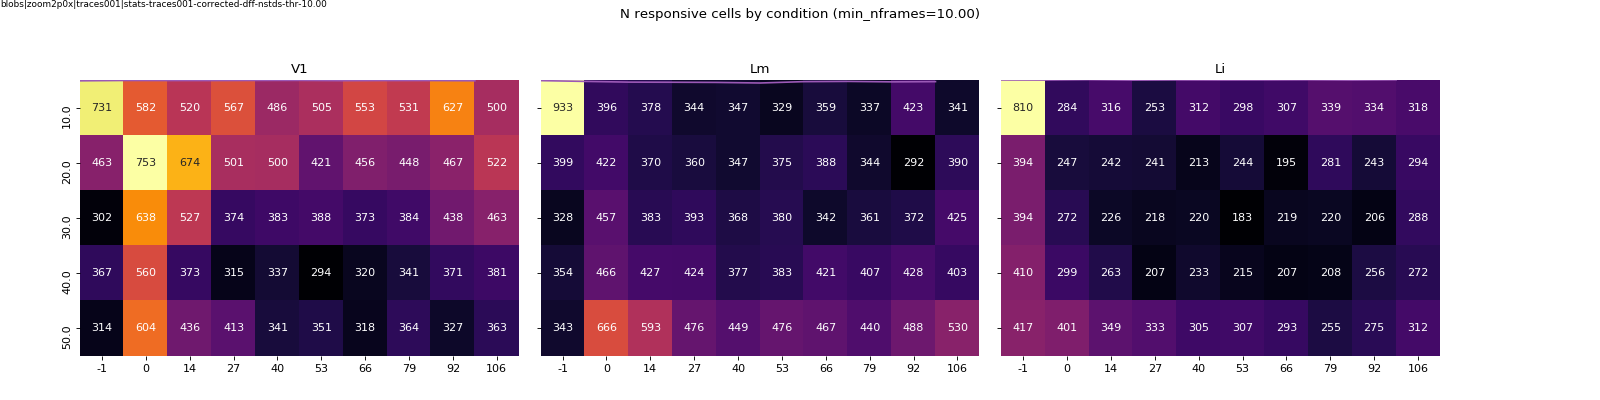

In [210]:
nr=5
nc=10
cmap = 'inferno'
normalize = False

fig, axes = pl.subplots(1,3, sharex=True, sharey=True, figsize=(20, 5))
fig.patch.set_alpha(1)
#vmin = 0
#vmax = 1
for ax, visual_area in zip(axes, ['V1', 'Lm', 'Li']):
    agg_arr = np.empty((nr, nc))
    sessionkeys = sorted(ntotal[visual_area].keys(), key=natural_keys)
    ncells_total = [ntotal[visual_area][k] for k in sessionkeys]
    resp_array = [nresponsive[visual_area][k] for k in sessionkeys]
    for ncells, r_arr in zip(ncells_total, resp_array):
        if normalize:
            agg_arr += (r_arr / float(ncells))
        else:
            agg_arr += r_arr
    
    if normalize:
        agg_arr = agg_arr / float(len(sessionkeys))
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='.2g', annot=True, cbar=0,
                    vmin=vmin, vmax=vmax)
    else:
        agg_arr = agg_arr.astype(int)
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='d', annot=True, cbar=0)
        
    ax.set_yticklabels(sizes)
    ax.set_xticklabels(morphs)    
    ax.set_title(visual_area)

if normalize:
    title = 'perc. of responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f_normalized' % (responsive_test, responsive_thr)

else:
    title = 'N responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f' % (responsive_test, responsive_thr)

fig.suptitle(title)

pl.subplots_adjust(wspace=0.05, left=0.05, top=0.8)
label_figure(fig, data_identifier)


pl.savefig(os.path.join(outdir, '%s.png' % figname ))


In [190]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-tuning/stats-traces001-corrected-dff-nstds-thr-10.00'

#### Look at num responsive for 1 session

In [ ]:
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'


In [101]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)

rstats, _, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

... loading ROI stats: nstds


In [226]:
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = sorted(sdf['size'].unique())
morphs = sorted(sdf['morphlevel'].unique())

Getting stimulus info for: combined_blobs_static


In [228]:

nr = len(sizes)
nc = len(morphs)

ncells_arr = np.empty((nr, nc), dtype=int)
#fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True)
#cbar_ax = fig.add_axes([.91, .3, .03, .4])
#i  = 0
for ri, sz in enumerate(sizes):
    for mi, mp in enumerate(morphs):
        cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
        ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
        ncells_arr[ri, mi] = ncells_resp
        

<IPython.core.display.Javascript object>


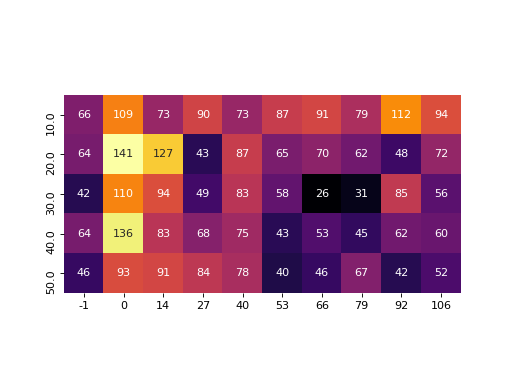

[Text(0.5,0,u'-1'),
 Text(1.5,0,u'0'),
 Text(2.5,0,u'14'),
 Text(3.5,0,u'27'),
 Text(4.5,0,u'40'),
 Text(5.5,0,u'53'),
 Text(6.5,0,u'66'),
 Text(7.5,0,u'79'),
 Text(8.5,0,u'92'),
 Text(9.5,0,u'106')]

In [229]:
fig, ax  = pl.subplots()
sns.heatmap(ncells_arr, ax=ax,cmap=cmap, square=True, fmt='d', annot=True, cbar=0)
ax.set_yticklabels(sizes)
ax.set_xticklabels(morphs)